# 0. Setup

In [1]:
# General utilities
import os
from dotenv import load_dotenv
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import io
import json
from tqdm import tqdm
from collections import defaultdict
import time

# For authentication
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Geospatial tools
import geopandas as gpd

# Image processing
from PIL import Image
import tifffile
import rasterio
import torch

# Custom library
from library import utilities, visualizations, preprocessing

`geopandas` documentation: https://geopandas.org/en/stable/

In [2]:
# Set paths
root_output_dir = '/media/pablo/Shared files/data/'  # Adjust this according to your setup - here the satellite images will be stored (and weight a lot)

# 1. Loading the wildfires data from Catalunya

In [3]:
gdf = gpd.read_file(os.path.join('catalunya_fire_data', 'clean_data', 'catalunya_fires_cleaned.shp'))
gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84
# Convert date_activ to datetime using pandas
gdf['date_activ'] = pd.to_datetime(
    gdf['date_activ'], 
    format='mixed',  # Some are stored as DD/MM/YY, others as DD/MM/YYYY
    errors='raise'
)
gdf.head()

fire_code                municip date_activ  year  \
0  2014080187                  Tiana 2014-01-26  2014   
1  2014170069                  Roses 2014-10-22  2014   
2  2014250067                    Les 2014-03-17  2014   
3  2014250068  Sant Guim de la Plana 2014-07-17  2014   
4  2014250069                 Oliola 2014-06-21  2014   

                                            geometry  
0  POLYGON ((2.27641 41.49769, 2.27648 41.49766, ...  
1  POLYGON ((3.22466 42.24001, 3.22464 42.24004, ...  
2  MULTIPOLYGON (((0.70981 42.82654, 0.70987 42.8...  
3  POLYGON ((1.35591 41.7573, 1.35595 41.75733, 1...  
4  POLYGON ((1.23054 41.91515, 1.23053 41.91515, ...

# 2. Retrieving satellite images from wildfire locations

Following the retrieval method in https://dl.acm.org/doi/10.1145/3511808.3557528, we retrieve data from "Sentinel-2 L2A and Sentinel-1 GRD missions in a timespan of 2 months given the activation date of each wildfire provided by Copernicus EMS: 1 month prior and 1 month after the activation date."

Documentation for extracting satellite imagery data using the Sentinel Hub (which is what they use in the paper): https://dataspace.copernicus.eu/analyse/apis/sentinel-hub. 
- Relevant documentation for the APIs:
  - Processing API: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html
    - Examples:
      - Requests of Sentinel-1 GRD data: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process/Examples/S1GRD.html
      - Requests of Sentinel-2 L2A data: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process/Examples/S2L2A.html 
    - Customizing the request script: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html
  - Catalogue API: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Catalog.html
- First, need to create an OAuth client: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html#python
  - Install `oauthlib`: https://pypi.org/project/oauthlib/
  - Documentation: https://oauth.net/code/python/
  - Instructions: to access the Processing API, you need to create an OAuth client first through the Copernicus Dashboard:
    1. Go to the Dashboard: https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings
    2. Open the "User Settings" tab
    3. Find the "OAuth clients" section
    4. Click "Create" button
    5. Provide a name for your OAuth client
    6. Set expiry date
    7. Click "Create"
    8. Copy both the client ID and client secret (the secret won't be shown again!). Save them in the `.env` file in this folder.

- Alternative for accessing the data in a visual dashboard: [Copernicus Hub](https://browser.dataspace.copernicus.eu).

## 2.1. Requirements of images to match the images from the paper

- Time frame: "Sentinel-2 L2A and Sentinel-1 GRD missions in a timespan of 2 months given the activation date of each wildfire provided by Copernicus EMS: 1 month prior and 1 month after the activation date." But for fire severity assessment, only post-fire date can be used. As one of the possible tasks with their dataset, the authors suggest "[d]amage severity estimation based on post-wildfire imagery only and supervised techniques."
- "We downloaded the satellite imagery with the highest possible resolution, up to a maximum of 5000x5000 pixels".
- "Sentinel-1 data was acquired in IW mode with VV+VH polarisation." 
- "The images within the defined temporal range have been selected to (i) be available for at least the 90% of the desired AoI [Automated Optical Inspection] defined by the delineation, and (ii) cloud coverage must not exceed 10% of the acquisition."

Note, however, that:
- Sentinel-1 (radar data) has data available going back to the [3rd April 2014](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-1).
- Sentinel-2 data is available from the [23rd June 2015 onwards](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2).

Let's explore the image metadata for 2 sample `.tiff` files from the labelled dataset, both for Sentinel-1 GRD and Sentinel-2 L2A images.

In [4]:
# Set the path to the labelled dataset
base_input_dir = '/media/pablo/Shared files/data/'  # Adjust this path to your data directory containing the labelled dataset
input_labelled_dir = os.path.join(base_input_dir, 'Satellite_burned_area_dataset')  # Path to the original labelled dataset

# Set examples
sample_part = 'Satellite_burned_area_dataset_part1'  # Part of the dataset where the example files are located
sample_fire = 'EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector'
s1_example = os.path.join(input_labelled_dir, sample_part, sample_fire, 'sentinel1_2017-07-01.tiff')
s2_example = os.path.join(input_labelled_dir, sample_part, sample_fire, 'sentinel2_2017-07-04.tiff')

In [5]:
# Read TIFF file and metadata
print("Reading Sentinel-1 example TIFF file:")
with tifffile.TiffFile(s1_example) as tif:
    # Get all tags from first page
    page = tif.pages[0]
    for tag in page.tags.values():
        print(f"{tag.name}: {tag.value}")
    
    # Get specific metadata
    if hasattr(page, 'description'):
        print(f"Description: {page.description}")
    
    image_data = tif.asarray()
    if image_data.ndim == 3:
        num_bands = image_data.shape[2]  # Channels are in the 3rd dimension
    else:
        num_bands = 1
    print(f"Number of bands: {num_bands}")


print("\nReading Sentinel-2 example TIFF file:")
# Read TIFF file and metadata
with tifffile.TiffFile(s2_example) as tif:
    # Get all tags from first page
    page = tif.pages[0]
    for tag in page.tags.values():
        print(f"{tag.name}: {tag.value}")
    
    # Get specific metadata
    if hasattr(page, 'description'):
        print(f"Description: {page.description}")
    
    # Get image data
    image_data = tif.asarray()

    image_data = tif.asarray()
    if image_data.ndim == 3:
        num_bands = image_data.shape[2]  # Channels are in the 3rd dimension
    else:
        num_bands = 1
    print(f"Number of bands: {num_bands}")

Reading Sentinel-1 example TIFF file:
ImageWidth: 1635
ImageLength: 1341
BitsPerSample: (32, 32, 32, 32)
Compression: 32946
PhotometricInterpretation: 2
StripOffsets: (1751, 123022, 243562, 364712, 485692, 606045, 726904, 847427, 968360, 1089767, 1211327, 1332172, 1453190, 1574715, 1695846, 1817188, 1938482, 2059688, 2181347, 2302623, 2423249, 2544072, 2665088, 2786288, 2907715, 3028820, 3149919, 3271281, 3391851, 3512731, 3633598, 3754066, 3874511, 3994920, 4115377, 4235820, 4356428, 4477330, 4598154, 4718817, 4839109, 4959779, 5080976, 5201993, 5322910, 5443799, 5564764, 5686481, 5808425, 5929838, 6051037, 6171642, 6292349, 6413076, 6533877, 6655041, 6776028, 6897071, 7017927, 7138754, 7259232, 7379903, 7500681, 7621585, 7742455, 7862949, 7983732, 8104325, 8225495, 8346491, 8467769, 8588657, 8709144, 8830095, 8950956, 9072036, 9193568, 9314761, 9435383, 9556117, 9676985, 9797662, 9918106, 10037867, 10158038, 10278379, 10399122, 10519912, 10640507, 10761331, 10881246, 11000605, 111206

> In the labelled dataset:
> - The images from **Sentinel-1 GRD** have 4 dimensions (VV, 2VH, |VV|/|VH|/100 plus the coverage -validity- mask, in this order; see https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S1GRD.html#available-bands-and-data).
> - The images from **Sentinel-2 L2A** have 13 dimensions (bands B01-B12 from Sentinel-2 L2A, plus the coverage -validity- mask, in this order; see https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html#available-bands-and-data).

Source: presentation of the paper (https://dl.acm.org/doi/10.1145/3511808.3557528#supplementary-materials).

Screenshots from the presentation of the paper:

**Bands for satellite images**:

<img src="additional_content/paper_S1andS2_bands.png" alt="Satellite bands" style="width: 25%; height: auto;">

**Ground truth values of the masks**:

<img src="additional_content/paper_mask_values.png" alt="Mask values" style="width: 25%; height: auto;">

This classification matches the classification of wildfire severity made by the [Copernicus Emergency Management Service](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-severity):

| Class | dNBR range (multiplied by 1000) |
|-------|--------------------------------|
| Unburned or Regrowth | < 100 |
| Low severity | 100 - 270 |
| Moderate low severity | 270 - 440 |
| Moderate high severity | 440 - 660 |
| High severity | >=660 |

i.e., 5 classes, 4 for burned areas and 1 for unburned.

## 2.2. Setting up credentials

In [6]:
load_dotenv()  # Load environment variables from .env file

# Load credentials from environment variables (make sure to have a .env file with these variables)
client_id = os.getenv('COPERNICUS_CLIENT_ID')
client_secret = os.getenv('COPERNICUS_CLIENT_SECRET')

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)

b'[]'


`requests-oauthlib` doesn't check for status before checking if the response is ok. In case there's a server error, the user can receive an incorrect error, which falsely makes it seem as if the issue is on client side. Library's compliance hooks will prevent the invalid status response from being ignored, returning the correct error. To use them, add the following code:

## 2.3. Requests of necessary data



### Utilities

Request parameters:
- Request parameters for Sentinel-1 GRD: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S1GRD.html
- Request parameters for Sentinel-2 L2A: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html

About resolution:
- How to get images in higher resolution: https://documentation.dataspace.copernicus.eu/FAQ.html#how-can-i-get-images-in-higher-resolution
- Example of Processing API and setting higher resolution: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process/Examples/S2L1C.html#true-color-resolution-epsg-32633
- Available resolution for different bands: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L1C.html#available-bands-and-data. B02 (blue), B03 (green) and B04 (red) offer a resolution of 10m, but others offer a lower resolution (e.g., B01 of 60m).

> Notice that we extract the bands with the values specified in section 2.1 (the same as in the labelled dataset).

#### Sentinel-1 and 2 launch dates

In [ ]:
sentinel_1_launch_date = datetime.datetime(2014, 4, 3)  # Sentinel-1A launch date (April 3, 2014)
sentinel_2_launch_date = datetime.datetime(2015, 6, 23)  # Sentinel-2A launch date (June 23, 2015)

#### Sentinel-1 GRD acquisition function

In [15]:
def get_first_suitable_sentinel1_image(x_min, y_min, x_max, y_max, from_date_iso, to_date_iso, oauth,
                                       target_image_size=2500):
    """
    Get the first suitable Sentinel-1 GRD image in the date range with IW mode and VV+VH polarization.
    
    Args:
        x_min, y_min, x_max, y_max: Bounding box coordinates
        from_date_iso, to_date_iso: Date range in ISO format
        oauth: Authenticated OAuth session
        target_image_size: Target output image size in pixels (default: 2500)
    
    Returns:
        image_array: numpy array of the image
        metadata: dictionary with scene metadata
    """

    # Step 1: Query catalog for available Sentinel-1 scenes
    catalog_request = {
        "bbox": [x_min, y_min, x_max, y_max],
        "datetime": f"{from_date_iso}/{to_date_iso}",
        "collections": ["sentinel-1-grd"],
        "limit": 100
    }
    
    catalog_url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/search"
    catalog_response = oauth.post(catalog_url, json=catalog_request)
    
    if catalog_response.status_code != 200:
        print(f"Catalog request failed: {catalog_response.status_code}")
        print(catalog_response.text)
        return None, None
    
    catalog_data = catalog_response.json()
    features = catalog_data.get('features', [])
    
    if not features:
        print("No Sentinel-1 scenes found in the specified date range and location!")
        return None, None
    
    # Step 2: Filter scenes for IW mode and dual polarization (VV+VH)
    suitable_scenes = []
    for feature in features:
        properties = feature['properties']
        
        sensor_mode = properties.get('sar:instrument_mode', '').upper()
        # Catalog can have 's1:polarization' (e.g., 'DV') or 'sar:polarizations' (e.g., ['VV', 'VH'])
        s1_polarization = properties.get('s1:polarization', '').upper()
        sar_polarizations = properties.get('sar:polarizations', [])

        is_iw_mode = sensor_mode == 'IW'
        is_dual_pol = (s1_polarization == 'DV') or ('VV' in sar_polarizations and 'VH' in sar_polarizations)
        
        if is_iw_mode and is_dual_pol:
            suitable_scenes.append({
                'feature': feature,
                'id': feature['id'],
                'datetime': properties['datetime'],
                'platform': properties.get('platform', 'Unknown'),
                'sensor_mode': sensor_mode,
                'polarizations': sar_polarizations or s1_polarization,
                'orbit_direction': properties.get('sat:orbit_state', 'Unknown')
            })
    
    if not suitable_scenes:
        print("No suitable Sentinel-1 scenes found with IW mode and DV (VV+VH) polarization!")
        print("Available scenes (first 5):")
        for feature in features[:5]:
            properties = feature['properties']
            print(f"  Date: {properties['datetime']}")
            print(f"  Mode: {properties.get('sar:instrument_mode', 'N/A')}")
            print(f"  Polarization (s1): {properties.get('s1:polarization', 'N/A')}")
            print(f"  Polarizations (sar): {properties.get('sar:polarizations', 'N/A')}")
            print("  ---")
        return None, None
    
    # Step 3: Sort suitable scenes by date (earliest first)
    suitable_scenes.sort(key=lambda x: x['datetime'])
    
    # Step 4: Select the first suitable scene
    selected_scene = suitable_scenes[0]
    print(f"Selected Sentinel-1 scene: {selected_scene['id']}")
    print(f"Date: {selected_scene['datetime']}")
    print(f"Platform: {selected_scene['platform']}")
    print(f"Sensor mode: {selected_scene['sensor_mode']}")
    print(f"Polarizations: {selected_scene['polarizations']}")
    print(f"Orbit direction: {selected_scene['orbit_direction']}")
    
    # Step 5: Define evalscript for 4 bands: VV, 2*VH, |VV|/|VH|/100, dataMask
    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["VV", "VH", "dataMask"],
            output: { 
                id: "default", 
                bands: 4,
                sampleType: "FLOAT32" 
            },
        }
    }

    function evaluatePixel(sample) {
        // To avoid division by zero, add a small epsilon if VH is 0
        let vh_safe = sample.VH === 0 ? 1e-6 : sample.VH;
        
        let ratio = Math.abs(sample.VV) / Math.abs(vh_safe) / 100.0;

        return [
            sample.VV, 
            2 * sample.VH, 
            ratio,
            sample.dataMask
        ];
    }
    """
    
    # Step 6: Create processing request
    scene_date = selected_scene['datetime']
    scene_date_only = scene_date.split('T')[0]
    
    # Calculate bounding box dimensions and output size (copied from S2 function)
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min
    aspect_ratio = bbox_width / bbox_height

    min_size = 512
    if abs(aspect_ratio - 1.0) < 0.1:
        output_width = target_image_size
        output_height = target_image_size
    elif aspect_ratio >= 1:
        output_width = target_image_size
        output_height = int(target_image_size / aspect_ratio)
        if output_height < min_size:
            output_height = min_size
            output_width = int(min_size * aspect_ratio)
    else:
        output_height = target_image_size
        output_width = int(target_image_size * aspect_ratio)
        if output_width < min_size:
            output_width = min_size
            output_height = int(min_size / aspect_ratio)

    output_width = max(output_width, min_size)
    output_height = max(output_height, min_size)

    print(f"Bounding box aspect ratio: {aspect_ratio:.3f}")
    print(f"Output dimensions: {output_width}x{output_height}")

    request = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
                "bbox": [x_min, y_min, x_max, y_max],
            },
            "data": [
                {
                    "type": "sentinel-1-grd",
                    "dataFilter": {
                        "timeRange": {
                            "from": f"{scene_date_only}T00:00:00Z",
                            "to": f"{scene_date_only}T23:59:59Z",
                        },
                        "acquisitionMode": "IW",
                        "polarization": "DV"  # Dual VV+VH
                    },
                    "processing": {
                        "orthorectify": True,
                        "backCoeff": "GAMMA0_TERRAIN",
                        "demInstance": "COPERNICUS_30"
                    }
                }
            ],
        },
        "output": {
            "width": output_width,
            "height": output_height,
            "responses": [
                {
                    "identifier": "default",
                    "format": {"type": "image/tiff", "sampleFormat": "FLOAT32"}
                }
            ],
        },
        "evalscript": evalscript,
    }
    
    # Step 7: Make the processing request
    print(f"Processing Sentinel-1 image ({output_width}x{output_height})...")
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    response = oauth.post(url, json=request)
    
    if response.status_code != 200:
        print(f"Processing failed with status code {response.status_code}")
        print(response.text)
        return None, None
    
    # Step 8: Process the response using rasterio
    print("Processing successful! Converting image...")
    image_data = response.content
    with rasterio.io.MemoryFile(image_data) as memfile:
        with memfile.open() as dataset:
            image_array = np.transpose(dataset.read(), (1, 2, 0))
    
    # Step 9: Create metadata dictionary
    metadata = {
        'scene_id': selected_scene['id'],
        'datetime': selected_scene['datetime'],
        'platform': selected_scene['platform'],
        'sensor_mode': selected_scene['sensor_mode'],
        'polarizations': selected_scene['polarizations'],
        'orbit_direction': selected_scene['orbit_direction'],
        'bbox': [x_min, y_min, x_max, y_max],
        'resolution': f'{output_width}x{output_height}',
        'aspect_ratio': aspect_ratio,
        'bbox_width_deg': bbox_width,
        'bbox_height_deg': bbox_height,
        'image_shape': image_array.shape,
        'image_dtype': str(image_array.dtype),
        'file_size_bytes': len(image_data),
        'data_type': 'sentinel-1-grd'
    }
    
    return image_array, metadata

#### Sentinel-2 L2A acquisition function

In [ ]:
def get_first_suitable_sentinel2_image(x_min, y_min, x_max, y_max, from_date_iso, to_date_iso, oauth, max_cloud_cover=10,
                                       target_image_size=2500):
    """
    Get the first Sentinel-2 image in the date range with cloud coverage ≤ max_cloud_cover
    
    Args:
        x_min, y_min, x_max, y_max: Bounding box coordinates
        from_date_iso, to_date_iso: Date range in ISO format
        oauth: Authenticated OAuth session
        max_cloud_cover: Maximum acceptable cloud coverage percentage (default: 10%)
        target_image_size: Target output image size in pixels (default: 2500x2500)
    
    Returns:
        image_array: numpy array of the image
        metadata: dictionary with scene metadata
    """

    # Step 1: Query catalog for available scenes
    catalog_request = {
        "bbox": [x_min, y_min, x_max, y_max],
        "datetime": f"{from_date_iso}/{to_date_iso}",
        "collections": ["sentinel-2-l2a"],
        "limit": 100  # Get more scenes to find suitable ones
    }
    
    catalog_url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/search"
    catalog_response = oauth.post(catalog_url, json=catalog_request)
    
    if catalog_response.status_code != 200:
        print(f"Catalog request failed: {catalog_response.status_code}")
        print(catalog_response.text)
        return None, None
    
    catalog_data = catalog_response.json()
    features = catalog_data.get('features', [])
    
    if not features:
        print("No scenes found in the specified date range and location!")
        return None, None
    
    # Step 2: Filter scenes by cloud coverage and find the first suitable one
    suitable_scenes = []
    for feature in features:
        properties = feature['properties']
        cloud_cover = properties.get('eo:cloud_cover')
        
        if cloud_cover is not None and cloud_cover <= max_cloud_cover:
            suitable_scenes.append({
                'feature': feature,
                'id': feature['id'],
                'datetime': properties['datetime'],
                'cloud_cover': cloud_cover,
                'platform': properties.get('platform', 'Unknown')
            })
    
    if not suitable_scenes:
        print(f"No scenes found with cloud coverage ≤ {max_cloud_cover}%")
        print("Available scenes:")
        for feature in features[:5]:  # Show first 5 scenes
            properties = feature['properties']
            print(f"  Date: {properties['datetime']}, Cloud: {properties.get('eo:cloud_cover', 'N/A')}%")
        return None, None
    
    # Step 3: Sort suitable scenes by date (earliest first)
    suitable_scenes.sort(key=lambda x: x['datetime'])

    # Step 4: Select the first suitable scene (earliest date)
    selected_scene = suitable_scenes[0]
    print(f"Selected scene: {selected_scene['id']}")
    print(f"Date: {selected_scene['datetime']}")
    print(f"Cloud coverage: {selected_scene['cloud_cover']}%")
    print(f"Platform: {selected_scene['platform']}")
    
    # Step 5: Define evalscript for getting the same bands as in the labelled dataset
    # B04 is Red, B03 is Green, B02 is Blue (RGB)
    evalscript = """
    //VERSION=3
    function setup() {
      return {
        input: [
            {
            bands: [  // Include all bands and data mask
                "B01",  // Coastal aerosol
                "B02",  // Blue
                "B03",  // Green
                "B04",  // Red
                "B05",  // Vegetation red edge 1
                "B06",  // Vegetation red edge 2
                "B07",  // Vegetation red edge 3
                "B08",  // NIR
                "B8A",  // Narrow NIR
                "B09", // Water vapor
                "B11",  // SWIR 1
                "B12",  // SWIR 2
                "dataMask"  // Data mask to handle invalid pixels
                ]
            },
        ],
        output: {
          bands: 13,
          sampleType: "FLOAT32"  // Retrieve as float32 for better precision (but values not bounded in [0, 1] or [0, 255])
        }
      }
    }

    function evaluatePixel(sample) {
      // Enhanced RGB with slight contrast boost
      return [
        sample.B01,
        sample.B02, // B02 is Blue (no boost)
        sample.B03, // B03 is Green (no boost)
        sample.B04,  // B04 is Red (no boost)
        sample.B05,
        sample.B06,
        sample.B07,
        sample.B08,
        sample.B8A,
        sample.B09,
        sample.B11,
        sample.B12,
        sample.dataMask  // Include data mask to handle invalid pixels
        ]
    }
    """

    # # Old evalscript for RGB only (commented out)
    # evalscript = """
    # //VERSION=3
    # function setup() {
    #   return {
    #     input: ["B02", "B03", "B04"],
    #     output: {
    #       bands: 3,
    #       sampleType: "AUTO"  // default value - scales the output values from [0,1] to [0,255].
    #     }
    #   }
    # }

    # function evaluatePixel(sample) {
    #   // Enhanced RGB with slight contrast boost
    #   return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    # }
    # """
    
    # Step 6: Create processing request for 5000x5000 pixels
    scene_date = selected_scene['datetime']
    # Convert to date-only format for precise scene selection
    scene_date_only = scene_date.split('T')[0]  # Extract date part only
    
    # Calculate bounding box dimensions
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min
    aspect_ratio = bbox_width / bbox_height

    # Ensure both dimensions are at least 512 pixels
    min_size = 512  # Minimum size for training compatibility
    
    if abs(aspect_ratio - 1.0) < 0.1:  # Nearly square
        output_width = target_image_size
        output_height = target_image_size
    elif aspect_ratio >= 1:  # Width > Height
        output_width = target_image_size
        output_height = int(target_image_size / aspect_ratio)
        # Ensure height is at least 512
        if output_height < min_size:
            output_height = min_size
            output_width = int(min_size * aspect_ratio)
    else:  # Height > Width
        output_height = target_image_size
        output_width = int(target_image_size * aspect_ratio)
        # Ensure width is at least 512
        if output_width < min_size:
            output_width = min_size
            output_height = int(min_size / aspect_ratio)

    # Final safety check - ensure both dimensions are at least 512
    output_width = max(output_width, min_size)
    output_height = max(output_height, min_size)

    print(f"Bounding box: {bbox_width:.6f}° x {bbox_height:.6f}°")
    print(f"Aspect ratio: {aspect_ratio:.3f}")
    print(f"Output dimensions: {output_width}x{output_height}")

    request = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
                "bbox": [x_min, y_min, x_max, y_max],
            },
            "data": [
                {
                    "type": "sentinel-2-l2a",
                    "dataFilter": {
                        "timeRange": {
                            "from": f"{scene_date_only}T00:00:00Z",
                            "to": f"{scene_date_only}T23:59:59Z",
                        }
                    },
                    "processing": {
                        "upsampling": "BILINEAR"  # Use bilinear upsampling for better quality
                    }
                }
            ],
        },
        "output": {
            "width": output_width,  # Maximum resolution available
            "height": output_height,  # Maximum resolution available
            # "resx": 1500,
            # "resy": 1500
            "responses": [
                {
                    "identifier": "default",
                    "format": {"type": "image/tiff", "sampleFormat": "FLOAT32"}  # Return as TIFF image
                }
            ],
        },
        "evalscript": evalscript,
    }
    
    # Step 7: Make the processing request
    print(f"Processing high-resolution image ({output_width}x{output_height})...")
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    response = oauth.post(url, json=request)
    
    if response.status_code != 200:
        print(f"Processing failed with status code {response.status_code}")
        print(response.text)
        return None, None
    
    # Step 8: Process the response
    print("Processing successful! Converting image...")
    image_data = response.content
    with rasterio.io.MemoryFile(image_data) as memfile:
        with memfile.open() as dataset:
            # Rasterio reads in (bands, height, width) order.
            # We transpose to (height, width, bands) for consistency with libraries like matplotlib.
            image_array = np.transpose(dataset.read(), (1, 2, 0))
    
    # Step 9: Create metadata dictionary
    metadata = {
        'scene_id': selected_scene['id'],
        'datetime': selected_scene['datetime'],
        'cloud_cover': selected_scene['cloud_cover'],
        'platform': selected_scene['platform'],
        'bbox': [x_min, y_min, x_max, y_max],
        'resolution': f'{output_width}x{output_height}',
        'aspect_ratio': aspect_ratio,
        'bbox_width_deg': bbox_width,
        'bbox_height_deg': bbox_height,
        'image_shape': image_array.shape,
        'image_dtype': str(image_array.dtype),
        'file_size_bytes': len(image_data)
    }
    
    return image_array, metadata

### Example

#### Sample wildfire

In [9]:
# Filter to fires with an activation date after both Sentinel launches
gdf_filtered = gdf[gdf['date_activ'] > sentinel_2_launch_date]
first_fire = gdf_filtered.head(1)

first_fire

fire_code municip date_activ  year  \
11  2015080225  ÃDENA 2015-07-26  2015   

                                             geometry  
11  MULTIPOLYGON (((1.66951 41.63021, 1.66981 41.6...

In [10]:
# Now, get one month later from the first fire's activation date
first_fire_date = first_fire['date_activ'].values[0]
one_month_later = first_fire_date + pd.Timedelta(days=30)

# Create a bounding box around the first fire
bbox = first_fire.geometry.bounds.values[0]
bbox = [bbox[0], bbox[1], bbox[2], bbox[3]]  # [minx, miny, maxx, maxy]

# Print the bounding box and the date one month later
print(f"Bounding Box: {bbox}")
print(f"Date one month later: {one_month_later}")

Bounding Box: [np.float64(1.6632070712764817), np.float64(41.62078229507559), np.float64(1.7591148856231957), np.float64(41.6603653453595)]
Date one month later: 2015-08-25 00:00:00


In [11]:
# Use GeoPandas buffer method for more accurate buffering
# First, reproject to a projected CRS for accurate distance calculations
# Use UTM zone appropriate for Catalunya (UTM Zone 31N, EPSG:25831) - for converting
# degrees to meters
first_fire_projected = first_fire.to_crs(epsg=25831)  # UTM Zone 31N for Catalunya  (see https://epsg.io/map#srs=25831-1149&x=424888.602437&y=4659994.712628&z=4&layer=streets)
bbox_projected = first_fire_projected.geometry.bounds.values[0]

# Calculate buffer distance as 25% of the average of width and height (in meters)
avg_dimension = ((bbox_projected[2] - bbox_projected[0]) + (bbox_projected[3] - bbox_projected[1])) / 2
buffer_distance_meters = avg_dimension * 0.25

# Create buffered geometry in projected CRS
buffered_geometry_projected = first_fire_projected.geometry.buffer(buffer_distance_meters)

# Convert back to WGS84 for use with Sentinel Hub API
buffered_geometry = buffered_geometry_projected.to_crs(epsg=4326)
buffer_bbox = buffered_geometry.bounds.values[0].tolist()

print(f"Original Bounding Box (WGS84): {bbox}")
print(f"Buffered Bounding Box (WGS84): {buffer_bbox}")
print(f"Buffer distance: {buffer_distance_meters:.1f} meters")

Original Bounding Box (WGS84): [np.float64(1.6632070712764817), np.float64(41.62078229507559), np.float64(1.7591148856231957), np.float64(41.6603653453595)]
Buffered Bounding Box (WGS84): [1.6446788063471893, 41.60688083521271, 1.7776460291729006, 41.67426687043064]
Buffer distance: 1543.8 meters


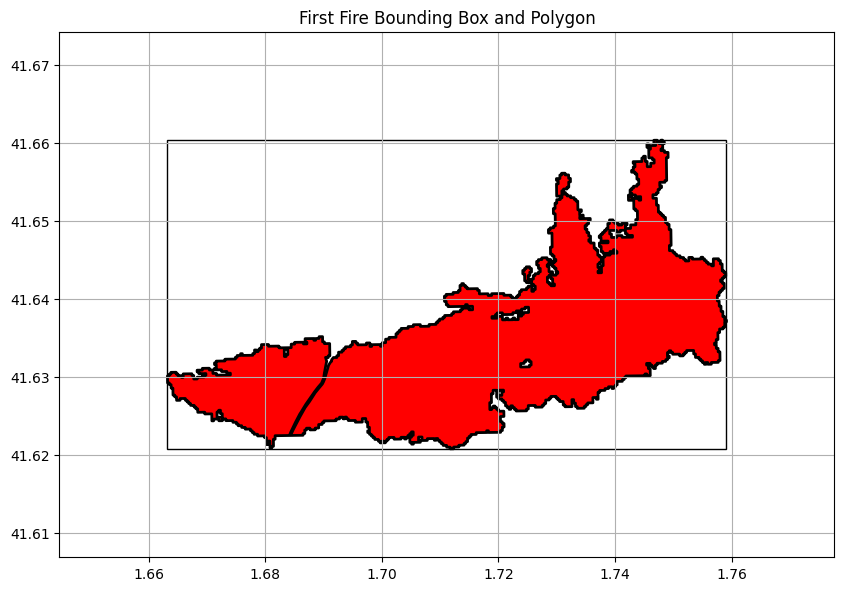

In [12]:
# Display the original and the new bounding box and the polygon of the first fire
fig, ax = plt.subplots(figsize=(10, 10))
first_fire.geometry.plot(ax=ax, color='red', edgecolor='black', linewidth=2)
ax.set_title('First Fire Bounding Box and Polygon')
plt.xlim(buffer_bbox[0], buffer_bbox[2])  # Set x limits to the bounding box
plt.ylim(buffer_bbox[1], buffer_bbox[3])  # Set y limits to the bounding box
# Create a rectangle for the original bounding box
rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='black', facecolor='none', label='Original Bounding Box')
ax.add_patch(rect)
plt.grid(True)
plt.show()

In [13]:
# Get the fire code for the first fire
fire_code = first_fire['fire_code'].values[0]

# Set the bounding box coordinates
x_min = buffer_bbox[0]
x_max = buffer_bbox[2]
y_min = buffer_bbox[1]
y_max = buffer_bbox[3]

# Set the date range for the request (one week before and one week after one month later
# of the fire activation date)
from_date = one_month_later - pd.Timedelta(days=7)
to_date = one_month_later + pd.Timedelta(days=7)

# Convert to ISO 8601 format with Z suffix for UTC timezone
from_date_iso = from_date.strftime('%Y-%m-%dT%H:%M:%SZ')
to_date_iso = to_date.strftime('%Y-%m-%dT%H:%M:%SZ')

print(f"From date: {from_date_iso}")
print(f"To date: {to_date_iso}")

From date: 2015-08-18T00:00:00Z
To date: 2015-09-01T00:00:00Z


#### Sentinel-2 L2A data

Now, let's get the data for the Sentinel-2 L2A using their example as the template.

In [20]:
# Load credentials from environment variables
client_id = os.getenv('COPERNICUS_CLIENT_ID')
client_secret = os.getenv('COPERNICUS_CLIENT_SECRET')

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# Execute the pipeline
print("=== SENTINEL-2 IMAGE ACQUISITION PIPELINE ===")
print(f"Searching for images from {from_date_iso} to {to_date_iso}")
print(f"Bounding box: [{x_min:.6f}, {y_min:.6f}, {x_max:.6f}, {y_max:.6f}]")
print(f"Max cloud coverage: 10%")
print()

image_array, metadata = get_first_suitable_sentinel2_image(
    x_min, y_min, x_max, y_max, 
    from_date_iso, to_date_iso, 
    oauth, 
    max_cloud_cover=10
)

=== SENTINEL-2 IMAGE ACQUISITION PIPELINE ===
Searching for images from 2015-08-18T00:00:00Z to 2015-09-01T00:00:00Z
Bounding box: [1.644679, 41.606881, 1.777646, 41.674267]
Max cloud coverage: 10%

Selected scene: S2A_MSIL2A_20150825T105046_N0500_R051_T31TCG_20231018T041328.SAFE
Date: 2015-08-25T10:59:26.343Z
Cloud coverage: 2.27%
Platform: sentinel-2a
Bounding box: 0.132967° x 0.067386°
Aspect ratio: 1.973
Output dimensions: 2500x1266
Processing high-resolution image (2500x1266)...
Processing successful! Converting image...



=== IMAGE SUCCESSFULLY ACQUIRED ===
Scene ID: S2A_MSIL2A_20150825T105046_N0500_R051_T31TCG_20231018T041328.SAFE
Acquisition date: 2015-08-25T10:59:26.343Z
Cloud coverage: 2.27%
Image shape: (1266, 2500, 13)
File size: 87.8 MB


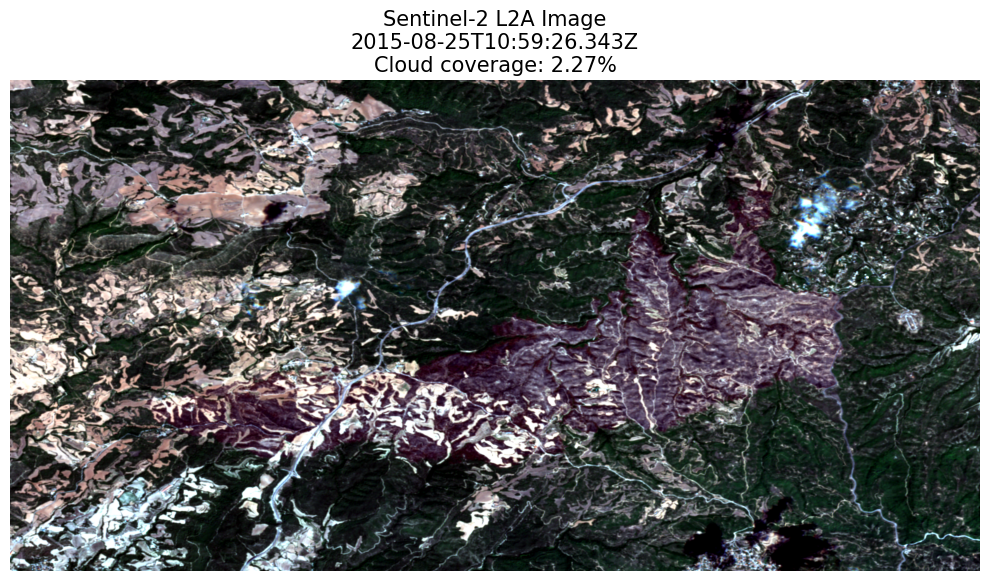


=== IMAGE STATISTICS ===
Min pixel value: 0.0
Max pixel value: 3.6005001068115234
Mean pixel value: 0.23
Standard deviation: 0.24


In [ ]:
if image_array is not None and metadata is not None:
    print("\n=== IMAGE SUCCESSFULLY ACQUIRED ===")
    print(f"Scene ID: {metadata['scene_id']}")
    print(f"Acquisition date: {metadata['datetime']}")
    print(f"Cloud coverage: {metadata['cloud_cover']}%")
    print(f"Image shape: {metadata['image_shape']}")
    print(f"File size: {metadata['file_size_bytes'] / (1024*1024):.1f} MB")
    
    # Convert numpy array to torch tensor for visualization
    # The array is (height, width, channels), but the function expects (channels, height, width)
    image_tensor = torch.from_numpy(image_array).permute(2, 0, 1)

    # Display the image using the custom visualization function
    # For Sentinel-2, true color is B04 (Red), B03 (Green), B02 (Blue)
    # These correspond to indices 3, 2, and 1 in the 13-band array
    visualizations.display_image(
        image=image_tensor,
        title=f'Sentinel-2 L2A Image\n{metadata["datetime"]}\nCloud coverage: {metadata["cloud_cover"]}%',
        rgb_bands=(3, 2, 1),  # Corresponding to B04, B03, B02 bands
        figsize=(10, 10)
    )
    
    # Save the image and metadata
    scene_id_clean = metadata['scene_id'].replace('/', '_').replace(':', '_').split('SAFE')[0]
    image_filename = f"sentinel2_{scene_id_clean}.png"
    metadata_filename = f"sentinel2_{scene_id_clean}_metadata.json"
    
    # Display some statistics
    print(f"\n=== IMAGE STATISTICS ===")
    print(f"Min pixel value: {image_array.min()}")
    print(f"Max pixel value: {image_array.max()}")
    print(f"Mean pixel value: {image_array.mean():.2f}")
    print(f"Standard deviation: {image_array.std():.2f}")
    
else:
    print("\n=== FAILED TO ACQUIRE IMAGE ===")
    print("No suitable images found with the specified criteria.")
    print("Consider:")
    print("- Increasing the date range")
    print("- Increasing max cloud coverage threshold")
    print("- Checking if the location has Sentinel-2 coverage")

### Saving images for ALL fires

The folder structure of the requested images is as follows:

```
catalunya_fire_imgs
    ├── 2014
    │   ├── images
    │   │   └── sentinel1_2014-10-22_lon3-223_lat42-244.tiff
    │   └── metadata
    │       └── sentinel1_2014-10-22_lon3-223_lat42-244.json
    ├── 2015
    │   ├── images
    │   │   ├── sentinel1_2015-01-07_lon2-150_lat41-445.tiff
    │   │   ├── sentinel1_2015-03-31_lon1-222_lat42-610.tiff
    │   │   ...
    │   │   ├── sentinel1_2015-07-13_lon3-161_lat42-432.tiff
    │   │   ├── sentinel1_2015-07-21_lon2-837_lat41-979.tiff
    │   │   ├── sentinel1_2015-07-26_lon1-719_lat41-635.tiff
    │   │   ...
    │   │   ├── sentinel2_2015-07-13_lon3-161_lat42-432.tiff
    │   │   ├── sentinel2_2015-07-26_lon1-719_lat41-635.tiff
    │   │   ├── sentinel2_2015-08-03_lon0-708_lat42-826.tiff
    │   │   ...
    │   └── metadata
    │       ├── sentinel1_2015-01-07_lon2-150_lat41-445.json
    │       ├── sentinel1_2015-03-31_lon1-222_lat42-610.json
    │       ...
    │       ├── sentinel1_2015-07-13_lon3-161_lat42-432.json
    │       ├── sentinel1_2015-07-21_lon2-837_lat41-979.json
    │       ├── sentinel1_2015-07-26_lon1-719_lat41-635.json
    │       ...
    │       ├── sentinel2_2015-07-13_lon3-161_lat42-432.json
    │       ├── sentinel2_2015-07-26_lon1-719_lat41-635.json
    │       ├── sentinel2_2015-08-03_lon0-708_lat42-826.json
    │       ...
    ├── 2016
    ...
```

Where each of the filenames (for the S1 and S2 images and for the data) stand for the Sentinel satellite, the activation date of the fire (as given by the data of the fires in Catalunya) and the longitude and latitude of the fire centroid (in degrees) with 3 decimals of precision. Therefore, images and metadata for Sentinel-1 and Sentinel-2 for the same fire have the same prefix after the satellite denomination.

In [9]:
# Calculate the largest dimension of the bounding box in meters for all fires

# First, reproject all fires to UTM Zone 31N for accurate distance calculations
gdf_projected = gdf.to_crs(epsg=25831)  # UTM Zone 31N for Catalunya

# Calculate fire dimensions for all fires
fire_dimensions = []

for index, fire in gdf_projected.iterrows():
    # Get the fire bounds
    bounds = fire.geometry.bounds
    
    # Calculate dimensions in meters
    fire_width_m = bounds[2] - bounds[0]  # maxx - minx
    fire_height_m = bounds[3] - bounds[1]  # maxy - miny
    fire_max_dimension_m = max(fire_width_m, fire_height_m)
    fire_area_m2 = fire.geometry.area
    
    fire_dimensions.append({
        'fire_code': fire['fire_code'],
        'year': fire['year'],
        'date_activ': fire['date_activ'],
        'width_m': fire_width_m,
        'height_m': fire_height_m,
        'max_dimension_m': fire_max_dimension_m,
        'area_m2': fire_area_m2,
        'area_km2': fire_area_m2 / 1_000_000
    })

# Convert to DataFrame for easier analysis
fire_dims_df = pd.DataFrame(fire_dimensions)

# Display statistics
print("=== FIRE DIMENSION STATISTICS ===")
print(f"Total number of fires: {len(fire_dims_df)}")
print(f"\nWidth statistics (meters):")
print(f"  Min: {fire_dims_df['width_m'].min():.1f}m")
print(f"  Max: {fire_dims_df['width_m'].max():.1f}m")
print(f"  Mean: {fire_dims_df['width_m'].mean():.1f}m")
print(f"  Median: {fire_dims_df['width_m'].median():.1f}m")

print(f"\nHeight statistics (meters):")
print(f"  Min: {fire_dims_df['height_m'].min():.1f}m")
print(f"  Max: {fire_dims_df['height_m'].max():.1f}m")
print(f"  Mean: {fire_dims_df['height_m'].mean():.1f}m")
print(f"  Median: {fire_dims_df['height_m'].median():.1f}m")

print(f"\nMaximum dimension statistics (meters):")
print(f"  Min: {fire_dims_df['max_dimension_m'].min():.1f}m")
print(f"  Max: {fire_dims_df['max_dimension_m'].max():.1f}m")
print(f"  Mean: {fire_dims_df['max_dimension_m'].mean():.1f}m")
print(f"  Median: {fire_dims_df['max_dimension_m'].median():.1f}m")
print(f"  75th percentile: {fire_dims_df['max_dimension_m'].quantile(0.75):.1f}m")
print(f"  90th percentile: {fire_dims_df['max_dimension_m'].quantile(0.90):.1f}m")
print(f"  95th percentile: {fire_dims_df['max_dimension_m'].quantile(0.95):.1f}m")
print(f"  99th percentile: {fire_dims_df['max_dimension_m'].quantile(0.99):.1f}m")

print(f"\nArea statistics (km²):")
print(f"  Min: {fire_dims_df['area_km2'].min():.4f} km²")
print(f"  Max: {fire_dims_df['area_km2'].max():.2f} km²")
print(f"  Mean: {fire_dims_df['area_km2'].mean():.3f} km²")
print(f"  Median: {fire_dims_df['area_km2'].median():.4f} km²")

=== FIRE DIMENSION STATISTICS ===
Total number of fires: 211

Width statistics (meters):
  Min: 184.8m
  Max: 12952.0m
  Mean: 1096.1m
  Median: 652.1m

Height statistics (meters):
  Min: 193.7m
  Max: 15960.4m
  Mean: 1217.1m
  Median: 723.9m

Maximum dimension statistics (meters):
  Min: 242.6m
  Max: 15960.4m
  Mean: 1399.3m
  Median: 790.0m
  75th percentile: 1445.7m
  90th percentile: 2805.3m
  95th percentile: 4347.9m
  99th percentile: 8855.9m

Area statistics (km²):
  Min: 0.0242 km²
  Max: 60.81 km²
  Mean: 1.245 km²
  Median: 0.1840 km²


#### Saving Sentinel-2 images for all fires after S2-L2A launch date

In [13]:
# --- 1. Parameters that can be customized ---

output_folder = os.path.join(root_output_dir, 'catalunya_fire_imgs')  # Custom output folder for images

buffer = 0.25  # Buffer size in in reprojected meters (x% more of the average dimension)

# target_image_size = 1000  # Fixed image size in pixels (if 1000, for example, the covered area will be of 10x10km, if 2500, it will be 25x25km)

# --- 2. Setup ---

load_dotenv()  # Load environment variables from .env file (credentials for Copernicus)

# Load credentials from environment variables
client_id = os.getenv('COPERNICUS_CLIENT_ID')
client_secret = os.getenv('COPERNICUS_CLIENT_SECRET')

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)
last_token_refresh_time = time.time()
token_refresh_interval = 5 * 60  # 5 minutes in seconds

sentinel_2_launch_date = datetime.datetime(2015, 6, 23)  # Sentinel-2A launch date (June 23, 2015)

# Filter to fires with an activation date after Sentinel-2 launch
gdf_filtered = gdf[gdf['date_activ'] > sentinel_2_launch_date]

# Loop over each fire and get Sentinel-2 images with progress bar
for index, fire in tqdm(gdf_filtered.iterrows(), total=len(gdf_filtered), desc="Processing fires"):
    
    # Check and refresh token if needed (every 5 minutes)
    if time.time() - last_token_refresh_time > token_refresh_interval:
        print("\nToken is older than 5 minutes, refreshing...")
        token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                                  client_secret=client_secret, include_client_id=True)
        last_token_refresh_time = time.time()
        print("Token refreshed successfully.")

    fire_code = fire['fire_code']  # Get the fire code
    fire_date = fire['date_activ']
    fire_date_str = fire_date.strftime('%Y-%m-%d')  # Format date as string for output
    fire_year = fire['year']
    
    # Create a single-row GeoDataFrame for the current fire
    current_fire = gdf_filtered.loc[[index]]  # Get current fire as GeoDataFrame
    
    # --- 3. Set the bounding box around the fire with a buffer ---

    # Get the current fire's actual bounds in projected coordinates
    current_fire_projected = current_fire.to_crs(epsg=25831)  # UTM Zone 31N for Catalunya
    fire_bounds = current_fire_projected.geometry.bounds.values[0]

    # Calculate fire dimensions in meters
    fire_width_m = fire_bounds[2] - fire_bounds[0]
    fire_height_m = fire_bounds[3] - fire_bounds[1]
    fire_max_dimension_m = max(fire_width_m, fire_height_m)

    print(f"Fire dimensions: {fire_width_m:.0f}m x {fire_height_m:.0f}m")
    print(f"Fire max dimension: {fire_max_dimension_m:.0f}m")

    # Set adaptive extent with buffer
    buffer_factor = 2.0  # Show 2x the fire size (100% buffer around fire)
    target_resolution_m = 10  # Sentinel-2 native resolution in meters

    min_image_size = 512   # Minimum for training compatibility (512x512 tiles)
    max_image_size = 5000  # Maximum for practical limits
    min_extent_m = min_image_size * target_resolution_m  # 5.12km for 512px
    max_extent_m = max_image_size * target_resolution_m  # 50km for 5000px

    # Calculate required extent
    required_extent_m = fire_max_dimension_m * buffer_factor
    extent_meters = max(min_extent_m, min(required_extent_m, max_extent_m))

    print(f"Final extent (after limits): {extent_meters:.0f}m")

    # Calculate corresponding image size to maintain 10m resolution
    target_image_size = int(extent_meters / target_resolution_m)

    # Ensure target_image_size is at least 512 (safety check)
    target_image_size = max(target_image_size, min_image_size)

    print(f"Required extent with buffer: {required_extent_m:.0f}m")
    print(f"Final extent (after constraints): {extent_meters:.0f}m")
    print(f"Target image size: {target_image_size}x{target_image_size} pixels")
    print(f"Actual coverage: {extent_meters/1000:.1f}km x {extent_meters/1000:.1f}km")
    print(f"Actual resolution: {extent_meters/target_image_size:.1f}m/pixel")

    # Get fire centroid and create centered bounding box
    fire_centroid = current_fire.geometry.centroid.iloc[0]
    center_x = fire_centroid.x  # x coordinate of the centroid (longitude)
    center_y = fire_centroid.y  # y coordinate of the centroid (latitude)

    # Convert extent to degrees
    lat_center = center_y
    meters_per_deg_lat = 111320
    meters_per_deg_lon = 111320 * np.cos(np.radians(lat_center))

    extent_deg_lat = extent_meters / meters_per_deg_lat
    extent_deg_lon = extent_meters / meters_per_deg_lon

    half_extent_lat = extent_deg_lat / 2
    half_extent_lon = extent_deg_lon / 2

    buffer_bbox = [
        center_x - half_extent_lon,  # x_min
        center_y - half_extent_lat,  # y_min
        center_x + half_extent_lon,  # x_max
        center_y + half_extent_lat   # y_max
    ]

    print(f"Fire centroid: ({center_x:.6f}, {center_y:.6f})")
    print(f"Centered bounding box: {buffer_bbox}")

    # Set the bounding box coordinates
    x_min = buffer_bbox[0]
    x_max = buffer_bbox[2]
    y_min = buffer_bbox[1]
    y_max = buffer_bbox[3]
        
    # --- 4. Set the date range for the request ---

    # Calculate one month later for THIS fire
    one_month_later = fire_date + pd.Timedelta(days=30)
    
    # Set date range for the request (2 weeks before and after one month later)
    from_date = one_month_later - pd.Timedelta(days=14)
    to_date = one_month_later + pd.Timedelta(days=14)
    
    # Convert to ISO 8601 format with Z suffix for UTC timezone
    from_date_iso = from_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    to_date_iso = to_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    # --- 5. Get the Sentinel-2 image and save the results ---

    print(f"Bounding box: {buffer_bbox}")
    print(f"Image size: {target_image_size}x{target_image_size} pixels")

    # Get Sentinel-2 image
    image_array, metadata = get_first_suitable_sentinel2_image(
        x_min, y_min, x_max, y_max, 
        from_date_iso, to_date_iso, 
        oauth, 
        max_cloud_cover=10,
        target_image_size=target_image_size
    )
    
    if image_array is not None and metadata is not None:
        print(f"Scene ID: {metadata['scene_id']}, Date: {metadata['datetime']}, Cloud cover: {metadata['cloud_cover']}%")
        
        # Save the image and metadata
        # Replace '.' with '-' for filenames and keep only 3 decimal places
        longitude = f"{center_x:.3f}".replace('.', '-')
        latitude = f"{center_y:.3f}".replace('.', '-')
        image_filename = f"sentinel2_{fire_date_str}_lon{longitude}_lat{latitude}.tiff"  # Save as TIFF for better quality
        metadata_filename = f"sentinel2_{fire_date_str}_lon{longitude}_lat{latitude}.json"
    
        # Create output folder structure (use base_output_folder to avoid reassignment)
        year_output_folder = os.path.join(output_folder, str(fire_year))
        os.makedirs(year_output_folder, exist_ok=True)

        # Folder for images
        imgs_folder = os.path.join(year_output_folder, 'images')
        os.makedirs(imgs_folder, exist_ok=True)

        # Folder for metadata
        metadata_folder = os.path.join(year_output_folder, 'metadata')
        os.makedirs(metadata_folder, exist_ok=True)

        image_path = os.path.join(imgs_folder, image_filename)
        metadata_path = os.path.join(metadata_folder, metadata_filename)

        # Save the image using rasterio to create a georeferenced TIFF
        # Get dimensions and transpose the array for rasterio
        # image_array shape is (height, width, channels)
        height, width, count = image_array.shape
        # rasterio expects (count, height, width)
        image_array_transposed = np.transpose(image_array, (2, 0, 1))

        # Get bounding box from metadata to create the affine transform
        x_min, y_min, x_max, y_max = metadata['bbox']
        transform = rasterio.transform.from_bounds(x_min, y_min, x_max, y_max, width, height)

        # Create a new GeoTIFF file and write the data
        with rasterio.open(
            image_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=count,
            dtype=str(image_array.dtype),
            crs='EPSG:4326',  # WGS84 coordinate system
            transform=transform,
            compress='lzw'  # Use LZW lossless compression
        ) as dst:
            dst.write(image_array_transposed)
        print(f"Image saved as: {image_path}")

        # Save metadata (add fire size info)
        metadata['fire_dimensions_m'] = {
            'width_m': fire_width_m,
            'height_m': fire_height_m,
            'max_dimension_m': fire_max_dimension_m,
            'extent_used_m': extent_meters,
            'buffer_factor': buffer_factor
        }
        
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"Metadata saved as: {metadata_path}")
    else:
        print(f"Fire {fire_code}: No suitable image found")

Processing fires:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Fire dimensions: 8000m x 4350m
Fire max dimension: 8000m
Final extent (after limits): 16000m
Required extent with buffer: 16000m
Final extent (after constraints): 16000m
Target image size: 1600x1600 pixels
Actual coverage: 16.0km x 16.0km
Actual resolution: 10.0m/pixel
Fire centroid: (1.719290, 41.634612)
Centered bounding box: [np.float64(1.623136174681819), np.float64(41.56274678559037), np.float64(1.8154433557838838), np.float64(41.70647657358894)]
Bounding box: [np.float64(1.623136174681819), np.float64(41.56274678559037), np.float64(1.8154433557838838), np.float64(41.70647657358894)]
Image size: 1600x1600 pixels
Selected scene: S2A_MSIL2A_20150825T105046_N0500_R051_T31TDG_20231018T041328.SAFE
Date: 2015-08-25T10:59:21.821Z
Cloud coverage: 7.21%
Platform: sentinel-2a
Bounding box: 0.192307° x 0.143730°
Aspect ratio: 1.338
Output dimensions: 1600x1195
Processing high-resolution image (1600x1195)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20150825T105046_N0500

Processing fires:   1%|          | 1/197 [01:46<5:48:15, 106.61s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   1%|          | 2/197 [01:46<2:22:52, 43.96s/it] 

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel2_2015-07-26_lon1-719_lat41-635.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel2_2015-07-26_lon1-719_lat41-635.json
Fire dimensions: 602m x 1516m
Fire max dimension: 1516m
Final extent (after limits): 5120m
Required extent with buffer: 3033m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.836754, 41.978945)
Centered bounding box: [np.float64(2.805819301964456), 41.95594800055666, np.float64(2.8676892366376925), 42.0019415327162]
Bounding box: [np.float64(2.805819301964456), 41.95594800055666, np.float64(2.8676892366376925), 42.0019415327162]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2015-08-22T10:49:26.375Z, Cloud: 47.61%
  Date: 2015-08-12T10:49:26.475Z, Cloud: 50.27%
Fire 2015170075: No suitab

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20150802T104026_N0500_R008_T31TEH_20231024T054044.SAFE, Date: 2015-08-02T10:49:11.38Z, Cloud cover: 0.0%


Processing fires:   2%|▏         | 3/197 [01:57<1:33:04, 28.79s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel2_2015-07-13_lon3-161_lat42-432.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel2_2015-07-13_lon3-161_lat42-432.json
Fire dimensions: 650m x 575m
Fire max dimension: 650m
Final extent (after limits): 5120m
Required extent with buffer: 1300m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.707862, 42.825716)
Centered bounding box: [np.float64(0.6765071775609592), 42.80271901815658, np.float64(0.7392178053343306), 42.84871255031612]
Bounding box: [np.float64(0.6765071775609592), 42.80271901815658, np.float64(0.7392178053343306), 42.84871255031612]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20150825T105046_N0500_R051_T31TCH_20231018T041328.SAFE
Date: 2015-08-25T10:59:12.047Z
Cloud coverage: 0.12%
Platform: sentinel-2a
Bounding box: 0.062711°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20150825T105046_N0500_R051_T31TCH_20231018T041328.SAFE, Date: 2015-08-25T10:59:12.047Z, Cloud cover: 0.12%


Processing fires:   2%|▏         | 4/197 [02:21<1:26:36, 26.93s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel2_2015-08-03_lon0-708_lat42-826.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel2_2015-08-03_lon0-708_lat42-826.json
Fire dimensions: 737m x 771m
Fire max dimension: 771m
Final extent (after limits): 5120m
Required extent with buffer: 1542m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.742782, 41.401840)
Centered bounding box: [np.float64(0.7121231125237383), 41.378843545271785, np.float64(0.7734404780282508), 41.42483707743133]
Bounding box: [np.float64(0.7121231125237383), 41.378843545271785, np.float64(0.7734404780282508), 41.42483707743133]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20151203T105422_N0500_R051_T31TCF_20231030T224854.SAFE
Date: 2015-12-03T10:59:40.226Z
Cloud coverage: 1.55%
Platform: sentinel-2a
Bounding box: 0.06131

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20151203T105422_N0500_R051_T31TCF_20231030T224854.SAFE, Date: 2015-12-03T10:59:40.226Z, Cloud cover: 1.55%


Processing fires:   3%|▎         | 5/197 [02:40<1:16:42, 23.97s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   4%|▎         | 7/197 [02:40<37:31, 11.85s/it]  

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel2_2015-11-05_lon0-743_lat41-402.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel2_2015-11-05_lon0-743_lat41-402.json
Fire dimensions: 573m x 721m
Fire max dimension: 721m
Final extent (after limits): 5120m
Required extent with buffer: 1443m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.813675, 41.177941)
Centered bounding box: [np.float64(0.7831214160486109), 41.15494437559198, np.float64(0.8442287100487991), 41.20093790775152]
Bounding box: [np.float64(0.7831214160486109), 41.15494437559198, np.float64(0.8442287100487991), 41.20093790775152]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2015-10-04T10:59:43.282Z, Cloud: 99.29%
  Date: 2015-10-01T10:49:47.605Z, Cloud: 67.66%
  Date: 2015-09-24T10:59

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Fire centroid: (0.882183, 41.274557)
Centered bounding box: [np.float64(0.8515846632137323), 41.25156022234855, np.float64(0.912782314798074), 41.297553754508094]
Bounding box: [np.float64(0.8515846632137323), 41.25156022234855, np.float64(0.912782314798074), 41.297553754508094]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2015-10-04T10:59:43.282Z, Cloud: 99.29%
  Date: 2015-10-01T10:49:47.605Z, Cloud: 67.66%
  Date: 2015-09-24T10:59:43.86Z, Cloud: 32.56%
  Date: 2015-09-14T10:59:43.407Z, Cloud: 87.29%
Fire 2015430118: No suitable image found
Fire dimensions: 855m x 569m
Fire max dimension: 855m
Final extent (after limits): 5120m
Required extent with buffer: 1709m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.495914, 41.004185)
Centered bounding box: [np.float64(0.4654406695506538), 40.98118871181892, np.float64(0.5263865676038885

Processing fires:   4%|▎         | 7/197 [02:50<37:31, 11.85s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20151203T105422_N0500_R051_T31TBF_20231030T224854.SAFE, Date: 2015-12-03T10:59:44.833Z, Cloud cover: 1.55%


Processing fires:   5%|▍         | 9/197 [03:01<35:31, 11.34s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel2_2015-10-22_lon0-496_lat41-004.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel2_2015-10-22_lon0-496_lat41-004.json
Fire dimensions: 770m x 609m
Fire max dimension: 770m
Final extent (after limits): 5120m
Required extent with buffer: 1539m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.470929, 41.229191)
Centered bounding box: [np.float64(1.4403514174163774), 41.206194172268, np.float64(1.501506586610862), 41.25218770442754]
Bounding box: [np.float64(1.4403514174163774), 41.206194172268, np.float64(1.501506586610862), 41.25218770442754]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160627T104022_N0500_R008_T31TCF_20231015T075606.SAFE
Date: 2016-06-27T10:49:46.298Z
Cloud coverage: 0.62%
Platform: sentinel-2a
Bounding box: 0.061155° x 0.0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160627T104022_N0500_R008_T31TCF_20231015T075606.SAFE, Date: 2016-06-27T10:49:46.298Z, Cloud cover: 0.62%


Processing fires:   5%|▌         | 10/197 [03:27<45:31, 14.61s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-06-01_lon1-471_lat41-229.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-06-01_lon1-471_lat41-229.json
Fire dimensions: 497m x 458m
Fire max dimension: 497m
Final extent (after limits): 5120m
Required extent with buffer: 994m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.145424, 42.366688)
Centered bounding box: [np.float64(3.1142983219759413), 42.343691070509735, np.float64(3.1765487147936944), 42.38968460266928]
Bounding box: [np.float64(3.1142983219759413), 42.343691070509735, np.float64(3.1765487147936944), 42.38968460266928]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2016-01-29T10:49:22.863Z, Cloud: 96.19%
  Date: 2016-01-29T10:49:19.072Z, Cloud: 100.0%
  Date: 2016-01-29T10:4

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20160710T105032_N0500_R051_T31TCG_20231027T150945.SAFE
Date: 2016-07-10T10:59:30.248Z
Cloud coverage: 2.7%
Platform: sentinel-2a
Bounding box: 0.061427° x 0.045994°
Aspect ratio: 1.336
Output dimensions: 683x512
Processing high-resolution image (683x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160710T105032_N0500_R051_T31TCG_20231027T150945.SAFE, Date: 2016-07-10T10:59:30.248Z, Cloud cover: 2.7%


Processing fires:   6%|▌         | 12/197 [03:52<42:51, 13.90s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-06-23_lon1-128_lat41-518.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-06-23_lon1-128_lat41-518.json
Fire dimensions: 354m x 1061m
Fire max dimension: 1061m
Final extent (after limits): 5120m
Required extent with buffer: 2121m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.709446, 41.868864)
Centered bounding box: [np.float64(2.6785642425548986), 41.84586733148042, np.float64(2.740327524721736), 41.89186086363996]
Bounding box: [np.float64(2.6785642425548986), 41.84586733148042, np.float64(2.740327524721736), 41.89186086363996]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE
Date: 2016-08-26T10:49:28.012Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.061763° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE, Date: 2016-08-26T10:49:28.012Z, Cloud cover: 0.0%


Processing fires:   7%|▋         | 13/197 [04:12<46:47, 15.26s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-07-19_lon2-709_lat41-869.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-19_lon2-709_lat41-869.json
Fire dimensions: 3660m x 5300m
Fire max dimension: 5300m
Final extent (after limits): 10600m
Required extent with buffer: 10600m
Final extent (after constraints): 10600m
Target image size: 1060x1060 pixels
Actual coverage: 10.6km x 10.6km
Actual resolution: 10.0m/pixel
Fire centroid: (1.121615, 41.539740)
Centered bounding box: [np.float64(1.0580072742654225), np.float64(41.49212923952881), np.float64(1.1852237060508835), np.float64(41.587350224077866)]
Bounding box: [np.float64(1.0580072742654225), np.float64(41.49212923952881), np.float64(1.1852237060508835), np.float64(41.587350224077866)]
Image size: 1060x1060 pixels
Selected scene: S2A_MSIL2A_20160806T104032_N0500_R008_T31TCG_20231002T220245.SAFE
Date: 2016-08-06T10:49:34.007Z
Cloud

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160806T104032_N0500_R008_T31TCG_20231002T220245.SAFE, Date: 2016-08-06T10:49:34.007Z, Cloud cover: 4.44%


Processing fires:   7%|▋         | 14/197 [04:20<40:55, 13.42s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-07-19_lon1-122_lat41-540.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-19_lon1-122_lat41-540.json
Fire dimensions: 1030m x 2580m
Fire max dimension: 2580m
Final extent (after limits): 5160m
Required extent with buffer: 5160m
Final extent (after constraints): 5160m
Target image size: 515x515 pixels
Actual coverage: 5.2km x 5.2km
Actual resolution: 10.0m/pixel
Fire centroid: (1.360372, 41.622210)
Centered bounding box: [np.float64(1.3293685358671765), np.float64(41.59903368308055), np.float64(1.3913756727017295), np.float64(41.645386539710074)]
Bounding box: [np.float64(1.3293685358671765), np.float64(41.59903368308055), np.float64(1.3913756727017295), np.float64(41.645386539710074)]
Image size: 515x515 pixels
Selected scene: S2A_MSIL2A_20160806T104032_N0500_R008_T31TCG_20231002T220245.SAFE
Date: 2016-08-06T10:49:34.007Z
Cloud coverage

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160806T104032_N0500_R008_T31TCG_20231002T220245.SAFE, Date: 2016-08-06T10:49:34.007Z, Cloud cover: 4.44%


Processing fires:   8%|▊         | 15/197 [04:23<32:44, 10.79s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-07-19_lon1-360_lat41-622.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-19_lon1-360_lat41-622.json
Fire dimensions: 1399m x 1597m
Fire max dimension: 1597m
Final extent (after limits): 5120m
Required extent with buffer: 3195m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.016968, 41.928395)
Centered bounding box: [np.float64(1.986057207061335), 41.90539844176218, np.float64(2.0478780923689115), 41.95139197392172]
Bounding box: [np.float64(1.986057207061335), 41.90539844176218, np.float64(2.0478780923689115), 41.95139197392172]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE
Date: 2016-08-26T10:49:28.012Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.061821°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE, Date: 2016-08-26T10:49:28.012Z, Cloud cover: 0.0%


Processing fires:   8%|▊         | 16/197 [04:27<26:49,  8.89s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-07-18_lon2-017_lat41-928.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-18_lon2-017_lat41-928.json
Fire dimensions: 502m x 610m
Fire max dimension: 610m
Final extent (after limits): 5120m
Required extent with buffer: 1219m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.798723, 41.320493)
Centered bounding box: [np.float64(1.7681029228170344), 41.297496091447336, np.float64(1.8293436897185), 41.34348962360688]
Bounding box: [np.float64(1.7681029228170344), 41.297496091447336, np.float64(1.8293436897185), 41.34348962360688]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160809T105032_N0500_R051_T31TDF_20231031T065139.SAFE
Date: 2016-08-09T10:59:37.097Z
Cloud coverage: 0.76%
Platform: sentinel-2a
Bounding box: 0.061241° x 0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160809T105032_N0500_R051_T31TDF_20231031T065139.SAFE, Date: 2016-08-09T10:59:37.097Z, Cloud cover: 0.76%


Processing fires:   9%|▊         | 17/197 [04:31<22:49,  7.61s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-07-22_lon1-799_lat41-320.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-22_lon1-799_lat41-320.json
Fire dimensions: 445m x 442m
Fire max dimension: 445m
Final extent (after limits): 5120m
Required extent with buffer: 890m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.258737, 41.163164)
Centered bounding box: [np.float64(1.228190547343603), 41.1401672256373, np.float64(1.2892840602068745), 41.18616075779684]
Bounding box: [np.float64(1.228190547343603), 41.1401672256373, np.float64(1.2892840602068745), 41.18616075779684]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160809T105032_N0500_R051_T31TCF_20231031T065139.SAFE
Date: 2016-08-09T10:59:44.472Z
Cloud coverage: 2.14%
Platform: sentinel-2a
Bounding box: 0.061094° x 0.

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160809T105032_N0500_R051_T31TCF_20231031T065139.SAFE, Date: 2016-08-09T10:59:44.472Z, Cloud cover: 2.14%


Processing fires:   9%|▉         | 18/197 [04:35<19:29,  6.53s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-07-22_lon1-259_lat41-163.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-22_lon1-259_lat41-163.json
Fire dimensions: 650m x 1650m
Fire max dimension: 1650m
Final extent (after limits): 5120m
Required extent with buffer: 3300m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.778566, 41.711884)
Centered bounding box: [np.float64(2.7477598837702906), 41.68888770678667, np.float64(2.8093721020481053), 41.734881238946215]
Bounding box: [np.float64(2.7477598837702906), 41.68888770678667, np.float64(2.8093721020481053), 41.734881238946215]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE
Date: 2016-08-26T10:49:28.012Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.0616

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE, Date: 2016-08-26T10:49:28.012Z, Cloud cover: 0.0%


Processing fires:  10%|▉         | 19/197 [04:38<16:27,  5.55s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  10%|█         | 20/197 [04:38<11:41,  3.96s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-07-24_lon2-779_lat41-712.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-24_lon2-779_lat41-712.json
Fire dimensions: 3180m x 3820m
Fire max dimension: 3820m
Final extent (after limits): 7640m
Required extent with buffer: 7640m
Final extent (after constraints): 7640m
Target image size: 764x764 pixels
Actual coverage: 7.6km x 7.6km
Actual resolution: 10.0m/pixel
Fire centroid: (1.412855, 41.212608)
Centered bounding box: [np.float64(1.3672390236417027), np.float64(41.1782928412843), np.float64(1.4584708673960638), np.float64(41.246923815053634)]
Bounding box: [np.float64(1.3672390236417027), np.float64(41.1782928412843), np.float64(1.4584708673960638), np.float64(41.246923815053634)]
Image size: 764x764 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2016-06-20T10:59:42.49Z, Cloud: 64.99%
  Date: 2016-06-10T10:

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160627T104022_N0500_R008_T31TEG_20231015T075606.SAFE, Date: 2016-06-27T10:49:24.368Z, Cloud cover: 2.09%


Processing fires:  11%|█         | 21/197 [04:41<10:55,  3.72s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-06-08_lon2-992_lat42-118.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-06-08_lon2-992_lat42-118.json
Fire dimensions: 500m x 776m
Fire max dimension: 776m
Final extent (after limits): 5120m
Required extent with buffer: 1551m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.355094, 42.339710)
Centered bounding box: [np.float64(1.3239817756825798), 42.31671318862452, np.float64(1.3862054536893451), 42.36270672078406]
Bounding box: [np.float64(1.3239817756825798), 42.31671318862452, np.float64(1.3862054536893451), 42.36270672078406]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160607T104032_N0500_R008_T31TCG_20231018T011426.SAFE
Date: 2016-06-07T10:49:34.46Z
Cloud coverage: 6.8%
Platform: sentinel-2a
Bounding box: 0.062224° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160607T104032_N0500_R008_T31TCG_20231018T011426.SAFE, Date: 2016-06-07T10:49:34.46Z, Cloud cover: 6.8%


Processing fires:  11%|█         | 22/197 [04:44<10:17,  3.53s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-05-09_lon1-355_lat42-340.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-05-09_lon1-355_lat42-340.json
Fire dimensions: 509m x 806m
Fire max dimension: 806m
Final extent (after limits): 5120m
Required extent with buffer: 1611m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.164605, 41.448330)
Centered bounding box: [np.float64(2.133924269568366), 41.425333560490536, np.float64(2.1952855528243282), 41.47132709265008]
Bounding box: [np.float64(2.133924269568366), 41.425333560490536, np.float64(2.1952855528243282), 41.47132709265008]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20161015T104022_N0500_R008_T31TDG_20231026T163615.SAFE
Date: 2016-10-15T10:49:22.105Z
Cloud coverage: 7.7%
Platform: sentinel-2a
Bounding box: 0.061361° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20161015T104022_N0500_R008_T31TDG_20231026T163615.SAFE, Date: 2016-10-15T10:49:22.105Z, Cloud cover: 7.7%


Processing fires:  12%|█▏        | 23/197 [04:47<09:51,  3.40s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  12%|█▏        | 24/197 [04:47<06:58,  2.42s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-09-19_lon2-165_lat41-448.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-09-19_lon2-165_lat41-448.json
Fire dimensions: 463m x 685m
Fire max dimension: 685m
Final extent (after limits): 5120m
Required extent with buffer: 1370m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.094649, 41.390505)
Centered bounding box: [np.float64(2.0639951891786956), 41.367508511708444, np.float64(2.125301862458947), 41.413502043867986]
Bounding box: [np.float64(2.0639951891786956), 41.367508511708444, np.float64(2.125301862458947), 41.413502043867986]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2016-11-04T10:49:39.104Z, Cloud: 57.58%
  Date: 2016-10-25T10:49:37.567Z, Cloud: 100.0%
  Date: 2016-10-15T10:

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20161117T105322_N0500_R051_T31TCH_20231031T061917.SAFE, Date: 2016-11-17T10:59:11.302Z, Cloud cover: 2.61%


Processing fires:  13%|█▎        | 25/197 [04:54<10:52,  3.79s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel2_2016-10-29_lon1-129_lat42-667.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel2_2016-10-29_lon1-129_lat42-667.json
Fire dimensions: 795m x 287m
Fire max dimension: 795m
Final extent (after limits): 5120m
Required extent with buffer: 1590m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.471107, 40.785161)
Centered bounding box: [np.float64(0.4407351339182274), 40.76216430328192, np.float64(0.501479591470258), 40.80815783544146]
Bounding box: [np.float64(0.4407351339182274), 40.76216430328192, np.float64(0.501479591470258), 40.80815783544146]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170725T105031_N0500_R051_T31TBF_20231008T201154.SAFE
Date: 2017-07-25T10:59:46.907Z
Cloud coverage: 0.19%
Platform: sentinel-2a
Bounding box: 0.060744° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170725T105031_N0500_R051_T31TBF_20231008T201154.SAFE, Date: 2017-07-25T10:59:46.907Z, Cloud cover: 0.19%


Processing fires:  13%|█▎        | 26/197 [04:59<11:02,  3.88s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-07-03_lon0-471_lat40-785.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-03_lon0-471_lat40-785.json
Fire dimensions: 751m x 908m
Fire max dimension: 908m
Final extent (after limits): 5120m
Required extent with buffer: 1817m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.470938, 41.151514)
Centered bounding box: [np.float64(0.4403971097722913), 41.12851693441343, np.float64(0.5014797648453132), 41.174510466572976]
Bounding box: [np.float64(0.4403971097722913), 41.12851693441343, np.float64(0.5014797648453132), 41.174510466572976]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170610T105029_N0500_R051_T31TBF_20231111T171414.SAFE
Date: 2017-06-10T10:59:45.155Z
Cloud coverage: 9.4%
Platform: sentinel-2b
Bounding box: 0.061083

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170610T105029_N0500_R051_T31TBF_20231111T171414.SAFE, Date: 2017-06-10T10:59:45.155Z, Cloud cover: 9.4%


Processing fires:  14%|█▎        | 27/197 [05:02<10:49,  3.82s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-05-16_lon0-471_lat41-152.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-16_lon0-471_lat41-152.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Fire dimensions: 989m x 826m
Fire max dimension: 989m
Final extent (after limits): 5120m
Required extent with buffer: 1979m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.166775, 41.803277)
Centered bounding box: [np.float64(1.135925248209587), 41.78027981052527, np.float64(1.197625268164035), 41.826273342684814]
Bounding box: [np.float64(1.135925248209587), 41.78027981052527, np.float64(1.197625268164035), 41.826273342684814]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170702T104021_N0500_R008_T31TCG_20231006T221716.SAFE
Date: 2017-07-02T10:49:2

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170702T104021_N0500_R008_T31TCG_20231006T221716.SAFE, Date: 2017-07-02T10:49:29.053Z, Cloud cover: 2.21%


Processing fires:  14%|█▍        | 28/197 [05:06<11:06,  3.94s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-14_lon1-167_lat41-803.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-14_lon1-167_lat41-803.json
Fire dimensions: 406m x 643m
Fire max dimension: 643m
Final extent (after limits): 5120m
Required extent with buffer: 1286m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.726235, 41.839615)
Centered bounding box: [np.float64(2.6953677897046933), 41.81661856764125, np.float64(2.757102834065939), 41.86261209980079]
Bounding box: [np.float64(2.6953677897046933), 41.81661856764125, np.float64(2.757102834065939), 41.86261209980079]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170702T104021_N0500_R008_T31TDG_20231006T221716.SAFE
Date: 2017-07-02T10:49:25.628Z
Cloud coverage: 6.99%
Platform: sentinel-2a
Bounding box: 0.061735° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170702T104021_N0500_R008_T31TDG_20231006T221716.SAFE, Date: 2017-07-02T10:49:25.628Z, Cloud cover: 6.99%


Processing fires:  15%|█▍        | 29/197 [05:11<11:46,  4.20s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-14_lon2-726_lat41-840.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-14_lon2-726_lat41-840.json
Fire dimensions: 390m x 397m
Fire max dimension: 397m
Final extent (after limits): 5120m
Required extent with buffer: 794m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.368908, 41.644323)
Centered bounding box: [np.float64(2.3381338275160424), 41.62132621588333, np.float64(2.39968139955252), 41.66731974804287]
Bounding box: [np.float64(2.3381338275160424), 41.62132621588333, np.float64(2.39968139955252), 41.66731974804287]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170702T104021_N0500_R008_T31TDG_20231006T221716.SAFE
Date: 2017-07-02T10:49:25.628Z
Cloud coverage: 6.99%
Platform: sentinel-2a
Bounding box: 0.061548° x 0.

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170702T104021_N0500_R008_T31TDG_20231006T221716.SAFE, Date: 2017-07-02T10:49:25.628Z, Cloud cover: 6.99%


Processing fires:  15%|█▌        | 30/197 [05:16<11:47,  4.24s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-15_lon2-369_lat41-644.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-15_lon2-369_lat41-644.json
Fire dimensions: 1471m x 903m
Fire max dimension: 1471m
Final extent (after limits): 5120m
Required extent with buffer: 2942m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.681476, 41.547527)
Centered bounding box: [np.float64(0.6507487654539195), 41.524530305107184, np.float64(0.712204103049288), 41.57052383726673]
Bounding box: [np.float64(0.6507487654539195), 41.524530305107184, np.float64(0.712204103049288), 41.57052383726673]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170705T105031_N0500_R051_T31TCG_20231006T073058.SAFE
Date: 2017-07-05T10:59:26.296Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.061455

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170705T105031_N0500_R051_T31TCG_20231006T073058.SAFE, Date: 2017-07-05T10:59:26.296Z, Cloud cover: 0.0%


Processing fires:  16%|█▌        | 31/197 [05:19<10:42,  3.87s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-17_lon0-681_lat41-548.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-17_lon0-681_lat41-548.json
Fire dimensions: 338m x 644m
Fire max dimension: 644m
Final extent (after limits): 5120m
Required extent with buffer: 1288m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.101054, 41.828664)
Centered bounding box: [np.float64(1.0701915443805496), 41.805667726248245, np.float64(1.131916027186443), 41.85166125840779]
Bounding box: [np.float64(1.0701915443805496), 41.805667726248245, np.float64(1.131916027186443), 41.85166125840779]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170712T104021_N0500_R008_T31TCG_20231008T134204.SAFE
Date: 2017-07-12T10:49:30.506Z
Cloud coverage: 0.46%
Platform: sentinel-2a
Bounding box: 0.061724°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170712T104021_N0500_R008_T31TCG_20231008T134204.SAFE, Date: 2017-07-12T10:49:30.506Z, Cloud cover: 0.46%


Processing fires:  16%|█▌        | 32/197 [05:22<10:31,  3.83s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-24_lon1-101_lat41-829.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-24_lon1-101_lat41-829.json
Fire dimensions: 1092m x 2805m
Fire max dimension: 2805m
Final extent (after limits): 5611m
Required extent with buffer: 5611m
Final extent (after constraints): 5611m
Target image size: 561x561 pixels
Actual coverage: 5.6km x 5.6km
Actual resolution: 10.0m/pixel
Fire centroid: (1.865389, 41.742574)
Centered bounding box: [np.float64(1.831615050803088), np.float64(41.71737394299305), np.float64(1.8991637702428432), np.float64(41.76777499222054)]
Bounding box: [np.float64(1.831615050803088), np.float64(41.71737394299305), np.float64(1.8991637702428432), np.float64(41.76777499222054)]
Image size: 561x561 pixels
Selected scene: S2A_MSIL2A_20170712T104021_N0500_R008_T31TDG_20231008T134204.SAFE
Date: 2017-07-12T10:49:27.075Z
Cloud coverage: 4.

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170712T104021_N0500_R008_T31TDG_20231008T134204.SAFE, Date: 2017-07-12T10:49:27.075Z, Cloud cover: 4.12%


Processing fires:  17%|█▋        | 33/197 [05:25<09:52,  3.62s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-22_lon1-865_lat41-743.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-22_lon1-865_lat41-743.json
Fire dimensions: 431m x 343m
Fire max dimension: 431m
Final extent (after limits): 5120m
Required extent with buffer: 862m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.862126, 41.518337)
Centered bounding box: [np.float64(1.8314124759245063), 41.495340222960756, np.float64(1.8928400876162819), 41.5413337551203]
Bounding box: [np.float64(1.8314124759245063), 41.495340222960756, np.float64(1.8928400876162819), 41.5413337551203]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170710T105029_N0500_R051_T31TDF_20231005T080621.SAFE
Date: 2017-07-10T10:59:33.83Z
Cloud coverage: 5.62%
Platform: sentinel-2b
Bounding box: 0.061428° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170710T105029_N0500_R051_T31TDF_20231005T080621.SAFE, Date: 2017-07-10T10:59:33.83Z, Cloud cover: 5.62%


Processing fires:  17%|█▋        | 34/197 [05:29<09:23,  3.46s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-23_lon1-862_lat41-518.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-23_lon1-862_lat41-518.json
Fire dimensions: 396m x 314m
Fire max dimension: 396m
Final extent (after limits): 5120m
Required extent with buffer: 791m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.192647, 41.958614)
Centered bounding box: [np.float64(1.1617217535359372), 41.935617551434106, np.float64(1.223571945978795), 41.98161108359365]
Bounding box: [np.float64(1.1617217535359372), 41.935617551434106, np.float64(1.223571945978795), 41.98161108359365]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170715T105031_N0500_R051_T31TCG_20231007T070334.SAFE
Date: 2017-07-15T10:59:27.575Z
Cloud coverage: 5.2%
Platform: sentinel-2a
Bounding box: 0.061850° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170715T105031_N0500_R051_T31TCG_20231007T070334.SAFE, Date: 2017-07-15T10:59:27.575Z, Cloud cover: 5.2%


Processing fires:  18%|█▊        | 35/197 [05:32<09:02,  3.35s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-28_lon1-193_lat41-959.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-28_lon1-193_lat41-959.json
Fire dimensions: 494m x 390m
Fire max dimension: 494m
Final extent (after limits): 5120m
Required extent with buffer: 988m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.231924, 41.484774)
Centered bounding box: [np.float64(2.2012258393176647), 41.46177719991707, np.float64(2.262621622101489), 41.507770732076615]
Bounding box: [np.float64(2.2012258393176647), 41.46177719991707, np.float64(2.262621622101489), 41.507770732076615]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170329T104019_N0500_R008_T31TDG_20231114T095646.SAFE
Date: 2017-03-29T10:49:23.006Z
Cloud coverage: 1.16%
Platform: sentinel-2b
Bounding box: 0.061396° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170329T104019_N0500_R008_T31TDG_20231114T095646.SAFE, Date: 2017-03-29T10:49:23.006Z, Cloud cover: 1.16%


Processing fires:  18%|█▊        | 36/197 [05:35<08:46,  3.27s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-03-07_lon2-232_lat41-485.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-03-07_lon2-232_lat41-485.json
Fire dimensions: 463m x 1598m
Fire max dimension: 1598m
Final extent (after limits): 5120m
Required extent with buffer: 3196m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.405174, 41.711383)
Centered bounding box: [np.float64(1.3743683418805375), 41.688385895480394, np.float64(1.4359800791835144), 41.73437942763994]
Bounding box: [np.float64(1.3743683418805375), 41.688385895480394, np.float64(1.4359800791835144), 41.73437942763994]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170428T104019_N0500_R008_T31TCG_20231113T140830.SAFE
Date: 2017-04-28T10:49:26.683Z
Cloud coverage: 1.9%
Platform: sentinel-2b
Bounding box: 0.0616

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170428T104019_N0500_R008_T31TCG_20231113T140830.SAFE, Date: 2017-04-28T10:49:26.683Z, Cloud cover: 1.9%


Processing fires:  19%|█▉        | 37/197 [05:38<08:39,  3.25s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-04-07_lon1-405_lat41-711.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-04-07_lon1-405_lat41-711.json
Fire dimensions: 773m x 2237m
Fire max dimension: 2237m
Final extent (after limits): 5120m
Required extent with buffer: 4474m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.971922, 41.846979)
Centered bounding box: [np.float64(1.941051159651015), 41.823982466377224, np.float64(2.002793309436502), 41.869975998536766]
Bounding box: [np.float64(1.941051159651015), 41.823982466377224, np.float64(2.002793309436502), 41.869975998536766]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170610T105029_N0500_R051_T31TDG_20231111T171414.SAFE
Date: 2017-06-10T10:59:22.008Z
Cloud coverage: 7.84%
Platform: sentinel-2b
Bounding box: 0.06174

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170610T105029_N0500_R051_T31TDG_20231111T171414.SAFE, Date: 2017-06-10T10:59:22.008Z, Cloud cover: 7.84%


Processing fires:  19%|█▉        | 38/197 [05:42<09:33,  3.60s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-05-07_lon1-972_lat41-847.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-07_lon1-972_lat41-847.json
Fire dimensions: 1025m x 1594m
Fire max dimension: 1594m
Final extent (after limits): 5120m
Required extent with buffer: 3188m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.581187, 40.772222)
Centered bounding box: [np.float64(0.5508203196066542), 40.749225453034086, np.float64(0.6115529464529615), 40.79521898519363]
Bounding box: [np.float64(0.5508203196066542), 40.749225453034086, np.float64(0.6115529464529615), 40.79521898519363]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170225T105021_N0500_R051_T31TBF_20231017T181750.SAFE
Date: 2017-02-25T10:59:39.271Z
Cloud coverage: 1.59%
Platform: sentinel-2a
Bounding box: 0.06

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170225T105021_N0500_R051_T31TBF_20231017T181750.SAFE, Date: 2017-02-25T10:59:39.271Z, Cloud cover: 1.59%


Processing fires:  20%|█▉        | 39/197 [05:45<09:04,  3.44s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-01-19_lon0-581_lat40-772.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-01-19_lon0-581_lat40-772.json
Fire dimensions: 2957m x 891m
Fire max dimension: 2957m
Final extent (after limits): 5914m
Required extent with buffer: 5914m
Final extent (after constraints): 5914m
Target image size: 591x591 pixels
Actual coverage: 5.9km x 5.9km
Actual resolution: 10.0m/pixel
Fire centroid: (1.128538, 41.883586)
Centered bounding box: [np.float64(1.0928611216123394), np.float64(41.8570243406807), np.float64(1.1642145762035074), np.float64(41.91014719012376)]
Bounding box: [np.float64(1.0928611216123394), np.float64(41.8570243406807), np.float64(1.1642145762035074), np.float64(41.91014719012376)]
Image size: 591x591 pixels
Selected scene: S2B_MSIL2A_20170905T104019_N0500_R008_T31TCG_20230917T182935.SAFE
Date: 2017-09-05T10:49:23.456Z
Cloud coverage: 9.4

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170905T104019_N0500_R008_T31TCG_20230917T182935.SAFE, Date: 2017-09-05T10:49:23.456Z, Cloud cover: 9.46%


Processing fires:  20%|██        | 40/197 [05:49<09:17,  3.55s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-08-07_lon1-129_lat41-884.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-07_lon1-129_lat41-884.json
Fire dimensions: 786m x 474m
Fire max dimension: 786m
Final extent (after limits): 5120m
Required extent with buffer: 1572m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.376269, 41.882165)
Centered bounding box: [np.float64(1.3453812973256902), 41.8591686426928, np.float64(1.407157434928951), 41.90516217485234]
Bounding box: [np.float64(1.3453812973256902), 41.8591686426928, np.float64(1.407157434928951), 41.90516217485234]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170905T104019_N0500_R008_T31TCG_20230917T182935.SAFE
Date: 2017-09-05T10:49:23.456Z
Cloud coverage: 9.46%
Platform: sentinel-2b
Bounding box: 0.061776° x 0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170905T104019_N0500_R008_T31TCG_20230917T182935.SAFE, Date: 2017-09-05T10:49:23.456Z, Cloud cover: 9.46%


Processing fires:  21%|██        | 41/197 [05:52<08:53,  3.42s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-08-07_lon1-376_lat41-882.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-07_lon1-376_lat41-882.json
Fire dimensions: 468m x 1008m
Fire max dimension: 1008m
Final extent (after limits): 5120m
Required extent with buffer: 2016m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.186019, 41.590132)
Centered bounding box: [np.float64(2.1552714819905447), 41.5671356856639, np.float64(2.2167673614978027), 41.61312921782344]
Bounding box: [np.float64(2.1552714819905447), 41.5671356856639, np.float64(2.2167673614978027), 41.61312921782344]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170428T104019_N0500_R008_T31TDG_20231113T140830.SAFE
Date: 2017-04-28T10:49:23.256Z
Cloud coverage: 4.25%
Platform: sentinel-2b
Bounding box: 0.061496°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170428T104019_N0500_R008_T31TDG_20231113T140830.SAFE, Date: 2017-04-28T10:49:23.256Z, Cloud cover: 4.25%


Processing fires:  21%|██▏       | 42/197 [05:57<09:47,  3.79s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-04-07_lon2-186_lat41-590.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-04-07_lon2-186_lat41-590.json
Fire dimensions: 677m x 728m
Fire max dimension: 728m
Final extent (after limits): 5120m
Required extent with buffer: 1456m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.310395, 41.510176)
Centered bounding box: [np.float64(2.279684890130801), 41.48717902221467, np.float64(2.3411047573142647), 41.53317255437421]
Bounding box: [np.float64(2.279684890130801), 41.48717902221467, np.float64(2.3411047573142647), 41.53317255437421]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170806T104019_N0500_R008_T31TDF_20231001T024624.SAFE
Date: 2017-08-06T10:49:40.041Z
Cloud coverage: 4.36%
Platform: sentinel-2b
Bounding box: 0.061420° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170806T104019_N0500_R008_T31TDF_20231001T024624.SAFE, Date: 2017-08-06T10:49:40.041Z, Cloud cover: 4.36%


Processing fires:  22%|██▏       | 43/197 [06:01<09:37,  3.75s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-07-18_lon2-310_lat41-510.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-18_lon2-310_lat41-510.json
Fire dimensions: 505m x 356m
Fire max dimension: 505m
Final extent (after limits): 5120m
Required extent with buffer: 1009m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.936791, 41.469242)
Centered bounding box: [np.float64(1.906100903289638), 41.446245639290105, np.float64(1.9674819752759007), 41.49223917144965]
Bounding box: [np.float64(1.906100903289638), 41.446245639290105, np.float64(1.9674819752759007), 41.49223917144965]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170804T105031_N0500_R051_T31TDG_20231030T220041.SAFE
Date: 2017-08-04T10:59:23.995Z
Cloud coverage: 2.38%
Platform: sentinel-2a
Bounding box: 0.061381°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170804T105031_N0500_R051_T31TDG_20231030T220041.SAFE, Date: 2017-08-04T10:59:23.995Z, Cloud cover: 2.38%


Processing fires:  22%|██▏       | 44/197 [06:04<09:02,  3.55s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-07-18_lon1-937_lat41-469.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-18_lon1-937_lat41-469.json
Fire dimensions: 744m x 632m
Fire max dimension: 744m
Final extent (after limits): 5120m
Required extent with buffer: 1487m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.451683, 41.498640)
Centered bounding box: [np.float64(1.4209782709443575), 41.47564304662822, np.float64(1.4823871966083653), 41.52163657878776]
Bounding box: [np.float64(1.4209782709443575), 41.47564304662822, np.float64(1.4823871966083653), 41.52163657878776]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170814T105031_N0500_R051_T31TCG_20231004T170509.SAFE
Date: 2017-08-14T10:59:28.392Z
Cloud coverage: 0.3%
Platform: sentinel-2a
Bounding box: 0.061409° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170814T105031_N0500_R051_T31TCG_20231004T170509.SAFE, Date: 2017-08-14T10:59:28.392Z, Cloud cover: 0.3%


Processing fires:  23%|██▎       | 45/197 [06:07<08:45,  3.45s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-07-26_lon1-452_lat41-499.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-26_lon1-452_lat41-499.json
Fire dimensions: 1120m x 1790m
Fire max dimension: 1790m
Final extent (after limits): 5120m
Required extent with buffer: 3580m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.578869, 40.922187)
Centered bounding box: [np.float64(0.5484335626106425), 40.899190502073594, np.float64(0.6093037850392626), 40.94518403423314]
Bounding box: [np.float64(0.5484335626106425), 40.899190502073594, np.float64(0.6093037850392626), 40.94518403423314]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170814T105031_N0500_R051_T31TBF_20231004T170509.SAFE
Date: 2017-08-14T10:59:46.969Z
Cloud coverage: 0.06%
Platform: sentinel-2a
Bounding box: 0.06

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170814T105031_N0500_R051_T31TBF_20231004T170509.SAFE, Date: 2017-08-14T10:59:46.969Z, Cloud cover: 0.06%


Processing fires:  23%|██▎       | 46/197 [06:10<08:15,  3.28s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-07-27_lon0-579_lat40-922.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-27_lon0-579_lat40-922.json
Fire dimensions: 810m x 420m
Fire max dimension: 810m
Final extent (after limits): 5120m
Required extent with buffer: 1620m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.122321, 41.517533)
Centered bounding box: [np.float64(1.0916072862260613), 41.49453643277709, np.float64(1.1530341350253268), 41.54052996493663]
Bounding box: [np.float64(1.0916072862260613), 41.49453643277709, np.float64(1.1530341350253268), 41.54052996493663]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170225T105021_N0500_R051_T31TCG_20231017T181750.SAFE
Date: 2017-02-25T10:59:20.716Z
Cloud coverage: 1.24%
Platform: sentinel-2a
Bounding box: 0.061427°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170225T105021_N0500_R051_T31TCG_20231017T181750.SAFE, Date: 2017-02-25T10:59:20.716Z, Cloud cover: 1.24%


Processing fires:  24%|██▍       | 47/197 [06:13<08:02,  3.22s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-02-08_lon1-122_lat41-518.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-02-08_lon1-122_lat41-518.json
Fire dimensions: 512m x 444m
Fire max dimension: 512m
Final extent (after limits): 5120m
Required extent with buffer: 1025m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.916400, 41.764047)
Centered bounding box: [np.float64(1.8855685635306707), 41.741049911670224, np.float64(1.9472308449152584), 41.787043443829766]
Bounding box: [np.float64(1.8855685635306707), 41.741049911670224, np.float64(1.9472308449152584), 41.787043443829766]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170908T105019_N0500_R051_T31TCG_20230929T075215.SAFE
Date: 2017-09-08T10:59:19.337Z
Cloud coverage: 6.57%
Platform: sentinel-2b
Bounding box: 0.061

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170908T105019_N0500_R051_T31TCG_20230929T075215.SAFE, Date: 2017-09-08T10:59:19.337Z, Cloud cover: 6.57%


Processing fires:  24%|██▍       | 48/197 [06:16<07:55,  3.19s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-08-23_lon1-916_lat41-764.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-23_lon1-916_lat41-764.json
Fire dimensions: 741m x 1029m
Fire max dimension: 1029m
Final extent (after limits): 5120m
Required extent with buffer: 2057m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.179465, 41.630156)
Centered bounding box: [np.float64(1.1486975016185443), 41.60715965643321, np.float64(1.210231546423644), 41.65315318859275]
Bounding box: [np.float64(1.1486975016185443), 41.60715965643321, np.float64(1.210231546423644), 41.65315318859275]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170526T105031_N0500_R051_T31TCG_20231113T160651.SAFE
Date: 2017-05-26T10:59:29.673Z
Cloud coverage: 2.29%
Platform: sentinel-2a
Bounding box: 0.061534°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170526T105031_N0500_R051_T31TCG_20231113T160651.SAFE, Date: 2017-05-26T10:59:29.673Z, Cloud cover: 2.29%


Processing fires:  25%|██▍       | 49/197 [06:19<07:46,  3.15s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-05-08_lon1-179_lat41-630.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-08_lon1-179_lat41-630.json
Fire dimensions: 403m x 650m
Fire max dimension: 650m
Final extent (after limits): 5120m
Required extent with buffer: 1299m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.138287, 41.550099)
Centered bounding box: [np.float64(2.1075579760059857), 41.52710265009616, np.float64(2.169015758882137), 41.5730961822557]
Bounding box: [np.float64(2.1075579760059857), 41.52710265009616, np.float64(2.169015758882137), 41.5730961822557]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170612T104021_N0500_R008_T31TDG_20231009T075704.SAFE
Date: 2017-06-12T10:49:27.677Z
Cloud coverage: 1.27%
Platform: sentinel-2a
Bounding box: 0.061458° x 0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170612T104021_N0500_R008_T31TDG_20231009T075704.SAFE, Date: 2017-06-12T10:49:27.677Z, Cloud cover: 1.27%


Processing fires:  25%|██▌       | 50/197 [06:23<08:08,  3.32s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-05-08_lon2-138_lat41-550.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-08_lon2-138_lat41-550.json
Fire dimensions: 420m x 943m
Fire max dimension: 943m
Final extent (after limits): 5120m
Required extent with buffer: 1886m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.106271, 41.985547)
Centered bounding box: [np.float64(1.0753324002838618), 41.96255048312766, np.float64(1.137208750798299), 42.0085440152872]
Bounding box: [np.float64(1.0753324002838618), 41.96255048312766, np.float64(1.137208750798299), 42.0085440152872]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170702T104021_N0500_R008_T31TCG_20231006T221716.SAFE
Date: 2017-07-02T10:49:29.053Z
Cloud coverage: 2.21%
Platform: sentinel-2a
Bounding box: 0.061876° x 0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170702T104021_N0500_R008_T31TCG_20231006T221716.SAFE, Date: 2017-07-02T10:49:29.053Z, Cloud cover: 2.21%


Processing fires:  26%|██▌       | 51/197 [06:25<07:16,  2.99s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-06-08_lon1-106_lat41-986.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-08_lon1-106_lat41-986.json
Fire dimensions: 3039m x 4364m
Fire max dimension: 4364m
Final extent (after limits): 8728m
Required extent with buffer: 8728m
Final extent (after constraints): 8728m
Target image size: 872x872 pixels
Actual coverage: 8.7km x 8.7km
Actual resolution: 10.0m/pixel
Fire centroid: (1.989568, 41.813156)
Centered bounding box: [np.float64(1.9369726586905769), np.float64(41.773955154325236), np.float64(2.042163122995013), np.float64(41.85235602029721)]
Bounding box: [np.float64(1.9369726586905769), np.float64(41.773955154325236), np.float64(2.042163122995013), np.float64(41.85235602029721)]
Image size: 872x872 pixels
Selected scene: S2B_MSIL2A_20170610T105029_N0500_R051_T31TDG_20231111T171414.SAFE
Date: 2017-06-10T10:59:22.008Z
Cloud coverage: 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170610T105029_N0500_R051_T31TDG_20231111T171414.SAFE, Date: 2017-06-10T10:59:22.008Z, Cloud cover: 7.84%


Processing fires:  26%|██▋       | 52/197 [06:29<08:09,  3.37s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-05-08_lon1-990_lat41-813.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-08_lon1-990_lat41-813.json
Fire dimensions: 560m x 578m
Fire max dimension: 578m
Final extent (after limits): 5120m
Required extent with buffer: 1156m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.805294, 42.435926)
Centered bounding box: [np.float64(0.7741340022459523), 42.41292937571859, np.float64(0.8364531265905769), 42.45892290787813]
Bounding box: [np.float64(0.7741340022459523), 42.41292937571859, np.float64(0.8364531265905769), 42.45892290787813]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170317T105021_N0500_R051_T31TCH_20231024T132630.SAFE
Date: 2017-03-17T10:59:03.797Z
Cloud coverage: 0.02%
Platform: sentinel-2a
Bounding box: 0.062319°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170317T105021_N0500_R051_T31TCH_20231024T132630.SAFE, Date: 2017-03-17T10:59:03.797Z, Cloud cover: 0.02%


Processing fires:  27%|██▋       | 53/197 [06:33<08:09,  3.40s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-02-22_lon0-805_lat42-436.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-02-22_lon0-805_lat42-436.json
Fire dimensions: 450m x 194m
Fire max dimension: 450m
Final extent (after limits): 5120m
Required extent with buffer: 899m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.011454, 41.384609)
Centered bounding box: [np.float64(1.9808035964915363), 41.36161204168208, np.float64(2.0421047101131737), 41.40760557384162]
Bounding box: [np.float64(1.9808035964915363), 41.36161204168208, np.float64(2.0421047101131737), 41.40760557384162]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170905T104019_N0500_R008_T31TDF_20230917T182935.SAFE
Date: 2017-09-05T10:49:34.364Z
Cloud coverage: 1.73%
Platform: sentinel-2b
Bounding box: 0.061301° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170905T104019_N0500_R008_T31TDF_20230917T182935.SAFE, Date: 2017-09-05T10:49:34.364Z, Cloud cover: 1.73%


Processing fires:  27%|██▋       | 54/197 [06:37<08:21,  3.51s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-08-18_lon2-011_lat41-385.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-18_lon2-011_lat41-385.json
Fire dimensions: 337m x 673m
Fire max dimension: 673m
Final extent (after limits): 5120m
Required extent with buffer: 1346m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.919143, 41.754691)
Centered bounding box: [np.float64(1.8883159714304483), 41.73169374049252, np.float64(1.9499692634041919), 41.77768727265206]
Bounding box: [np.float64(1.8883159714304483), 41.73169374049252, np.float64(1.9499692634041919), 41.77768727265206]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170908T105019_N0500_R051_T31TCG_20230929T075215.SAFE
Date: 2017-09-08T10:59:19.337Z
Cloud coverage: 6.57%
Platform: sentinel-2b
Bounding box: 0.061653°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170908T105019_N0500_R051_T31TCG_20230929T075215.SAFE, Date: 2017-09-08T10:59:19.337Z, Cloud cover: 6.57%


Processing fires:  28%|██▊       | 55/197 [06:40<08:00,  3.38s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-08-22_lon1-919_lat41-755.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-22_lon1-919_lat41-755.json
Fire dimensions: 3526m x 2676m
Fire max dimension: 3526m
Final extent (after limits): 7052m
Required extent with buffer: 7052m
Final extent (after constraints): 7052m
Target image size: 705x705 pixels
Actual coverage: 7.1km x 7.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.844632, 42.714231)
Centered bounding box: [np.float64(0.801523022702962), np.float64(42.68255753694464), np.float64(0.8877400128162133), np.float64(42.74590513665717)]
Bounding box: [np.float64(0.801523022702962), np.float64(42.68255753694464), np.float64(0.8877400128162133), np.float64(42.74590513665717)]
Image size: 705x705 pixels
Selected scene: S2B_MSIL2A_20170610T105029_N0500_R051_T31TCH_20231111T171414.SAFE
Date: 2017-06-10T10:59:12.322Z
Cloud coverage: 6.

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170610T105029_N0500_R051_T31TCH_20231111T171414.SAFE, Date: 2017-06-10T10:59:12.322Z, Cloud cover: 6.45%


Processing fires:  28%|██▊       | 56/197 [06:43<07:47,  3.32s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-05-01_lon0-845_lat42-714.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-01_lon0-845_lat42-714.json
Fire dimensions: 870m x 801m
Fire max dimension: 870m
Final extent (after limits): 5120m
Required extent with buffer: 1739m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.959307, 41.426411)
Centered bounding box: [np.float64(0.9286365777053943), 41.40341388892797, np.float64(0.9899771412241848), 41.449407421087514]
Bounding box: [np.float64(0.9286365777053943), 41.40341388892797, np.float64(0.9899771412241848), 41.449407421087514]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170913T105021_N0500_R051_T31TCG_20231003T181701.SAFE
Date: 2017-09-13T10:59:24.432Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.061341

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170913T105021_N0500_R051_T31TCG_20231003T181701.SAFE, Date: 2017-09-13T10:59:24.432Z, Cloud cover: 0.0%


Processing fires:  29%|██▉       | 57/197 [06:46<07:31,  3.23s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-08-28_lon0-959_lat41-426.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-28_lon0-959_lat41-426.json
Fire dimensions: 379m x 396m
Fire max dimension: 396m
Final extent (after limits): 5120m
Required extent with buffer: 792m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.412047, 41.684447)
Centered bounding box: [np.float64(2.3812542211663468), 41.661450131504424, np.float64(2.4428401590916273), 41.707443663663966]
Bounding box: [np.float64(2.3812542211663468), 41.661450131504424, np.float64(2.4428401590916273), 41.707443663663966]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20171005T104009_N0500_R008_T31TDG_20231015T095935.SAFE
Date: 2017-10-05T10:49:11.761Z
Cloud coverage: 0.08%
Platform: sentinel-2b
Bounding box: 0.0615

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20171005T104009_N0500_R008_T31TDG_20231015T095935.SAFE, Date: 2017-10-05T10:49:11.761Z, Cloud cover: 0.08%


Processing fires:  29%|██▉       | 58/197 [06:49<07:45,  3.35s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-08-29_lon2-412_lat41-684.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-29_lon2-412_lat41-684.json
Fire dimensions: 397m x 454m
Fire max dimension: 454m
Final extent (after limits): 5120m
Required extent with buffer: 909m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.601885, 41.369478)
Centered bounding box: [np.float64(1.571241868381972), 41.34648092586461, np.float64(1.6325287227722847), 41.392474458024154]
Bounding box: [np.float64(1.571241868381972), 41.34648092586461, np.float64(1.6325287227722847), 41.392474458024154]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20171005T104009_N0500_R008_T31TCF_20231015T095935.SAFE
Date: 2017-10-05T10:49:29.896Z
Cloud coverage: 8.65%
Platform: sentinel-2b
Bounding box: 0.061287° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20171005T104009_N0500_R008_T31TCF_20231015T095935.SAFE, Date: 2017-10-05T10:49:29.896Z, Cloud cover: 8.65%


Processing fires:  30%|██▉       | 59/197 [06:53<08:06,  3.53s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-09-14_lon1-602_lat41-369.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-09-14_lon1-602_lat41-369.json
Fire dimensions: 481m x 318m
Fire max dimension: 481m
Final extent (after limits): 5120m
Required extent with buffer: 962m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.241058, 41.797460)
Centered bounding box: [np.float64(1.210210696251622), 41.77446325279337, np.float64(1.2719051160224246), 41.82045678495291]
Bounding box: [np.float64(1.210210696251622), 41.77446325279337, np.float64(1.2719051160224246), 41.82045678495291]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170329T104019_N0500_R008_T31TCG_20231114T095646.SAFE
Date: 2017-03-29T10:49:26.443Z
Cloud coverage: 1.26%
Platform: sentinel-2b
Bounding box: 0.061694° x 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170329T104019_N0500_R008_T31TCG_20231114T095646.SAFE, Date: 2017-03-29T10:49:26.443Z, Cloud cover: 1.26%


Processing fires:  30%|███       | 60/197 [06:57<08:04,  3.54s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel2_2017-03-10_lon1-241_lat41-797.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel2_2017-03-10_lon1-241_lat41-797.json
Fire dimensions: 209m x 522m
Fire max dimension: 522m
Final extent (after limits): 5120m
Required extent with buffer: 1043m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.942944, 41.275737)
Centered bounding box: [np.float64(1.9123442974398108), 41.25274067923687, np.float64(1.9735430557463285), 41.298734211396415]
Bounding box: [np.float64(1.9123442974398108), 41.25274067923687, np.float64(1.9735430557463285), 41.298734211396415]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180118T104351_N0500_R008_T31TDF_20230802T205745.SAFE
Date: 2018-01-18T10:49:34.487Z
Cloud coverage: 2.89%
Platform: sentinel-2a
Bounding box: 0.06119

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180118T104351_N0500_R008_T31TDF_20230802T205745.SAFE, Date: 2018-01-18T10:49:34.487Z, Cloud cover: 2.89%


Processing fires:  31%|███       | 61/197 [07:01<08:02,  3.55s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-01-01_lon1-943_lat41-276.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-01-01_lon1-943_lat41-276.json
Fire dimensions: 827m x 234m
Fire max dimension: 827m
Final extent (after limits): 5120m
Required extent with buffer: 1654m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.731819, 41.844273)
Centered bounding box: [np.float64(0.7009492164969829), 41.821276083841674, np.float64(0.7626887545859459), 41.86726961600122]
Bounding box: [np.float64(0.7009492164969829), 41.821276083841674, np.float64(0.7626887545859459), 41.86726961600122]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180401T105031_N0500_R051_T30TYM_20230916T085052.SAFE
Date: 2018-04-01T10:59:30.571Z
Cloud coverage: 9.76%
Platform: sentinel-2a
Bounding box: 0.06174

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180401T105031_N0500_R051_T30TYM_20230916T085052.SAFE, Date: 2018-04-01T10:59:30.571Z, Cloud cover: 9.76%


Processing fires:  31%|███▏      | 62/197 [07:04<07:39,  3.40s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-02-20_lon0-732_lat41-844.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-02-20_lon0-732_lat41-844.json
Fire dimensions: 256m x 543m
Fire max dimension: 543m
Final extent (after limits): 5120m
Required extent with buffer: 1087m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.910647, 42.307042)
Centered bounding box: [np.float64(2.8795509496073977), 42.284045472826016, np.float64(2.9417423275777943), 42.33003900498556]
Bounding box: [np.float64(2.8795509496073977), 42.284045472826016, np.float64(2.9417423275777943), 42.33003900498556]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180418T104021_N0500_R008_T31TDG_20230916T194713.SAFE
Date: 2018-04-18T10:49:28.161Z
Cloud coverage: 5.11%
Platform: sentinel-2a
Bounding box: 0.06219

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180418T104021_N0500_R008_T31TDG_20230916T194713.SAFE, Date: 2018-04-18T10:49:28.161Z, Cloud cover: 5.11%


Processing fires:  32%|███▏      | 63/197 [07:07<07:22,  3.30s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-03-22_lon2-911_lat42-307.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-03-22_lon2-911_lat42-307.json
Fire dimensions: 355m x 333m
Fire max dimension: 355m
Final extent (after limits): 5120m
Required extent with buffer: 709m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.125174, 42.350514)
Centered bounding box: [np.float64(3.0940571134401975), 42.32751725125414, np.float64(3.1562914857459394), 42.373510783413685]
Bounding box: [np.float64(3.0940571134401975), 42.32751725125414, np.float64(3.1562914857459394), 42.373510783413685]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20180702T104019_N0500_R008_T31TEH_20230803T231723.SAFE
Date: 2018-07-02T10:49:07.54Z
Cloud coverage: 5.74%
Platform: sentinel-2b
Bounding box: 0.062234°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20180702T104019_N0500_R008_T31TEH_20230803T231723.SAFE, Date: 2018-07-02T10:49:07.54Z, Cloud cover: 5.74%


Processing fires:  32%|███▏      | 64/197 [07:10<07:03,  3.18s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-06-14_lon3-125_lat42-351.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-06-14_lon3-125_lat42-351.json
Fire dimensions: 829m x 787m
Fire max dimension: 829m
Final extent (after limits): 5120m
Required extent with buffer: 1658m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.008156, 41.582534)
Centered bounding box: [np.float64(0.9774115297732929), 41.55953691754938, np.float64(1.0389001721263844), 41.60553044970892]
Bounding box: [np.float64(0.9774115297732929), 41.55953691754938, np.float64(1.0389001721263844), 41.60553044970892]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180710T105031_N0500_R051_T31TCG_20230817T151634.SAFE
Date: 2018-07-10T10:59:28.175Z
Cloud coverage: 7.32%
Platform: sentinel-2a
Bounding box: 0.061489°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180710T105031_N0500_R051_T31TCG_20230817T151634.SAFE, Date: 2018-07-10T10:59:28.175Z, Cloud cover: 7.32%


Processing fires:  33%|███▎      | 65/197 [07:13<07:13,  3.28s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-06-20_lon1-008_lat41-583.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-06-20_lon1-008_lat41-583.json
Fire dimensions: 330m x 401m
Fire max dimension: 401m
Final extent (after limits): 5120m
Required extent with buffer: 802m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.233416, 41.718015)
Centered bounding box: [np.float64(1.2026069892133475), 41.695018455415145, np.float64(1.2642250846636842), 41.74101198757469]
Bounding box: [np.float64(1.2026069892133475), 41.695018455415145, np.float64(1.2642250846636842), 41.74101198757469]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20180715T105029_N0500_R051_T31TCG_20230821T205551.SAFE
Date: 2018-07-15T10:59:25.495Z
Cloud coverage: 1.03%
Platform: sentinel-2b
Bounding box: 0.061618

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20180715T105029_N0500_R051_T31TCG_20230821T205551.SAFE, Date: 2018-07-15T10:59:25.495Z, Cloud cover: 1.03%


Processing fires:  34%|███▎      | 66/197 [07:16<07:04,  3.24s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-06-25_lon1-233_lat41-718.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-06-25_lon1-233_lat41-718.json
Fire dimensions: 771m x 210m
Fire max dimension: 771m
Final extent (after limits): 5120m
Required extent with buffer: 1541m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.241267, 41.668188)
Centered bounding box: [np.float64(1.21048213011594), 41.64519093046948, np.float64(1.272052511834552), 41.691184462629025]
Bounding box: [np.float64(1.21048213011594), 41.64519093046948, np.float64(1.272052511834552), 41.691184462629025]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180128T104311_N0500_R008_T31TCG_20230824T202611.SAFE
Date: 2018-01-28T10:49:25.243Z
Cloud coverage: 0.05%
Platform: sentinel-2a
Bounding box: 0.061570° x 0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180128T104311_N0500_R008_T31TCG_20230824T202611.SAFE, Date: 2018-01-28T10:49:25.243Z, Cloud cover: 0.05%


Processing fires:  34%|███▍      | 67/197 [07:19<06:46,  3.13s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-01-07_lon1-241_lat41-668.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-01-07_lon1-241_lat41-668.json
Fire dimensions: 485m x 475m
Fire max dimension: 485m
Final extent (after limits): 5120m
Required extent with buffer: 970m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.324921, 41.826158)
Centered bounding box: [np.float64(1.2940595085573472), 41.80316108475974, np.float64(1.3557815746544408), 41.849154616919286]
Bounding box: [np.float64(1.2940595085573472), 41.80316108475974, np.float64(1.3557815746544408), 41.849154616919286]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180511T105031_N0500_R051_T31TCG_20230903T152307.SAFE
Date: 2018-05-11T10:59:29.52Z
Cloud coverage: 5.46%
Platform: sentinel-2a
Bounding box: 0.061722°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180511T105031_N0500_R051_T31TCG_20230903T152307.SAFE, Date: 2018-05-11T10:59:29.52Z, Cloud cover: 5.46%


Processing fires:  35%|███▍      | 68/197 [07:22<06:41,  3.12s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  35%|███▌      | 69/197 [07:22<04:43,  2.21s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-04-07_lon1-325_lat41-826.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-04-07_lon1-325_lat41-826.json
Fire dimensions: 561m x 1051m
Fire max dimension: 1051m
Final extent (after limits): 5120m
Required extent with buffer: 2101m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.998061, 42.114061)
Centered bounding box: [np.float64(2.9670596980876702), 42.091064711743215, np.float64(3.0290613597024265), 42.13705824390276]
Bounding box: [np.float64(2.9670596980876702), 42.091064711743215, np.float64(3.0290613597024265), 42.13705824390276]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2018-05-18T10:49:29.107Z, Cloud: 68.67%
  Date: 2018-05-18T10:49:25.313Z, Cloud: 13.76%
  Date: 2018-05-13T1

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20180727T104021_N0500_R008_T31TCF_20230723T045706.SAFE
Date: 2018-07-27T10:49:45.836Z
Cloud coverage: 2.52%
Platform: sentinel-2a
Bounding box: 0.061301° x 0.045994°
Aspect ratio: 1.333
Output dimensions: 682x512
Processing high-resolution image (682x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180727T104021_N0500_R008_T31TCF_20230723T045706.SAFE, Date: 2018-07-27T10:49:45.836Z, Cloud cover: 2.52%


Processing fires:  36%|███▌      | 70/197 [07:26<05:31,  2.61s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-07-08_lon1-333_lat41-384.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-07-08_lon1-333_lat41-384.json
Fire dimensions: 370m x 554m
Fire max dimension: 554m
Final extent (after limits): 5120m
Required extent with buffer: 1107m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.821907, 41.612865)
Centered bounding box: [np.float64(0.7911484116659495), 41.58986855266347, np.float64(0.8526659588551715), 41.63586208482301]
Bounding box: [np.float64(0.7911484116659495), 41.58986855266347, np.float64(0.8526659588551715), 41.63586208482301]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20180225T105019_N0500_R051_T31TCG_20230912T104023.SAFE
Date: 2018-02-25T10:59:23.32Z
Cloud coverage: 0.0%
Platform: sentinel-2b
Bounding box: 0.061518° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20180225T105019_N0500_R051_T31TCG_20230912T104023.SAFE, Date: 2018-02-25T10:59:23.32Z, Cloud cover: 0.0%


Processing fires:  36%|███▌      | 71/197 [07:30<06:12,  2.95s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-02-09_lon0-822_lat41-613.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-02-09_lon0-822_lat41-613.json
Fire dimensions: 450m x 414m
Fire max dimension: 450m
Final extent (after limits): 5120m
Required extent with buffer: 899m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.085028, 41.512552)
Centered bounding box: [np.float64(1.054317428248057), 41.48955529936792, np.float64(1.115739550051219), 41.535548831527464]
Bounding box: [np.float64(1.054317428248057), 41.48955529936792, np.float64(1.115739550051219), 41.535548831527464]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20181023T105109_N0500_R051_T31TCG_20230802T095136.SAFE
Date: 2018-10-23T10:59:24.403Z
Cloud coverage: 8.89%
Platform: sentinel-2b
Bounding box: 0.061422° x 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20181023T105109_N0500_R051_T31TCG_20230802T095136.SAFE, Date: 2018-10-23T10:59:24.403Z, Cloud cover: 8.89%


Processing fires:  37%|███▋      | 72/197 [07:33<06:14,  3.00s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel2_2018-09-27_lon1-085_lat41-513.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel2_2018-09-27_lon1-085_lat41-513.json
Fire dimensions: 493m x 590m
Fire max dimension: 590m
Final extent (after limits): 5120m
Required extent with buffer: 1180m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.714740, 41.734311)
Centered bounding box: [np.float64(1.6839233731181742), 41.71131426643681, np.float64(1.745557099246446), 41.75730779859635]
Bounding box: [np.float64(1.6839233731181742), 41.71131426643681, np.float64(1.745557099246446), 41.75730779859635]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190627T104029_N0500_R008_T31TCG_20230625T085032.SAFE
Date: 2019-06-27T10:49:38.854Z
Cloud coverage: 0.0%
Platform: sentinel-2b
Bounding box: 0.061634° x 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190627T104029_N0500_R008_T31TCG_20230625T085032.SAFE, Date: 2019-06-27T10:49:38.854Z, Cloud cover: 0.0%


Processing fires:  37%|███▋      | 73/197 [07:36<06:26,  3.12s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-07_lon1-715_lat41-734.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-07_lon1-715_lat41-734.json
Fire dimensions: 701m x 1560m
Fire max dimension: 1560m
Final extent (after limits): 5120m
Required extent with buffer: 3120m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.696589, 41.536948)
Centered bounding box: [np.float64(1.6658665438012308), 41.513951392988645, np.float64(1.7273118283902933), 41.55994492514819]
Bounding box: [np.float64(1.6658665438012308), 41.513951392988645, np.float64(1.7273118283902933), 41.55994492514819]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190809T105039_N0500_R051_T31TCG_20230709T203621.SAFE
Date: 2019-08-09T10:59:34.268Z
Cloud coverage: 0.02%
Platform: sentinel-2b
Bounding box: 0.061

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190809T105039_N0500_R051_T31TCG_20230709T203621.SAFE, Date: 2019-08-09T10:59:34.268Z, Cloud cover: 0.02%


Processing fires:  38%|███▊      | 74/197 [07:39<06:12,  3.03s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-07-24_lon1-697_lat41-537.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-07-24_lon1-697_lat41-537.json
Fire dimensions: 285m x 556m
Fire max dimension: 556m
Final extent (after limits): 5120m
Required extent with buffer: 1113m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.986021, 42.101725)
Centered bounding box: [np.float64(2.9550263595200232), 42.07872871542981, np.float64(3.017015957048439), 42.124722247589354]
Bounding box: [np.float64(2.9550263595200232), 42.07872871542981, np.float64(3.017015957048439), 42.124722247589354]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190602T104031_N0500_R008_T31TEG_20230723T224601.SAFE
Date: 2019-06-02T10:49:25.554Z
Cloud coverage: 0.02%
Platform: sentinel-2a
Bounding box: 0.061990°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190602T104031_N0500_R008_T31TEG_20230723T224601.SAFE, Date: 2019-06-02T10:49:25.554Z, Cloud cover: 0.02%


Processing fires:  38%|███▊      | 75/197 [07:42<06:04,  2.99s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-05-08_lon2-986_lat42-102.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-05-08_lon2-986_lat42-102.json
Fire dimensions: 2064m x 1924m
Fire max dimension: 2064m
Final extent (after limits): 5120m
Required extent with buffer: 4128m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.870287, 42.712949)
Centered bounding box: [np.float64(0.8389882447943855), 42.689952309157796, np.float64(0.9015848071875177), 42.73594584131734]
Bounding box: [np.float64(0.8389882447943855), 42.689952309157796, np.float64(0.9015848071875177), 42.73594584131734]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190705T105031_N0500_R051_T31TCH_20230716T100051.SAFE
Date: 2019-07-05T10:59:17.891Z
Cloud coverage: 0.29%
Platform: sentinel-2a
Bounding box: 0.06

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190705T105031_N0500_R051_T31TCH_20230716T100051.SAFE, Date: 2019-07-05T10:59:17.891Z, Cloud cover: 0.29%


Processing fires:  39%|███▊      | 76/197 [07:45<06:01,  2.99s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-01_lon0-870_lat42-713.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-01_lon0-870_lat42-713.json
Fire dimensions: 432m x 536m
Fire max dimension: 536m
Final extent (after limits): 5120m
Required extent with buffer: 1073m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.095029, 42.404359)
Centered bounding box: [np.float64(1.06388497676011), 42.381362723992545, np.float64(1.1261727354030455), 42.42735625615209]
Bounding box: [np.float64(1.06388497676011), 42.381362723992545, np.float64(1.1261727354030455), 42.42735625615209]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190317T105021_N0500_R051_T31TCG_20231116T023124.SAFE
Date: 2019-03-17T10:59:24.143Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.062288° x 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190317T105021_N0500_R051_T31TCG_20231116T023124.SAFE, Date: 2019-03-17T10:59:24.143Z, Cloud cover: 0.0%


Processing fires:  39%|███▉      | 77/197 [07:48<06:09,  3.08s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-02-28_lon1-095_lat42-404.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-02-28_lon1-095_lat42-404.json
Fire dimensions: 1285m x 818m
Fire max dimension: 1285m
Final extent (after limits): 5120m
Required extent with buffer: 2570m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.696803, 42.824495)
Centered bounding box: [np.float64(0.6654486191696314), 42.80149844755218, np.float64(0.7281580087892208), 42.84749197971172]
Bounding box: [np.float64(0.6654486191696314), 42.80149844755218, np.float64(0.7281580087892208), 42.84749197971172]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190501T105039_N0500_R051_T31TCH_20221220T195639.SAFE
Date: 2019-05-01T10:59:20.578Z
Cloud coverage: 0.95%
Platform: sentinel-2b
Bounding box: 0.06270

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190501T105039_N0500_R051_T31TCH_20221220T195639.SAFE, Date: 2019-05-01T10:59:20.578Z, Cloud cover: 0.95%


Processing fires:  40%|███▉      | 78/197 [07:51<05:59,  3.02s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-03-28_lon0-697_lat42-824.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-03-28_lon0-697_lat42-824.json
Fire dimensions: 851m x 776m
Fire max dimension: 851m
Final extent (after limits): 5120m
Required extent with buffer: 1703m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.520453, 41.542790)
Centered bounding box: [np.float64(0.48972782312962376), 41.5197931689743, np.float64(0.5511786584187884), 41.565786701133845]
Bounding box: [np.float64(0.48972782312962376), 41.5197931689743, np.float64(0.5511786584187884), 41.565786701133845]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190526T105031_N0500_R051_T30TYM_20221205T150549.SAFE
Date: 2019-05-26T10:59:34.451Z
Cloud coverage: 3.37%
Platform: sentinel-2a
Bounding box: 0.06145

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190526T105031_N0500_R051_T30TYM_20221205T150549.SAFE, Date: 2019-05-26T10:59:34.451Z, Cloud cover: 3.37%


Processing fires:  40%|████      | 79/197 [07:55<06:17,  3.20s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-05-05_lon0-520_lat41-543.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-05-05_lon0-520_lat41-543.json
Fire dimensions: 545m x 562m
Fire max dimension: 562m
Final extent (after limits): 5120m
Required extent with buffer: 1124m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.598353, 41.581518)
Centered bounding box: [np.float64(0.5676088278447978), 41.55852137336936, np.float64(0.6290965031928911), 41.6045149055289]
Bounding box: [np.float64(0.5676088278447978), 41.55852137336936, np.float64(0.6290965031928911), 41.6045149055289]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190225T105021_N0500_R051_T31TCG_20221126T114619.SAFE
Date: 2019-02-25T10:59:22.758Z
Cloud coverage: 0.09%
Platform: sentinel-2a
Bounding box: 0.061488° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190225T105021_N0500_R051_T31TCG_20221126T114619.SAFE, Date: 2019-02-25T10:59:22.758Z, Cloud cover: 0.09%


Processing fires:  41%|████      | 80/197 [07:58<06:10,  3.17s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-02-06_lon0-598_lat41-582.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-02-06_lon0-598_lat41-582.json
Fire dimensions: 457m x 467m
Fire max dimension: 467m
Final extent (after limits): 5120m
Required extent with buffer: 934m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.740771, 41.791242)
Centered bounding box: [np.float64(0.7099272191324854), 41.76824505430451, np.float64(0.7716156538470565), 41.81423858646405]
Bounding box: [np.float64(0.7099272191324854), 41.76824505430451, np.float64(0.7716156538470565), 41.81423858646405]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190705T105031_N0500_R051_T31TCG_20230716T100051.SAFE
Date: 2019-07-05T10:59:32.158Z
Cloud coverage: 0.05%
Platform: sentinel-2a
Bounding box: 0.061688° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190705T105031_N0500_R051_T31TCG_20230716T100051.SAFE, Date: 2019-07-05T10:59:32.158Z, Cloud cover: 0.05%


Processing fires:  41%|████      | 81/197 [08:01<05:55,  3.07s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-19_lon0-741_lat41-791.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-19_lon0-741_lat41-791.json
Fire dimensions: 725m x 1127m
Fire max dimension: 1127m
Final extent (after limits): 5120m
Required extent with buffer: 2254m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.517039, 41.306989)
Centered bounding box: [np.float64(0.48642478162778857), 41.28399247244117, np.float64(0.5476528636710324), 41.32998600460071]
Bounding box: [np.float64(0.48642478162778857), 41.28399247244117, np.float64(0.5476528636710324), 41.32998600460071]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TBF_20230722T192745.SAFE
Date: 2019-07-10T10:59:54.566Z
Cloud coverage: 0.53%
Platform: sentinel-2b
Bounding box: 0.061

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TBF_20230722T192745.SAFE, Date: 2019-07-10T10:59:54.566Z, Cloud cover: 0.53%


Processing fires:  42%|████▏     | 82/197 [08:03<05:48,  3.03s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-22_lon0-517_lat41-307.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-22_lon0-517_lat41-307.json
Fire dimensions: 930m x 750m
Fire max dimension: 930m
Final extent (after limits): 5120m
Required extent with buffer: 1860m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.323703, 41.828976)
Centered bounding box: [np.float64(1.292841047691628), 41.805979167719016, np.float64(1.3545658307866382), 41.85197269987856]
Bounding box: [np.float64(1.292841047691628), 41.805979167719016, np.float64(1.3545658307866382), 41.85197269987856]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE
Date: 2019-07-10T10:59:35.995Z
Cloud coverage: 1.98%
Platform: sentinel-2b
Bounding box: 0.061725°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE, Date: 2019-07-10T10:59:35.995Z, Cloud cover: 1.98%


Processing fires:  42%|████▏     | 83/197 [08:07<06:11,  3.26s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-24_lon1-324_lat41-829.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-24_lon1-324_lat41-829.json
Fire dimensions: 510m x 400m
Fire max dimension: 510m
Final extent (after limits): 5120m
Required extent with buffer: 1020m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.251604, 41.748147)
Centered bounding box: [np.float64(1.2207802443993752), 41.72515071200269, np.float64(1.282427252364139), 41.77114424416223]
Bounding box: [np.float64(1.2207802443993752), 41.72515071200269, np.float64(1.282427252364139), 41.77114424416223]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190720T105039_N0500_R051_T31TCG_20230607T024106.SAFE
Date: 2019-07-20T10:59:35.846Z
Cloud coverage: 3.99%
Platform: sentinel-2b
Bounding box: 0.061647° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190720T105039_N0500_R051_T31TCG_20230607T024106.SAFE, Date: 2019-07-20T10:59:35.846Z, Cloud cover: 3.99%


Processing fires:  43%|████▎     | 84/197 [08:11<06:16,  3.33s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-30_lon1-252_lat41-748.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-30_lon1-252_lat41-748.json
Fire dimensions: 905m x 933m
Fire max dimension: 933m
Final extent (after limits): 5120m
Required extent with buffer: 1865m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.106027, 41.537683)
Centered bounding box: [np.float64(1.0753038054550472), 41.51468576299016, np.float64(1.1367497877327375), 41.560679295149704]
Bounding box: [np.float64(1.0753038054550472), 41.51468576299016, np.float64(1.1367497877327375), 41.560679295149704]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE
Date: 2019-07-10T10:59:35.995Z
Cloud coverage: 1.98%
Platform: sentinel-2b
Bounding box: 0.06144

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE, Date: 2019-07-10T10:59:35.995Z, Cloud cover: 1.98%


Processing fires:  43%|████▎     | 85/197 [08:14<06:03,  3.25s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-24_lon1-106_lat41-538.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-24_lon1-106_lat41-538.json
Fire dimensions: 740m x 204m
Fire max dimension: 740m
Final extent (after limits): 5120m
Required extent with buffer: 1480m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.178962, 41.748458)
Centered bounding box: [np.float64(1.1481385334019059), 41.72546073778794, np.float64(1.2097858390723795), 41.77145426994748]
Bounding box: [np.float64(1.1481385334019059), 41.72546073778794, np.float64(1.2097858390723795), 41.77145426994748]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE
Date: 2019-07-10T10:59:35.995Z
Cloud coverage: 1.98%
Platform: sentinel-2b
Bounding box: 0.061647°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE, Date: 2019-07-10T10:59:35.995Z, Cloud cover: 1.98%


Processing fires:  44%|████▎     | 86/197 [08:17<06:07,  3.31s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-24_lon1-179_lat41-748.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-24_lon1-179_lat41-748.json
Fire dimensions: 786m x 474m
Fire max dimension: 786m
Final extent (after limits): 5120m
Required extent with buffer: 1572m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.682545, 41.820869)
Centered bounding box: [np.float64(0.6516868830175637), 41.79787268594958, np.float64(0.7134038514599841), 41.84386621810912]
Bounding box: [np.float64(0.6516868830175637), 41.79787268594958, np.float64(0.7134038514599841), 41.84386621810912]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190814T105031_N0500_R051_T31TCG_20230507T114619.SAFE
Date: 2019-08-14T10:59:30.518Z
Cloud coverage: 4.04%
Platform: sentinel-2a
Bounding box: 0.061717°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190814T105031_N0500_R051_T31TCG_20230507T114619.SAFE, Date: 2019-08-14T10:59:30.518Z, Cloud cover: 4.04%


Processing fires:  44%|████▍     | 87/197 [08:20<06:00,  3.28s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-07-29_lon0-683_lat41-821.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-07-29_lon0-683_lat41-821.json
Fire dimensions: 720m x 1450m
Fire max dimension: 1450m
Final extent (after limits): 5120m
Required extent with buffer: 2900m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.339149, 41.602994)
Centered bounding box: [np.float64(1.3083952558041274), 41.579997276055146, np.float64(1.369903391186562), 41.62599080821469]
Bounding box: [np.float64(1.3083952558041274), 41.579997276055146, np.float64(1.369903391186562), 41.62599080821469]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190720T105039_N0500_R051_T31TCG_20230607T024106.SAFE
Date: 2019-07-20T10:59:35.846Z
Cloud coverage: 3.99%
Platform: sentinel-2b
Bounding box: 0.06150

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190720T105039_N0500_R051_T31TCG_20230607T024106.SAFE, Date: 2019-07-20T10:59:35.846Z, Cloud cover: 3.99%


Processing fires:  45%|████▍     | 88/197 [08:24<06:07,  3.37s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-30_lon1-339_lat41-603.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-30_lon1-339_lat41-603.json
Fire dimensions: 526m x 413m
Fire max dimension: 526m
Final extent (after limits): 5120m
Required extent with buffer: 1052m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.340995, 41.768004)
Centered bounding box: [np.float64(1.3101621910499013), 41.74500681563559, np.float64(1.371828275512109), 41.79100034779513]
Bounding box: [np.float64(1.3101621910499013), 41.74500681563559, np.float64(1.371828275512109), 41.79100034779513]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190930T104021_N0500_R008_T31TCG_20230621T085242.SAFE
Date: 2019-09-30T10:49:32.061Z
Cloud coverage: 3.91%
Platform: sentinel-2a
Bounding box: 0.061666° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190930T104021_N0500_R008_T31TCG_20230621T085242.SAFE, Date: 2019-09-30T10:49:32.061Z, Cloud cover: 3.91%


Processing fires:  45%|████▌     | 89/197 [08:28<06:09,  3.42s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-08-31_lon1-341_lat41-768.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-08-31_lon1-341_lat41-768.json
Fire dimensions: 290m x 724m
Fire max dimension: 724m
Final extent (after limits): 5120m
Required extent with buffer: 1448m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.135759, 42.637524)
Centered bounding box: [np.float64(1.1044985221215005), 42.614527073756705, np.float64(1.1670191569330342), 42.66052060591625]
Bounding box: [np.float64(1.1044985221215005), 42.614527073756705, np.float64(1.1670191569330342), 42.66052060591625]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190903T105031_N0500_R051_T31TCH_20230806T095500.SAFE
Date: 2019-09-03T10:59:12.971Z
Cloud coverage: 5.36%
Platform: sentinel-2a
Bounding box: 0.06252

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190903T105031_N0500_R051_T31TCH_20230806T095500.SAFE, Date: 2019-09-03T10:59:12.971Z, Cloud cover: 5.36%


Processing fires:  46%|████▌     | 90/197 [08:31<06:09,  3.45s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-08-09_lon1-136_lat42-638.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-08-09_lon1-136_lat42-638.json
Fire dimensions: 650m x 510m
Fire max dimension: 650m
Final extent (after limits): 5120m
Required extent with buffer: 1300m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.378488, 41.263724)
Centered bounding box: [np.float64(1.3478941078466085), 41.240727289238215, np.float64(1.4090816062353484), 41.28672082139776]
Bounding box: [np.float64(1.3478941078466085), 41.240727289238215, np.float64(1.4090816062353484), 41.28672082139776]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20200106T105339_N0500_R051_T31TCF_20230422T070034.SAFE
Date: 2020-01-06T10:59:36.005Z
Cloud coverage: 7.92%
Platform: sentinel-2b
Bounding box: 0.06118

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20200106T105339_N0500_R051_T31TCF_20230422T070034.SAFE, Date: 2020-01-06T10:59:36.005Z, Cloud cover: 7.92%


Processing fires:  46%|████▌     | 91/197 [08:35<06:13,  3.52s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-12-05_lon1-378_lat41-264.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-12-05_lon1-378_lat41-264.json
Fire dimensions: 496m x 367m
Fire max dimension: 496m
Final extent (after limits): 5120m
Required extent with buffer: 992m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.852295, 41.131585)
Centered bounding box: [np.float64(0.8217625467740757), 41.10858841381436, np.float64(0.8828266437428054), 41.1545819459739]
Bounding box: [np.float64(0.8217625467740757), 41.10858841381436, np.float64(0.8828266437428054), 41.1545819459739]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190615T105031_N0500_R051_T31TCF_20230707T152222.SAFE
Date: 2019-06-15T10:59:44.464Z
Cloud coverage: 9.07%
Platform: sentinel-2a
Bounding box: 0.061064° x 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190615T105031_N0500_R051_T31TCF_20230707T152222.SAFE, Date: 2019-06-15T10:59:44.464Z, Cloud cover: 9.07%


Processing fires:  47%|████▋     | 92/197 [08:39<06:20,  3.62s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-05-29_lon0-852_lat41-132.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-05-29_lon0-852_lat41-132.json
Fire dimensions: 2269m x 2569m
Fire max dimension: 2569m
Final extent (after limits): 5139m
Required extent with buffer: 5139m
Final extent (after constraints): 5139m
Target image size: 513x513 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.699947, 40.913039)
Centered bounding box: [np.float64(0.6694034842890833), np.float64(40.88995693770591), np.float64(0.7304902433685505), np.float64(40.93612047345869)]
Bounding box: [np.float64(0.6694034842890833), np.float64(40.88995693770591), np.float64(0.7304902433685505), np.float64(40.93612047345869)]
Image size: 513x513 pixels
Selected scene: S2A_MSIL2A_20191102T105211_N0500_R051_T31TCF_20230611T105447.SAFE
Date: 2019-11-02T10:59:44.199Z
Cloud coverage: 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20191102T105211_N0500_R051_T31TCF_20230611T105447.SAFE, Date: 2019-11-02T10:59:44.199Z, Cloud cover: 9.11%


Processing fires:  47%|████▋     | 93/197 [08:42<06:10,  3.57s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-10-06_lon0-700_lat40-913.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-10-06_lon0-700_lat40-913.json
Fire dimensions: 663m x 1428m
Fire max dimension: 1428m
Final extent (after limits): 5120m
Required extent with buffer: 2856m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.209864, 41.108459)
Centered bounding box: [np.float64(0.17934231346019675), 41.08546256057292, np.float64(0.2403848982461963), 41.13145609273246]
Bounding box: [np.float64(0.17934231346019675), 41.08546256057292, np.float64(0.2403848982461963), 41.13145609273246]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TBF_20230722T192745.SAFE
Date: 2019-07-10T10:59:54.566Z
Cloud coverage: 0.53%
Platform: sentinel-2b
Bounding box: 0.061

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TBF_20230722T192745.SAFE, Date: 2019-07-10T10:59:54.566Z, Cloud cover: 0.53%


Processing fires:  48%|████▊     | 94/197 [08:46<06:11,  3.60s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-24_lon0-210_lat41-108.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-24_lon0-210_lat41-108.json
Fire dimensions: 223m x 489m
Fire max dimension: 489m
Final extent (after limits): 5120m
Required extent with buffer: 979m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.484541, 41.135969)
Centered bounding box: [np.float64(0.45400740231419223), 41.11297239140434, np.float64(0.5150755801879784), 41.15896592356388]
Bounding box: [np.float64(0.45400740231419223), 41.11297239140434, np.float64(0.5150755801879784), 41.15896592356388]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190715T105031_N0500_R051_T31TBF_20230529T074610.SAFE
Date: 2019-07-15T10:59:50.923Z
Cloud coverage: 0.61%
Platform: sentinel-2a
Bounding box: 0.061068

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190715T105031_N0500_R051_T31TBF_20230529T074610.SAFE, Date: 2019-07-15T10:59:50.923Z, Cloud cover: 0.61%


Processing fires:  48%|████▊     | 95/197 [08:49<05:49,  3.42s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-06-27_lon0-485_lat41-136.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-27_lon0-485_lat41-136.json
Fire dimensions: 243m x 225m
Fire max dimension: 243m
Final extent (after limits): 5120m
Required extent with buffer: 485m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.235450, 41.519594)
Centered bounding box: [np.float64(1.2047351117984433), 41.49659735374281, np.float64(1.2661639167191265), 41.54259088590235]
Bounding box: [np.float64(1.2047351117984433), 41.49659735374281, np.float64(1.2661639167191265), 41.54259088590235]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20200106T105339_N0500_R051_T31TCF_20230422T070034.SAFE
Date: 2020-01-06T10:59:36.005Z
Cloud coverage: 7.92%
Platform: sentinel-2b
Bounding box: 0.061429° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20200106T105339_N0500_R051_T31TCF_20230422T070034.SAFE, Date: 2020-01-06T10:59:36.005Z, Cloud cover: 7.92%


Processing fires:  49%|████▊     | 96/197 [08:52<05:55,  3.52s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  49%|████▉     | 97/197 [08:53<04:12,  2.52s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-12-08_lon1-235_lat41-520.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-12-08_lon1-235_lat41-520.json
Fire dimensions: 11421m x 15960m
Fire max dimension: 15960m
Final extent (after limits): 31921m
Required extent with buffer: 31921m
Final extent (after constraints): 31921m
Target image size: 3192x3192 pixels
Actual coverage: 31.9km x 31.9km
Actual resolution: 10.0m/pixel
Fire centroid: (0.585688, 41.277655)
Centered bounding box: [np.float64(0.3949102523378125), np.float64(41.13428137963063), np.float64(0.7764664458060897), np.float64(41.42102905120803)]
Bounding box: [np.float64(0.3949102523378125), np.float64(41.13428137963063), np.float64(0.7764664458060897), np.float64(41.42102905120803)]
Image size: 3192x3192 pixels
Selected scene: S2A_MSIL2A_20190715T105031_N0500_R051_T30TYM_20230529T074610.SAFE
Date: 2019-07-15T10:59:36.549Z
Clou

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Fire dimensions: 239m x 436m
Fire max dimension: 436m
Final extent (after limits): 5120m
Required extent with buffer: 871m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.249245, 41.129746)
Centered bounding box: [np.float64(1.2187133097014038), 41.10674887941662, np.float64(1.2797756945750831), 41.15274241157616]
Bounding box: [np.float64(1.2187133097014038), 41.10674887941662, np.float64(1.2797756945750831), 41.15274241157616]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190526T105031_N0500_R051_T31TCF_20221205T150549.SAFE
Date: 2019-05-26T10:59:44.216Z
Cloud coverage: 2.26%
Platform: sentinel-2a
Bounding box: 0.061062° x 0.045994°
Aspect ratio: 1.328
Output dimensions: 679x512
Processing high-resolution image (679x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190526T105031_N0500_R051_T31TCF_20221205T150549.SAFE, Date: 2019-05-26T10:59:44.21

Processing fires:  50%|████▉     | 98/197 [08:56<04:47,  2.90s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-05-08_lon1-249_lat41-130.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-05-08_lon1-249_lat41-130.json
Fire dimensions: 666m x 679m
Fire max dimension: 679m
Final extent (after limits): 5120m
Required extent with buffer: 1358m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.665724, 40.749921)
Centered bounding box: [np.float64(0.6353680860220315), 40.72692436144305, np.float64(0.6960803398258805), 40.77291789360259]
Bounding box: [np.float64(0.6353680860220315), 40.72692436144305, np.float64(0.6960803398258805), 40.77291789360259]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20200111T105421_N0500_R051_T31TCF_20230428T174020.SAFE
Date: 2020-01-11T10:59:35.49Z
Cloud coverage: 0.27%
Platform: sentinel-2a
Bounding box: 0.060712° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20200111T105421_N0500_R051_T31TCF_20230428T174020.SAFE, Date: 2020-01-11T10:59:35.49Z, Cloud cover: 0.27%


Processing fires:  50%|█████     | 99/197 [08:59<04:45,  2.91s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel2_2019-12-22_lon0-666_lat40-750.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel2_2019-12-22_lon0-666_lat40-750.json
Fire dimensions: 790m x 335m
Fire max dimension: 790m
Final extent (after limits): 5120m
Required extent with buffer: 1580m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.201282, 41.118629)
Centered bounding box: [np.float64(1.1707562317869786), 41.095632355051045, np.float64(1.2318082736492555), 41.14162588721059]
Bounding box: [np.float64(1.1707562317869786), 41.095632355051045, np.float64(1.2318082736492555), 41.14162588721059]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20200820T103629_N0500_R008_T31TCF_20230508T093119.SAFE
Date: 2020-08-20T10:49:48.687Z
Cloud coverage: 3.34%
Platform: sentinel-2b
Bounding box: 0.06105

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20200820T103629_N0500_R008_T31TCF_20230508T093119.SAFE, Date: 2020-08-20T10:49:48.687Z, Cloud cover: 3.34%


Processing fires:  51%|█████     | 100/197 [09:04<05:26,  3.36s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel2_2020-07-28_lon1-201_lat41-119.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel2_2020-07-28_lon1-201_lat41-119.json
Fire dimensions: 759m x 452m
Fire max dimension: 759m
Final extent (after limits): 5120m
Required extent with buffer: 1518m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.971933, 41.584147)
Centered bounding box: [np.float64(0.9411882247429105), 41.56115058744826, np.float64(1.002678403740865), 41.6071441196078]
Bounding box: [np.float64(0.9411882247429105), 41.56115058744826, np.float64(1.002678403740865), 41.6071441196078]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2020-12-23T10:49:29.468Z, Cloud: 82.16%
  Date: 2020-12-21T10:59:23.494Z, Cloud: 71.94%
  Date: 2020-12-18T10:49:26.

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20201121T105349_N0500_R051_T31TCG_20230408T025620.SAFE, Date: 2020-11-21T10:59:27.691Z, Cloud cover: 9.82%


Processing fires:  52%|█████▏    | 102/197 [09:07<03:59,  2.52s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel2_2020-10-17_lon0-796_lat41-935.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel2_2020-10-17_lon0-796_lat41-935.json
Fire dimensions: 332m x 385m
Fire max dimension: 385m
Final extent (after limits): 5120m
Required extent with buffer: 771m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.554538, 40.704828)
Centered bounding box: [np.float64(0.5242024619807331), 40.68183120838347, np.float64(0.5848735909764211), 40.727824740543014]
Bounding box: [np.float64(0.5242024619807331), 40.68183120838347, np.float64(0.5848735909764211), 40.727824740543014]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2020-04-20T10:59:46.757Z, Cloud: 98.55%
  Date: 2020-04-20T10:59:46.561Z, Cloud: 98.95%
  Date: 2020-04-15T10:5

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20200904T104031_N0500_R008_T31TDG_20230419T221600.SAFE
Date: 2020-09-04T10:49:31.504Z
Cloud coverage: 3.98%
Platform: sentinel-2a
Bounding box: 0.061722° x 0.045994°
Aspect ratio: 1.342
Output dimensions: 687x512
Processing high-resolution image (687x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20200904T104031_N0500_R008_T31TDG_20230419T221600.SAFE, Date: 2020-09-04T10:49:31.504Z, Cloud cover: 3.98%


Processing fires:  53%|█████▎    | 104/197 [09:10<03:17,  2.12s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel2_2020-08-19_lon2-761_lat41-826.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel2_2020-08-19_lon2-761_lat41-826.json
Fire dimensions: 464m x 370m
Fire max dimension: 464m
Final extent (after limits): 5120m
Required extent with buffer: 929m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.224804, 41.157304)
Centered bounding box: [np.float64(1.194260021759772), 41.134307628213136, np.float64(1.2553480728215094), 41.18030116037268]
Bounding box: [np.float64(1.194260021759772), 41.134307628213136, np.float64(1.2553480728215094), 41.18030116037268]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20200624T104629_N0500_R051_T31TCF_20230507T035124.SAFE
Date: 2020-06-24T10:59:43.691Z
Cloud coverage: 4.81%
Platform: sentinel-2b
Bounding box: 0.061088° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20200624T104629_N0500_R051_T31TCF_20230507T035124.SAFE, Date: 2020-06-24T10:59:43.691Z, Cloud cover: 4.81%


Processing fires:  53%|█████▎    | 105/197 [09:13<03:33,  2.32s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel2_2020-06-07_lon1-225_lat41-157.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel2_2020-06-07_lon1-225_lat41-157.json
Fire dimensions: 264m x 243m
Fire max dimension: 264m
Final extent (after limits): 5120m
Required extent with buffer: 528m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.618426, 41.178658)
Centered bounding box: [np.float64(0.5878717522859562), 41.1556613935275, np.float64(0.6489797152370322), 41.201654925687045]
Bounding box: [np.float64(0.5878717522859562), 41.1556613935275, np.float64(0.6489797152370322), 41.201654925687045]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20201101T105209_N0500_R051_T31TCF_20230413T084640.SAFE
Date: 2020-11-01T10:59:43.891Z
Cloud coverage: 0.27%
Platform: sentinel-2b
Bounding box: 0.061108° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20201101T105209_N0500_R051_T31TCF_20230413T084640.SAFE, Date: 2020-11-01T10:59:43.891Z, Cloud cover: 0.27%


Processing fires:  54%|█████▍    | 106/197 [09:16<03:45,  2.48s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  54%|█████▍    | 107/197 [09:16<02:49,  1.88s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel2_2020-09-27_lon0-618_lat41-179.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel2_2020-09-27_lon0-618_lat41-179.json
Fire dimensions: 296m x 278m
Fire max dimension: 296m
Final extent (after limits): 5120m
Required extent with buffer: 593m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.121970, 42.352419)
Centered bounding box: [np.float64(3.0908521498600527), 42.329422352036296, np.float64(3.153088408522535), 42.37541588419584]
Bounding box: [np.float64(3.0908521498600527), 42.329422352036296, np.float64(3.153088408522535), 42.37541588419584]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2020-04-17T10:49:27.073Z, Cloud: 66.05%
  Date: 2020-04-17T10:49:23.278Z, Cloud: 87.15%
  Date: 2020-04-17T10:49:

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20210117T104259_N0500_R008_T31TCG_20230608T053907.SAFE
Date: 2021-01-17T10:49:30.228Z
Cloud coverage: 7.82%
Platform: sentinel-2b
Bounding box: 0.061748° x 0.045994°
Aspect ratio: 1.343
Output dimensions: 687x512
Processing high-resolution image (687x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210117T104259_N0500_R008_T31TCG_20230608T053907.SAFE, Date: 2021-01-17T10:49:30.228Z, Cloud cover: 7.82%


Processing fires:  55%|█████▍    | 108/197 [09:19<03:13,  2.18s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel2_2020-12-07_lon1-268_lat41-853.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel2_2020-12-07_lon1-268_lat41-853.json
Fire dimensions: 657m x 395m
Fire max dimension: 657m
Final extent (after limits): 5120m
Required extent with buffer: 1315m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.686936, 41.043987)
Centered bounding box: [np.float64(0.6564441416192723), 41.02099003733316, np.float64(0.7174268849999204), 41.066983569492706]
Bounding box: [np.float64(0.6564441416192723), 41.02099003733316, np.float64(0.7174268849999204), 41.066983569492706]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20201111T105259_N0500_R051_T31TCF_20230302T110353.SAFE
Date: 2020-11-11T10:59:42.283Z
Cloud coverage: 2.73%
Platform: sentinel-2b
Bounding box: 0.06098

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20201111T105259_N0500_R051_T31TCF_20230302T110353.SAFE, Date: 2020-11-11T10:59:42.283Z, Cloud cover: 2.73%


Processing fires:  55%|█████▌    | 109/197 [09:22<03:34,  2.44s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel2_2020-10-26_lon0-687_lat41-044.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel2_2020-10-26_lon0-687_lat41-044.json
Fire dimensions: 195m x 262m
Fire max dimension: 262m
Final extent (after limits): 5120m
Required extent with buffer: 523m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.562998, 40.801223)
Centered bounding box: [np.float64(0.5326187435764232), 40.778226468510056, np.float64(0.5933778983793964), 40.8242200006696]
Bounding box: [np.float64(0.5326187435764232), 40.778226468510056, np.float64(0.5933778983793964), 40.8242200006696]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20201121T105349_N0500_R051_T30TYL_20230408T025620.SAFE
Date: 2020-11-21T10:59:46.452Z
Cloud coverage: 8.2%
Platform: sentinel-2b
Bounding box: 0.060759° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20201121T105349_N0500_R051_T30TYL_20230408T025620.SAFE, Date: 2020-11-21T10:59:46.452Z, Cloud cover: 8.2%


Processing fires:  56%|█████▌    | 110/197 [09:27<04:22,  3.01s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel2_2020-10-14_lon0-563_lat40-801.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel2_2020-10-14_lon0-563_lat40-801.json
Fire dimensions: 998m x 928m
Fire max dimension: 998m
Final extent (after limits): 5120m
Required extent with buffer: 1995m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.165854, 42.433870)
Centered bounding box: [np.float64(3.1346954624688617), 42.41087345222943, np.float64(3.197012542440184), 42.456866984388974]
Bounding box: [np.float64(3.1346954624688617), 42.41087345222943, np.float64(3.197012542440184), 42.456866984388974]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210820T104021_N0500_R008_T31TEH_20230123T060731.SAFE
Date: 2021-08-20T10:49:11.029Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.062317° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210820T104021_N0500_R008_T31TEH_20230123T060731.SAFE, Date: 2021-08-20T10:49:11.029Z, Cloud cover: 0.0%


Processing fires:  56%|█████▋    | 111/197 [09:29<04:14,  2.96s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-07-31_lon3-166_lat42-434.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-31_lon3-166_lat42-434.json
Fire dimensions: 424m x 444m
Fire max dimension: 444m
Final extent (after limits): 5120m
Required extent with buffer: 889m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.421938, 41.813126)
Centered bounding box: [np.float64(1.3910837021171318), 41.79012950009673, np.float64(1.4527932091252589), 41.836123032256275]
Bounding box: [np.float64(1.3910837021171318), 41.79012950009673, np.float64(1.4527932091252589), 41.836123032256275]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210313T104021_N0500_R008_T31TCG_20230601T133828.SAFE
Date: 2021-03-13T10:49:30.023Z
Cloud coverage: 0.95%
Platform: sentinel-2a
Bounding box: 0.061710

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210313T104021_N0500_R008_T31TCG_20230601T133828.SAFE, Date: 2021-03-13T10:49:30.023Z, Cloud cover: 0.95%


Processing fires:  57%|█████▋    | 112/197 [09:33<04:18,  3.04s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-02-20_lon1-422_lat41-813.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-02-20_lon1-422_lat41-813.json
Fire dimensions: 1404m x 1272m
Fire max dimension: 1404m
Final extent (after limits): 5120m
Required extent with buffer: 2808m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.765318, 41.803098)
Centered bounding box: [np.float64(0.7344676244593047), 41.780100953035614, np.float64(0.7961674721850778), 41.826094485195156]
Bounding box: [np.float64(0.7344676244593047), 41.780100953035614, np.float64(0.7961674721850778), 41.826094485195156]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210709T104619_N0500_R051_T31TCG_20230204T081040.SAFE
Date: 2021-07-09T10:59:29.009Z
Cloud coverage: 4.58%
Platform: sentinel-2b
Bounding box: 0.

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210709T104619_N0500_R051_T31TCG_20230204T081040.SAFE, Date: 2021-07-09T10:59:29.009Z, Cloud cover: 4.58%


Processing fires:  57%|█████▋    | 113/197 [09:36<04:13,  3.01s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-06-23_lon0-765_lat41-803.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-23_lon0-765_lat41-803.json
Fire dimensions: 2405m x 1135m
Fire max dimension: 2405m
Final extent (after limits): 5120m
Required extent with buffer: 4810m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.558610, 41.850835)
Centered bounding box: [np.float64(0.527737002121245), 41.827838284607815, np.float64(0.5894828734442225), 41.87383181676736]
Bounding box: [np.float64(0.527737002121245), 41.827838284607815, np.float64(0.5894828734442225), 41.87383181676736]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210714T105031_N0500_R051_T30TYM_20230225T180800.SAFE
Date: 2021-07-14T10:59:34.545Z
Cloud coverage: 0.28%
Platform: sentinel-2a
Bounding box: 0.0617

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210714T105031_N0500_R051_T30TYM_20230225T180800.SAFE, Date: 2021-07-14T10:59:34.545Z, Cloud cover: 0.28%


Processing fires:  58%|█████▊    | 114/197 [09:39<04:14,  3.07s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-06-27_lon0-559_lat41-851.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-27_lon0-559_lat41-851.json
Fire dimensions: 363m x 332m
Fire max dimension: 363m
Final extent (after limits): 5120m
Required extent with buffer: 725m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.445492, 41.470565)
Centered bounding box: [np.float64(0.41480072698846954), 41.44756869578625, np.float64(0.4761830516640741), 41.493562227945795]
Bounding box: [np.float64(0.41480072698846954), 41.44756869578625, np.float64(0.4761830516640741), 41.493562227945795]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210719T104619_N0500_R051_T30TYM_20230214T054931.SAFE
Date: 2021-07-19T10:59:33.443Z
Cloud coverage: 1.41%
Platform: sentinel-2b
Bounding box: 0.0613

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210719T104619_N0500_R051_T30TYM_20230214T054931.SAFE, Date: 2021-07-19T10:59:33.443Z, Cloud cover: 1.41%


Processing fires:  58%|█████▊    | 115/197 [09:42<04:13,  3.09s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-06-29_lon0-445_lat41-471.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-29_lon0-445_lat41-471.json
Fire dimensions: 949m x 943m
Fire max dimension: 949m
Final extent (after limits): 5120m
Required extent with buffer: 1898m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.075225, 41.457006)
Centered bounding box: [np.float64(1.0445406362705671), 41.4340089617743, np.float64(1.1059101263641902), 41.480002493933846]
Bounding box: [np.float64(1.0445406362705671), 41.4340089617743, np.float64(1.1059101263641902), 41.480002493933846]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210412T104021_N0500_R008_T31TCG_20230514T045820.SAFE
Date: 2021-04-12T10:49:25.072Z
Cloud coverage: 7.51%
Platform: sentinel-2a
Bounding box: 0.061369°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210412T104021_N0500_R008_T31TCG_20230514T045820.SAFE, Date: 2021-04-12T10:49:25.072Z, Cloud cover: 7.51%


Processing fires:  59%|█████▉    | 116/197 [09:45<04:08,  3.07s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  59%|█████▉    | 117/197 [09:45<02:56,  2.21s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-03-21_lon1-075_lat41-457.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-03-21_lon1-075_lat41-457.json
Fire dimensions: 12952m x 4013m
Fire max dimension: 12952m
Final extent (after limits): 25904m
Required extent with buffer: 25904m
Final extent (after constraints): 25904m
Target image size: 2590x2590 pixels
Actual coverage: 25.9km x 25.9km
Actual resolution: 10.0m/pixel
Fire centroid: (1.457892, 41.516844)
Centered bounding box: [np.float64(1.3025029441813618), np.float64(41.40049443272519), np.float64(1.6132809763046747), np.float64(41.63319286966372)]
Bounding box: [np.float64(1.3025029441813618), np.float64(41.40049443272519), np.float64(1.6132809763046747), np.float64(41.63319286966372)]
Image size: 2590x2590 pixels
Selected scene: S2A_MSIL2A_20210813T105031_N0500_R051_T31TCG_20230212T221001.SAFE
Date: 2021-08-13T10:59:29.742Z
Cloud

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Fire centroid: (0.343816, 41.222996)
Centered bounding box: [np.float64(0.31324156950059606), 41.199998996444, np.float64(0.374390944862052), 41.245992528603544]
Bounding box: [np.float64(0.31324156950059606), 41.199998996444, np.float64(0.374390944862052), 41.245992528603544]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220115T105309_N0510_R051_T31TBF_20240430T031120.SAFE
Date: 2022-01-15T10:59:41.451Z
Cloud coverage: 0.58%
Platform: sentinel-2b
Bounding box: 0.061149° x 0.045994°
Aspect ratio: 1.330
Output dimensions: 680x512
Processing high-resolution image (680x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220115T105309_N0510_R051_T31TBF_20240430T031120.SAFE, Date: 2022-01-15T10:59:41.451Z, Cloud cover: 0.58%


Processing fires:  60%|█████▉    | 118/197 [09:48<03:16,  2.49s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-12-08_lon0-344_lat41-223.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-12-08_lon0-344_lat41-223.json
Fire dimensions: 185m x 817m
Fire max dimension: 817m
Final extent (after limits): 5120m
Required extent with buffer: 1634m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.238625, 41.162811)
Centered bounding box: [np.float64(1.208078270538412), 41.139813987941245, np.float64(1.2691714540987977), 41.18580752010079]
Bounding box: [np.float64(1.208078270538412), 41.139813987941245, np.float64(1.2691714540987977), 41.18580752010079]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210917T104639_N0500_R051_T31TCF_20230128T110022.SAFE
Date: 2021-09-17T10:59:37.352Z
Cloud coverage: 2.95%
Platform: sentinel-2b
Bounding box: 0.061093°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210917T104639_N0500_R051_T31TCF_20230128T110022.SAFE, Date: 2021-09-17T10:59:37.352Z, Cloud cover: 2.95%


Processing fires:  60%|██████    | 119/197 [09:51<03:24,  2.62s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-08-16_lon1-239_lat41-163.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-08-16_lon1-239_lat41-163.json
Fire dimensions: 477m x 885m
Fire max dimension: 885m
Final extent (after limits): 5120m
Required extent with buffer: 1771m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.162227, 41.446546)
Centered bounding box: [np.float64(2.131547344396742), 41.42354931795376, np.float64(2.19290694022471), 41.4695428501133]
Bounding box: [np.float64(2.131547344396742), 41.42354931795376, np.float64(2.19290694022471), 41.4695428501133]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2021-09-14T10:49:37.485Z, Cloud: 90.02%
  Date: 2021-09-14T10:49:23.132Z, Cloud: 81.72%
  Date: 2021-09-09T10:49:41.386Z

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210711T104031_N0500_R008_T31TDG_20230205T122322.SAFE, Date: 2021-07-11T10:49:30.007Z, Cloud cover: 3.69%


Processing fires:  61%|██████▏   | 121/197 [09:55<02:52,  2.27s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-06-24_lon2-419_lat41-558.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-24_lon2-419_lat41-558.json
Fire dimensions: 722m x 756m
Fire max dimension: 756m
Final extent (after limits): 5120m
Required extent with buffer: 1511m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.887458, 41.481599)
Centered bounding box: [np.float64(1.8567613151836517), 41.45860185285662, np.float64(1.9181540894808697), 41.50459538501616]
Bounding box: [np.float64(1.8567613151836517), 41.45860185285662, np.float64(1.9181540894808697), 41.50459538501616]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210201T104251_N0500_R008_T31TCG_20230610T112831.SAFE
Date: 2021-02-01T10:49:30.453Z
Cloud coverage: 5.24%
Platform: sentinel-2a
Bounding box: 0.061393°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210201T104251_N0500_R008_T31TCG_20230610T112831.SAFE, Date: 2021-02-01T10:49:30.453Z, Cloud cover: 5.24%


Processing fires:  62%|██████▏   | 122/197 [09:59<03:12,  2.57s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-01-07_lon1-887_lat41-482.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-01-07_lon1-887_lat41-482.json
Fire dimensions: 548m x 350m
Fire max dimension: 548m
Final extent (after limits): 5120m
Required extent with buffer: 1096m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.010063, 41.543919)
Centered bounding box: [np.float64(1.9793371261383579), 41.52092196736083, np.float64(2.0407890341709765), 41.56691549952037]
Bounding box: [np.float64(1.9793371261383579), 41.52092196736083, np.float64(2.0407890341709765), 41.56691549952037]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20211024T104029_N0500_R008_T31TDF_20230102T190051.SAFE
Date: 2021-10-24T10:49:42.936Z
Cloud coverage: 2.1%
Platform: sentinel-2b
Bounding box: 0.061452° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20211024T104029_N0500_R008_T31TDF_20230102T190051.SAFE, Date: 2021-10-24T10:49:42.936Z, Cloud cover: 2.1%


Processing fires:  62%|██████▏   | 123/197 [10:02<03:25,  2.78s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-10-07_lon2-010_lat41-544.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-10-07_lon2-010_lat41-544.json
Fire dimensions: 2530m x 1826m
Fire max dimension: 2530m
Final extent (after limits): 5120m
Required extent with buffer: 5059m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.931129, 41.465332)
Centered bounding box: [np.float64(1.9004404327520557), 41.44233506398999, np.float64(1.9618178026383353), 41.48832859614953]
Bounding box: [np.float64(1.9004404327520557), 41.44233506398999, np.float64(1.9618178026383353), 41.48832859614953]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210813T105031_N0500_R051_T31TDG_20230212T221001.SAFE
Date: 2021-08-13T10:59:25.154Z
Cloud coverage: 0.08%
Platform: sentinel-2a
Bounding box: 0.0613

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210813T105031_N0500_R051_T31TDG_20230212T221001.SAFE, Date: 2021-08-13T10:59:25.154Z, Cloud cover: 0.08%


Processing fires:  63%|██████▎   | 124/197 [10:05<03:27,  2.84s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-07-13_lon1-931_lat41-465.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-13_lon1-931_lat41-465.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Fire dimensions: 374m x 714m
Fire max dimension: 714m
Final extent (after limits): 5120m
Required extent with buffer: 1429m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.135342, 41.951416)
Centered bounding box: [np.float64(3.104420369758193), 41.928419470860284, np.float64(3.1662635772676353), 41.974413003019826]
Bounding box: [np.float64(3.104420369758193), 41.928419470860284, np.float64(3.1662635772676353), 41.974413003019826]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210711T104031_N0500_R008_T31TEG_20230205T122322.SAFE
Date: 2021-07-11T10:

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210711T104031_N0500_R008_T31TEG_20230205T122322.SAFE, Date: 2021-07-11T10:49:26.212Z, Cloud cover: 0.53%


Processing fires:  63%|██████▎   | 125/197 [10:08<03:38,  3.03s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-06-21_lon3-135_lat41-951.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-21_lon3-135_lat41-951.json
Fire dimensions: 300m x 490m
Fire max dimension: 490m
Final extent (after limits): 5120m
Required extent with buffer: 980m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.883758, 41.715208)
Centered bounding box: [np.float64(2.852950765081202), 41.69221122132174, np.float64(2.9145661691817546), 41.738204753481284]
Bounding box: [np.float64(2.852950765081202), 41.69221122132174, np.float64(2.9145661691817546), 41.738204753481284]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210820T104021_N0500_R008_T31TDG_20230123T060731.SAFE
Date: 2021-08-20T10:49:29.295Z
Cloud coverage: 8.42%
Platform: sentinel-2a
Bounding box: 0.061615° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210820T104021_N0500_R008_T31TDG_20230123T060731.SAFE, Date: 2021-08-20T10:49:29.295Z, Cloud cover: 8.42%


Processing fires:  64%|██████▍   | 126/197 [10:11<03:34,  3.02s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-07-13_lon2-884_lat41-715.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-13_lon2-884_lat41-715.json
Fire dimensions: 602m x 397m
Fire max dimension: 602m
Final extent (after limits): 5120m
Required extent with buffer: 1204m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.193031, 42.046388)
Centered bounding box: [np.float64(3.1620628555521177), 42.02339165631407, np.float64(3.2239984287791517), 42.06938518847361]
Bounding box: [np.float64(3.1620628555521177), 42.02339165631407, np.float64(3.2239984287791517), 42.06938518847361]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210731T104031_N0500_R008_T31TEG_20230221T182040.SAFE
Date: 2021-07-31T10:49:26.441Z
Cloud coverage: 9.77%
Platform: sentinel-2a
Bounding box: 0.061936°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210731T104031_N0500_R008_T31TEG_20230221T182040.SAFE, Date: 2021-07-31T10:49:26.441Z, Cloud cover: 9.77%


Processing fires:  64%|██████▍   | 127/197 [10:15<03:40,  3.15s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-07-11_lon3-193_lat42-046.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-11_lon3-193_lat42-046.json
Fire dimensions: 2985m x 3720m
Fire max dimension: 3720m
Final extent (after limits): 7440m
Required extent with buffer: 7440m
Final extent (after constraints): 7440m
Target image size: 744x744 pixels
Actual coverage: 7.4km x 7.4km
Actual resolution: 10.0m/pixel
Fire centroid: (3.169365, 42.339104)
Centered bounding box: [np.float64(3.1241558813662573), np.float64(42.30568710614482), np.float64(3.2145737925463456), np.float64(42.37252145756421)]
Bounding box: [np.float64(3.1241558813662573), np.float64(42.30568710614482), np.float64(3.2145737925463456), np.float64(42.37252145756421)]
Image size: 744x744 pixels
Selected scene: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE
Date: 2021-08-15T10:49:23.247Z
Cloud coverage: 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE, Date: 2021-08-15T10:49:23.247Z, Cloud cover: 2.17%


Processing fires:  65%|██████▍   | 128/197 [10:19<03:49,  3.33s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-07-16_lon3-169_lat42-339.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-16_lon3-169_lat42-339.json
Fire dimensions: 980m x 1625m
Fire max dimension: 1625m
Final extent (after limits): 5120m
Required extent with buffer: 3250m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.143580, 42.067391)
Centered bounding box: [np.float64(3.1126019201037147), 42.04439414039024, np.float64(3.1745579796788332), 42.09038767254978]
Bounding box: [np.float64(3.1126019201037147), 42.04439414039024, np.float64(3.1745579796788332), 42.09038767254978]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE
Date: 2021-08-15T10:49:23.247Z
Cloud coverage: 2.17%
Platform: sentinel-2b
Bounding box: 0.061956° x 0.045994°
Aspect ratio: 1.347
Output dimensions: 689x512
Processing high-resolution image (689x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE, Date: 2021-08-15T10:49:23.247Z, Cloud cover: 2.17%


Processing fires:  65%|██████▌   | 129/197 [10:23<04:08,  3.65s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-07-22_lon3-144_lat42-067.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-22_lon3-144_lat42-067.json
Fire dimensions: 480m x 2104m
Fire max dimension: 2104m
Final extent (after limits): 5120m
Required extent with buffer: 4208m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.010985, 42.133569)
Centered bounding box: [np.float64(2.979974992980691), 42.11057191165738, np.float64(3.04199574727376), 42.15656544381692]
Bounding box: [np.float64(2.979974992980691), 42.11057191165738, np.float64(3.04199574727376), 42.15656544381692]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE
Date: 2021-08-15T10:49:23.247Z
Cloud coverage: 2.17%
Platform: sentinel-2b
Bounding box: 0.062021° x 0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE, Date: 2021-08-15T10:49:23.247Z, Cloud cover: 2.17%


Processing fires:  66%|██████▌   | 130/197 [10:26<03:58,  3.56s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-07-24_lon3-011_lat42-134.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-24_lon3-011_lat42-134.json
Fire dimensions: 296m x 608m
Fire max dimension: 608m
Final extent (after limits): 5120m
Required extent with buffer: 1216m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.479091, 41.651822)
Centered bounding box: [np.float64(0.44831405241995653), 41.62882539038796, np.float64(0.5098687891290624), 41.6748189225475]
Bounding box: [np.float64(0.44831405241995653), 41.62882539038796, np.float64(0.5098687891290624), 41.6748189225475]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20210709T104619_N0500_R051_T31TBG_20230204T081040.SAFE
Date: 2021-07-09T10:59:33.256Z
Cloud coverage: 0.28%
Platform: sentinel-2b
Bounding box: 0.061555° x 0.045994°
Aspect ratio: 1.338
Output dimensions: 685x512
Processing high-resolution image (685x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210709T104619_N0500_R051_T31TBG_20230204T081040.SAFE, Date: 2021-07-09T10:59:33.256Z, Cloud cover: 0.28%


Processing fires:  66%|██████▋   | 131/197 [10:31<04:05,  3.72s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-06-15_lon0-479_lat41-652.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-15_lon0-479_lat41-652.json
Fire dimensions: 1058m x 1218m
Fire max dimension: 1218m
Final extent (after limits): 5120m
Required extent with buffer: 2437m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.025866, 42.306185)
Centered bounding box: [np.float64(2.994771099441301), 42.28318839811669, np.float64(3.056961630707025), 42.329181930276235]
Bounding box: [np.float64(2.994771099441301), 42.28318839811669, np.float64(3.056961630707025), 42.329181930276235]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210716T103629_N0500_R008_T31TEG_20230213T203829.SAFE
Date: 2021-07-16T10:49:25.278Z
Cloud coverage: 1.11%
Platform: sentinel-2b
Bounding box: 0.062191

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210716T103629_N0500_R008_T31TEG_20230213T203829.SAFE, Date: 2021-07-16T10:49:25.278Z, Cloud cover: 1.11%


Processing fires:  67%|██████▋   | 132/197 [10:34<03:56,  3.63s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel2_2021-06-27_lon3-026_lat42-306.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-27_lon3-026_lat42-306.json
Fire dimensions: 315m x 434m
Fire max dimension: 434m
Final extent (after limits): 5120m
Required extent with buffer: 867m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.259607, 42.434900)
Centered bounding box: [np.float64(2.2284475292996895), 42.41190275025108, np.float64(2.290765632759636), 42.45789628241062]
Bounding box: [np.float64(2.2284475292996895), 42.41190275025108, np.float64(2.290765632759636), 42.45789628241062]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220405T104619_N0510_R051_T31TDH_20240520T025613.SAFE
Date: 2022-04-05T10:59:05.876Z
Cloud coverage: 4.27%
Platform: sentinel-2b
Bounding box: 0.062318° x 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220405T104619_N0510_R051_T31TDH_20240520T025613.SAFE, Date: 2022-04-05T10:59:05.876Z, Cloud cover: 4.27%


Processing fires:  68%|██████▊   | 133/197 [10:37<03:45,  3.52s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  68%|██████▊   | 134/197 [10:37<02:37,  2.50s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-02-23_lon2-260_lat42-435.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-02-23_lon2-260_lat42-435.json
Fire dimensions: 2700m x 4446m
Fire max dimension: 4446m
Final extent (after limits): 8892m
Required extent with buffer: 8892m
Final extent (after constraints): 8892m
Target image size: 889x889 pixels
Actual coverage: 8.9km x 8.9km
Actual resolution: 10.0m/pixel
Fire centroid: (3.215206, 42.263812)
Centered bounding box: [np.float64(3.161239315251205), np.float64(42.22387339387756), np.float64(3.2691730280278293), np.float64(42.303750388128414)]
Bounding box: [np.float64(3.161239315251205), np.float64(42.22387339387756), np.float64(3.2691730280278293), np.float64(42.303750388128414)]
Image size: 889x889 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2022-04-02T10:49:19.846Z, Cloud: 49.15%
  Date: 2022-03-28T10

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220125T105229_N0510_R051_T31TCG_20240505T191759.SAFE
Date: 2022-01-25T10:59:21.697Z
Cloud coverage: 0.04%
Platform: sentinel-2b
Bounding box: 0.061778° x 0.045994°
Aspect ratio: 1.343
Output dimensions: 687x512
Processing high-resolution image (687x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220125T105229_N0510_R051_T31TCG_20240505T191759.SAFE, Date: 2022-01-25T10:59:21.697Z, Cloud cover: 0.04%


Processing fires:  69%|██████▊   | 135/197 [10:40<02:45,  2.68s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-01-06_lon0-881_lat41-884.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-06_lon0-881_lat41-884.json
Fire dimensions: 1441m x 506m
Fire max dimension: 1441m
Final extent (after limits): 5120m
Required extent with buffer: 2883m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.815206, 41.279997)
Centered bounding box: [np.float64(1.7846045897313927), 41.25700034234823, np.float64(1.8458073421791628), 41.30299387450777]
Bounding box: [np.float64(1.7846045897313927), 41.25700034234823, np.float64(1.8458073421791628), 41.30299387450777]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220820T103629_N0510_R008_T31TDF_20240704T045817.SAFE
Date: 2022-08-20T10:49:42.858Z
Cloud coverage: 0.02%
Platform: sentinel-2b
Bounding box: 0.06120

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220820T103629_N0510_R008_T31TDF_20240704T045817.SAFE, Date: 2022-08-20T10:49:42.858Z, Cloud cover: 0.02%


Processing fires:  69%|██████▉   | 136/197 [10:44<02:52,  2.83s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-08-04_lon1-815_lat41-280.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-08-04_lon1-815_lat41-280.json
Fire dimensions: 877m x 971m
Fire max dimension: 971m
Final extent (after limits): 5120m
Required extent with buffer: 1942m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.679894, 41.714368)
Centered bounding box: [np.float64(0.6490870968791798), 41.691371558100116, np.float64(0.7107016960527264), 41.73736509025966]
Bounding box: [np.float64(0.6490870968791798), 41.691371558100116, np.float64(0.7107016960527264), 41.73736509025966]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20221106T105241_N0400_R051_T31TCG_20221106T165559.SAFE
Date: 2022-11-06T10:59:31.257Z
Cloud coverage: 3.85%
Platform: sentinel-2a
Bounding box: 0.06161

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20221106T105241_N0400_R051_T31TCG_20221106T165559.SAFE, Date: 2022-11-06T10:59:31.257Z, Cloud cover: 3.85%


Processing fires:  70%|██████▉   | 137/197 [10:47<02:56,  2.93s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-10-05_lon0-680_lat41-714.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-10-05_lon0-680_lat41-714.json
Fire dimensions: 229m x 455m
Fire max dimension: 455m
Final extent (after limits): 5120m
Required extent with buffer: 910m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.705682, 41.681718)
Centered bounding box: [np.float64(0.6748898558305891), 41.65872151675976, np.float64(0.7364731822222554), 41.704715048919304]
Bounding box: [np.float64(0.6748898558305891), 41.65872151675976, np.float64(0.7364731822222554), 41.704715048919304]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20221002T104759_N0400_R051_T31TCG_20221002T134509.SAFE
Date: 2022-10-02T10:59:25.986Z
Cloud coverage: 1.22%
Platform: sentinel-2b
Bounding box: 0.061583

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20221002T104759_N0400_R051_T31TCG_20221002T134509.SAFE, Date: 2022-10-02T10:59:25.986Z, Cloud cover: 1.22%


Processing fires:  70%|███████   | 138/197 [10:51<03:15,  3.31s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-09-05_lon0-706_lat41-682.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-09-05_lon0-706_lat41-682.json
Fire dimensions: 1898m x 1061m
Fire max dimension: 1898m
Final extent (after limits): 5120m
Required extent with buffer: 3796m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.401499, 41.445972)
Centered bounding box: [np.float64(0.3708195091921781), 41.42297498958664, np.float64(0.43217856188773673), 41.468968521746184]
Bounding box: [np.float64(0.3708195091921781), 41.42297498958664, np.float64(0.43217856188773673), 41.468968521746184]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220724T104629_N0510_R051_T30TYM_20240710T190140.SAFE
Date: 2022-07-24T10:59:36.424Z
Cloud coverage: 0.0%
Platform: sentinel-2b
Bounding box: 0.0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220724T104629_N0510_R051_T30TYM_20240710T190140.SAFE, Date: 2022-07-24T10:59:36.424Z, Cloud cover: 0.0%


Processing fires:  71%|███████   | 139/197 [10:54<03:11,  3.30s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-07-05_lon0-401_lat41-446.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-05_lon0-401_lat41-446.json
Fire dimensions: 391m x 439m
Fire max dimension: 439m
Final extent (after limits): 5120m
Required extent with buffer: 877m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.088124, 42.581269)
Centered bounding box: [np.float64(1.0568919917358157), 42.55827219097925, np.float64(1.1193561872135211), 42.604265723138795]
Bounding box: [np.float64(1.0568919917358157), 42.55827219097925, np.float64(1.1193561872135211), 42.604265723138795]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220209T105211_N0510_R051_T31TCH_20240513T005825.SAFE
Date: 2022-02-09T10:59:12.82Z
Cloud coverage: 0.34%
Platform: sentinel-2a
Bounding box: 0.062464°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220209T105211_N0510_R051_T31TCH_20240513T005825.SAFE, Date: 2022-02-09T10:59:12.82Z, Cloud cover: 0.34%


Processing fires:  71%|███████   | 140/197 [10:58<03:17,  3.47s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-01-18_lon1-088_lat42-581.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-18_lon1-088_lat42-581.json
Fire dimensions: 498m x 313m
Fire max dimension: 498m
Final extent (after limits): 5120m
Required extent with buffer: 996m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.522672, 41.170059)
Centered bounding box: [np.float64(0.4921217495197054), 41.14706202240851, np.float64(0.5532216911756276), 41.193055554568055]
Bounding box: [np.float64(0.4921217495197054), 41.14706202240851, np.float64(0.5532216911756276), 41.193055554568055]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220619T104631_N0510_R051_T31TBF_20240628T024845.SAFE
Date: 2022-06-19T10:59:57.432Z
Cloud coverage: 9.38%
Platform: sentinel-2a
Bounding box: 0.061100

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220619T104631_N0510_R051_T31TBF_20240628T024845.SAFE, Date: 2022-06-19T10:59:57.432Z, Cloud cover: 9.38%


Processing fires:  72%|███████▏  | 141/197 [11:02<03:20,  3.58s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-05-30_lon0-523_lat41-170.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-05-30_lon0-523_lat41-170.json
Fire dimensions: 292m x 462m
Fire max dimension: 462m
Final extent (after limits): 5120m
Required extent with buffer: 924m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.399833, 41.151840)
Centered bounding box: [np.float64(0.3692912885697027), 41.12884282520997, np.float64(0.4303742472782801), 41.174836357369514]
Bounding box: [np.float64(0.3692912885697027), 41.12884282520997, np.float64(0.4303742472782801), 41.174836357369514]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220510T104621_N0510_R051_T31TBF_20240617T152023.SAFE
Date: 2022-05-10T10:59:49.569Z
Cloud coverage: 8.9%
Platform: sentinel-2a
Bounding box: 0.061083°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220510T104621_N0510_R051_T31TBF_20240617T152023.SAFE, Date: 2022-05-10T10:59:49.569Z, Cloud cover: 8.9%


Processing fires:  72%|███████▏  | 142/197 [11:06<03:18,  3.61s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-04-06_lon0-400_lat41-152.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-04-06_lon0-400_lat41-152.json
Fire dimensions: 477m x 744m
Fire max dimension: 744m
Final extent (after limits): 5120m
Required extent with buffer: 1488m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.589946, 41.631633)
Centered bounding box: [np.float64(0.5591785635679785), 41.60863641400615, np.float64(0.6207140180322475), 41.65462994616569]
Bounding box: [np.float64(0.5591785635679785), 41.60863641400615, np.float64(0.6207140180322475), 41.65462994616569]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCG_20240703T221755.SAFE
Date: 2022-07-09T10:59:40.36Z
Cloud coverage: 0.21%
Platform: sentinel-2a
Bounding box: 0.061535° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCG_20240703T221755.SAFE, Date: 2022-07-09T10:59:40.36Z, Cloud cover: 0.21%


Processing fires:  73%|███████▎  | 143/197 [11:09<03:09,  3.52s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-19_lon0-590_lat41-632.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-19_lon0-590_lat41-632.json
Fire dimensions: 309m x 934m
Fire max dimension: 934m
Final extent (after limits): 5120m
Required extent with buffer: 1868m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.900964, 42.029826)
Centered bounding box: [np.float64(2.8700041679485193), 42.00682886471611, np.float64(2.9319236008329663), 42.052822396875655]
Bounding box: [np.float64(2.8700041679485193), 42.00682886471611, np.float64(2.9319236008329663), 42.052822396875655]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220701T103629_N0510_R008_T31TDG_20240702T141508.SAFE
Date: 2022-07-01T10:49:31.893Z
Cloud coverage: 9.72%
Platform: sentinel-2b
Bounding box: 0.06191

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220701T103629_N0510_R008_T31TDG_20240702T141508.SAFE, Date: 2022-07-01T10:49:31.893Z, Cloud cover: 9.72%


Processing fires:  73%|███████▎  | 144/197 [11:13<03:08,  3.56s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-13_lon2-901_lat42-030.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-13_lon2-901_lat42-030.json
Fire dimensions: 793m x 818m
Fire max dimension: 818m
Final extent (after limits): 5120m
Required extent with buffer: 1637m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.922300, 41.802617)
Centered bounding box: [np.float64(1.891450402659039), 41.77962069439745, np.float64(1.9531497879332467), 41.82561422655699]
Bounding box: [np.float64(1.891450402659039), 41.77962069439745, np.float64(1.9531497879332467), 41.82561422655699]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TDG_20240630T214152.SAFE
Date: 2022-07-04T10:59:27.665Z
Cloud coverage: 0.68%
Platform: sentinel-2b
Bounding box: 0.061699° x 0.045994°
Aspect ratio: 1.341
Output dimensions: 686x512
Processing high-resolution image (686x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TDG_20240630T214152.SAFE, Date: 2022-07-04T10:59:27.665Z, Cloud cover: 0.68%


Processing fires:  74%|███████▎  | 145/197 [11:17<03:18,  3.81s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-16_lon1-922_lat41-803.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-16_lon1-922_lat41-803.json
Fire dimensions: 2485m x 2601m
Fire max dimension: 2601m
Final extent (after limits): 5203m
Required extent with buffer: 5203m
Final extent (after constraints): 5203m
Target image size: 520x520 pixels
Actual coverage: 5.2km x 5.2km
Actual resolution: 10.0m/pixel
Fire centroid: (1.374412, 41.991608)
Centered bounding box: [np.float64(1.3429691436505493), np.float64(41.96823885526517), np.float64(1.405854276964606), np.float64(42.01497777908838)]
Bounding box: [np.float64(1.3429691436505493), np.float64(41.96823885526517), np.float64(1.405854276964606), np.float64(42.01497777908838)]
Image size: 520x520 pixels
Selected scene: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE
Date: 2022-07-01T10:49:35.214Z
Cloud coverage: 0.

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE, Date: 2022-07-01T10:49:35.214Z, Cloud cover: 0.83%


Processing fires:  74%|███████▍  | 146/197 [11:20<03:08,  3.69s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-15_lon1-374_lat41-992.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-15_lon1-374_lat41-992.json
Fire dimensions: 445m x 349m
Fire max dimension: 445m
Final extent (after limits): 5120m
Required extent with buffer: 890m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.395310, 40.993227)
Centered bounding box: [np.float64(0.36484209651237315), 40.97023034926326, np.float64(0.4257778630442574), 41.0162238814228]
Bounding box: [np.float64(0.36484209651237315), 40.97023034926326, np.float64(0.4257778630442574), 41.0162238814228]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TBF_20240703T221755.SAFE
Date: 2022-07-09T10:59:58.73Z
Cloud coverage: 0.15%
Platform: sentinel-2a
Bounding box: 0.060936° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TBF_20240703T221755.SAFE, Date: 2022-07-09T10:59:58.73Z, Cloud cover: 0.15%


Processing fires:  75%|███████▍  | 147/197 [11:24<03:07,  3.74s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-19_lon0-395_lat40-993.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-19_lon0-395_lat40-993.json
Fire dimensions: 276m x 423m
Fire max dimension: 423m
Final extent (after limits): 5120m
Required extent with buffer: 846m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.193288, 41.462186)
Centered bounding box: [np.float64(2.162601250497032), 41.439189220614566, np.float64(2.2239756427784934), 41.48518275277411]
Bounding box: [np.float64(2.162601250497032), 41.439189220614566, np.float64(2.2239756427784934), 41.48518275277411]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220711T103629_N0510_R008_T31TDG_20240703T201055.SAFE
Date: 2022-07-11T10:49:37.541Z
Cloud coverage: 0.0%
Platform: sentinel-2b
Bounding box: 0.061374° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  75%|███████▌  | 148/197 [11:26<02:28,  3.02s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220711T103629_N0510_R008_T31TDG_20240703T201055.SAFE, Date: 2022-07-11T10:49:37.541Z, Cloud cover: 0.0%
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-18_lon2-193_lat41-462.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-18_lon2-193_lat41-462.json
Fire dimensions: 716m x 454m
Fire max dimension: 716m
Final extent (after limits): 5120m
Required extent with buffer: 1431m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.850160, 42.593107)
Centered bounding box: [np.float64(0.8189216451371516), 42.57011027804301, np.float64(0.8813977040475932), 42.61610381020255]
Bounding box: [np.float64(0.8189216451371516), 42.57011027804301, np.float64(0.8813977040475932), 42.61610381020255]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCH_20240703T221755.SAFE
Date: 2022-07-09T10:59:30.857Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.062476° x 0.045994°
Aspect ratio: 1.358
Output dimensions: 695x512
Processing high-resolution image (695x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCH_20240703T221755.SAFE, Date: 2022-07-09T10:59:30.857Z, Cloud cover: 0.0%


Processing fires:  76%|███████▌  | 149/197 [11:29<02:34,  3.22s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-17_lon0-850_lat42-593.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-17_lon0-850_lat42-593.json
Fire dimensions: 630m x 323m
Fire max dimension: 630m
Final extent (after limits): 5120m
Required extent with buffer: 1260m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.362213, 42.023377)
Centered bounding box: [np.float64(1.3312563398937347), 42.00037989988588, np.float64(1.3931694919744166), 42.04637343204542]
Bounding box: [np.float64(1.3312563398937347), 42.00037989988588, np.float64(1.3931694919744166), 42.04637343204542]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE
Date: 2022-07-01T10:49:35.214Z
Cloud coverage: 0.83%
Platform: sentinel-2b
Bounding box: 0.061913°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE, Date: 2022-07-01T10:49:35.214Z, Cloud cover: 0.83%


Processing fires:  76%|███████▌  | 150/197 [11:34<02:48,  3.58s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-15_lon1-362_lat42-023.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-15_lon1-362_lat42-023.json
Fire dimensions: 1226m x 2660m
Fire max dimension: 2660m
Final extent (after limits): 5320m
Required extent with buffer: 5320m
Final extent (after constraints): 5320m
Target image size: 531x531 pixels
Actual coverage: 5.3km x 5.3km
Actual resolution: 10.0m/pixel
Fire centroid: (1.795375, 41.323789)
Centered bounding box: [np.float64(1.7635588265435365), np.float64(41.29989501952746), np.float64(1.8271917781962683), np.float64(41.347682732427195)]
Bounding box: [np.float64(1.7635588265435365), np.float64(41.29989501952746), np.float64(1.8271917781962683), np.float64(41.347682732427195)]
Image size: 531x531 pixels
Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCF_20240630T214152.SAFE
Date: 2022-07-04T10:59:46.248Z
Cloud coverage

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCF_20240630T214152.SAFE, Date: 2022-07-04T10:59:46.248Z, Cloud cover: 1.96%


Processing fires:  77%|███████▋  | 151/197 [11:37<02:45,  3.61s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-18_lon1-795_lat41-324.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-18_lon1-795_lat41-324.json
Fire dimensions: 457m x 854m
Fire max dimension: 854m
Final extent (after limits): 5120m
Required extent with buffer: 1708m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.994141, 42.260361)
Centered bounding box: [np.float64(2.9630688276950936), 42.2373645318367, np.float64(3.025214143313975), 42.28335806399624]
Bounding box: [np.float64(2.9630688276950936), 42.2373645318367, np.float64(3.025214143313975), 42.28335806399624]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220726T103631_N0510_R008_T31TDG_20240717T031142.SAFE
Date: 2022-07-26T10:49:36.618Z
Cloud coverage: 9.0%
Platform: sentinel-2a
Bounding box: 0.062145° x 0.

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220726T103631_N0510_R008_T31TDG_20240717T031142.SAFE, Date: 2022-07-26T10:49:36.618Z, Cloud cover: 9.0%


Processing fires:  77%|███████▋  | 152/197 [11:41<02:39,  3.54s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-07-07_lon2-994_lat42-260.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-07_lon2-994_lat42-260.json
Fire dimensions: 467m x 800m
Fire max dimension: 800m
Final extent (after limits): 5120m
Required extent with buffer: 1600m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.812260, 41.290041)
Centered bounding box: [np.float64(1.7816535119271386), 41.267043994700344, np.float64(1.8428656853698848), 41.31303752685989]
Bounding box: [np.float64(1.7816535119271386), 41.267043994700344, np.float64(1.8428656853698848), 41.31303752685989]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TDF_20240703T221755.SAFE
Date: 2022-07-09T10:59:46.621Z
Cloud coverage: 3.63%
Platform: sentinel-2a
Bounding box: 0.06121

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TDF_20240703T221755.SAFE, Date: 2022-07-09T10:59:46.621Z, Cloud cover: 3.63%


Processing fires:  78%|███████▊  | 153/197 [11:44<02:29,  3.40s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-21_lon1-812_lat41-290.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-21_lon1-812_lat41-290.json
Fire dimensions: 2704m x 4332m
Fire max dimension: 4332m
Final extent (after limits): 8664m
Required extent with buffer: 8664m
Final extent (after constraints): 8664m
Target image size: 866x866 pixels
Actual coverage: 8.7km x 8.7km
Actual resolution: 10.0m/pixel
Fire centroid: (0.474924, 41.119330)
Centered bounding box: [np.float64(0.4232672570132431), np.float64(41.0804150278769), np.float64(0.5265800267505074), np.float64(41.158244832045064)]
Bounding box: [np.float64(0.4232672570132431), np.float64(41.0804150278769), np.float64(0.5265800267505074), np.float64(41.158244832045064)]
Image size: 866x866 pixels
Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TBF_20240630T214152.SAFE
Date: 2022-07-04T10:59:50.87Z
Cloud coverage: 0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TBF_20240630T214152.SAFE, Date: 2022-07-04T10:59:50.87Z, Cloud cover: 0.05%


Processing fires:  78%|███████▊  | 154/197 [11:49<02:54,  4.05s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-15_lon0-475_lat41-119.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-15_lon0-475_lat41-119.json
Fire dimensions: 936m x 1097m
Fire max dimension: 1097m
Final extent (after limits): 5120m
Required extent with buffer: 2193m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.941247, 41.527474)
Centered bounding box: [np.float64(0.9105291587217098), 41.504477212530816, np.float64(0.9719654446857907), 41.55047074469036]
Bounding box: [np.float64(0.9105291587217098), 41.504477212530816, np.float64(0.9719654446857907), 41.55047074469036]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220711T103629_N0510_R008_T31TCG_20240703T201055.SAFE
Date: 2022-07-11T10:49:39.249Z
Cloud coverage: 0.0%
Platform: sentinel-2b
Bounding box: 0.0614

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  79%|███████▊  | 155/197 [11:51<02:21,  3.38s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220711T103629_N0510_R008_T31TCG_20240703T201055.SAFE, Date: 2022-07-11T10:49:39.249Z, Cloud cover: 0.0%
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-25_lon0-941_lat41-527.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-25_lon0-941_lat41-527.json
Fire dimensions: 1181m x 1865m
Fire max dimension: 1865m
Final extent (after limits): 5120m
Required extent with buffer: 3731m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.286984, 42.078309)
Centered bounding box: [np.float64(1.2560011299846334), 42.0553125879311, np.float64(1.3179678483316264), 42.10130612009064]
Bounding box: [np.float64(1.2560011299846334), 42.0553125879311, np.float64(1.3179678483316264), 42.10130612009064]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCG_20240703T221755.SAFE
Date: 2022-07-09T10:59:40.36Z
Cloud coverage: 0.21%
Platform: sentinel-2a
Bounding box: 0.061967° x 0.045994°
Aspect ratio: 1.347
Output dimensions: 689x512
Processing high-resolution image (689x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCG_20240703T221755.SAFE, Date: 2022-07-09T10:59:40.36Z, Cloud cover: 0.21%


Processing fires:  79%|███████▉  | 156/197 [11:54<02:16,  3.33s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-19_lon1-287_lat42-078.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-19_lon1-287_lat42-078.json
Fire dimensions: 677m x 425m
Fire max dimension: 677m
Final extent (after limits): 5120m
Required extent with buffer: 1355m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.330368, 42.017893)
Centered bounding box: [np.float64(1.2994139743671487), 41.99489580932752, np.float64(1.3613217869780017), 42.04088934148706]
Bounding box: [np.float64(1.2994139743671487), 41.99489580932752, np.float64(1.3613217869780017), 42.04088934148706]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCG_20240630T214152.SAFE
Date: 2022-07-04T10:59:32.505Z
Cloud coverage: 0.89%
Platform: sentinel-2b
Bounding box: 0.061908°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCG_20240630T214152.SAFE, Date: 2022-07-04T10:59:32.505Z, Cloud cover: 0.89%


Processing fires:  80%|███████▉  | 157/197 [11:58<02:18,  3.45s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-17_lon1-330_lat42-018.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-17_lon1-330_lat42-018.json
Fire dimensions: 1227m x 1759m
Fire max dimension: 1759m
Final extent (after limits): 5120m
Required extent with buffer: 3517m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.127297, 41.893621)
Centered bounding box: [np.float64(1.0964038783789256), 41.87062381717457, np.float64(1.1581910941253941), 41.91661734933411]
Bounding box: [np.float64(1.0964038783789256), 41.87062381717457, np.float64(1.1581910941253941), 41.91661734933411]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220716T103641_N0510_R008_T31TCG_20240711T150933.SAFE
Date: 2022-07-16T10:49:42.349Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.06178

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220716T103641_N0510_R008_T31TCG_20240711T150933.SAFE, Date: 2022-07-16T10:49:42.349Z, Cloud cover: 0.0%


Processing fires:  80%|████████  | 158/197 [12:02<02:21,  3.62s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-29_lon1-127_lat41-894.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-29_lon1-127_lat41-894.json
Fire dimensions: 333m x 405m
Fire max dimension: 405m
Final extent (after limits): 5120m
Required extent with buffer: 809m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.830084, 41.352326)
Centered bounding box: [np.float64(0.7994483438544345), 41.32932923058342, np.float64(0.8607190480490737), 41.37532276274296]
Bounding box: [np.float64(0.7994483438544345), 41.32932923058342, np.float64(0.8607190480490737), 41.37532276274296]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220619T104631_N0510_R051_T31TCF_20240628T024845.SAFE
Date: 2022-06-19T10:59:52.805Z
Cloud coverage: 7.15%
Platform: sentinel-2a
Bounding box: 0.061271° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220619T104631_N0510_R051_T31TCF_20240628T024845.SAFE, Date: 2022-06-19T10:59:52.805Z, Cloud cover: 7.15%


Processing fires:  81%|████████  | 159/197 [12:06<02:18,  3.66s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  81%|████████  | 160/197 [12:06<01:35,  2.59s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-05-31_lon0-830_lat41-352.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-05-31_lon0-830_lat41-352.json
Fire dimensions: 414m x 408m
Fire max dimension: 414m
Final extent (after limits): 5120m
Required extent with buffer: 828m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.863483, 42.265941)
Centered bounding box: [np.float64(2.832407786017088), 42.242944519275326, np.float64(2.8945586019190634), 42.28893805143487]
Bounding box: [np.float64(2.832407786017088), 42.242944519275326, np.float64(2.8945586019190634), 42.28893805143487]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2022-12-18T10:49:25.719Z, Cloud: 20.69%
  Date: 2022-12-18T10:49:25.341Z, Cloud: 20.21%
  Date: 2022-12-13T10:49:

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20220127T104321_N0510_R008_T31TDG_20240507T052536.SAFE
Date: 2022-01-27T10:49:26.738Z
Cloud coverage: 0.8%
Platform: sentinel-2a
Bounding box: 0.061426° x 0.045994°
Aspect ratio: 1.336
Output dimensions: 683x512
Processing high-resolution image (683x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220127T104321_N0510_R008_T31TDG_20240507T052536.SAFE, Date: 2022-01-27T10:49:26.738Z, Cloud cover: 0.8%


Processing fires:  82%|████████▏ | 161/197 [12:10<01:47,  2.98s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-01-07_lon2-175_lat41-517.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-07_lon2-175_lat41-517.json
Fire dimensions: 1408m x 1036m
Fire max dimension: 1408m
Final extent (after limits): 5120m
Required extent with buffer: 2817m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.554649, 42.073736)
Centered bounding box: [np.float64(1.5236679860356344), 42.05073882220147, np.float64(1.5856302386754992), 42.09673235436101]
Bounding box: [np.float64(1.5236679860356344), 42.05073882220147, np.float64(1.5856302386754992), 42.09673235436101]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCG_20240630T214152.SAFE
Date: 2022-07-04T10:59:32.505Z
Cloud coverage: 0.89%
Platform: sentinel-2b
Bounding box: 0.0619

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCG_20240630T214152.SAFE, Date: 2022-07-04T10:59:32.505Z, Cloud cover: 0.89%


Processing fires:  82%|████████▏ | 162/197 [12:13<01:44,  3.00s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-16_lon1-555_lat42-074.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-16_lon1-555_lat42-074.json
Fire dimensions: 728m x 979m
Fire max dimension: 979m
Final extent (after limits): 5120m
Required extent with buffer: 1958m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.170471, 41.499413)
Centered bounding box: [np.float64(1.139766335811423), 41.47641600331146, np.float64(1.2011759944015057), 41.522409535471006]
Bounding box: [np.float64(1.139766335811423), 41.47641600331146, np.float64(1.2011759944015057), 41.522409535471006]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220515T104619_N0510_R051_T31TCF_20240620T040133.SAFE
Date: 2022-05-15T10:59:40.065Z
Cloud coverage: 3.47%
Platform: sentinel-2b
Bounding box: 0.061410°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220515T104619_N0510_R051_T31TCF_20240620T040133.SAFE, Date: 2022-05-15T10:59:40.065Z, Cloud cover: 3.47%


Processing fires:  83%|████████▎ | 163/197 [12:17<01:53,  3.34s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-04-07_lon1-170_lat41-499.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-04-07_lon1-170_lat41-499.json
Fire dimensions: 542m x 768m
Fire max dimension: 768m
Final extent (after limits): 5120m
Required extent with buffer: 1536m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.468610, 41.706876)
Centered bounding box: [np.float64(1.4378063780119537), 41.68387908388018, np.float64(1.499413796185846), 41.72987261603972]
Bounding box: [np.float64(1.4378063780119537), 41.68387908388018, np.float64(1.499413796185846), 41.72987261603972]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220601T103629_N0510_R008_T31TCG_20240624T153335.SAFE
Date: 2022-06-01T10:49:29.744Z
Cloud coverage: 0.89%
Platform: sentinel-2b
Bounding box: 0.061607° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220601T103629_N0510_R008_T31TCG_20240624T153335.SAFE, Date: 2022-06-01T10:49:29.744Z, Cloud cover: 0.89%


Processing fires:  83%|████████▎ | 164/197 [12:20<01:50,  3.34s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-05-07_lon1-469_lat41-707.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-05-07_lon1-469_lat41-707.json
Fire dimensions: 1196m x 1128m
Fire max dimension: 1196m
Final extent (after limits): 5120m
Required extent with buffer: 2391m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.025827, 41.824258)
Centered bounding box: [np.float64(2.9949668719941114), 41.801260875794576, np.float64(3.0566871062623058), 41.84725440795412]
Bounding box: [np.float64(2.9949668719941114), 41.801260875794576, np.float64(3.0566871062623058), 41.84725440795412]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220127T104321_N0510_R008_T31TEG_20240507T052536.SAFE
Date: 2022-01-27T10:49:23.328Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.061

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220127T104321_N0510_R008_T31TEG_20240507T052536.SAFE, Date: 2022-01-27T10:49:23.328Z, Cloud cover: 0.0%


Processing fires:  84%|████████▍ | 165/197 [12:28<02:30,  4.71s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-01-07_lon3-026_lat41-824.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-07_lon3-026_lat41-824.json
Fire dimensions: 652m x 482m
Fire max dimension: 652m
Final extent (after limits): 5120m
Required extent with buffer: 1304m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.865514, 41.677062)
Centered bounding box: [np.float64(1.8347249751212795), 41.654064970933696, np.float64(1.8963038456071233), 41.70005850309324]
Bounding box: [np.float64(1.8347249751212795), 41.654064970933696, np.float64(1.8963038456071233), 41.70005850309324]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20221226T105451_N0509_R051_T31TDG_20221226T165058.SAFE
Date: 2022-12-26T10:59:20.962Z
Cloud coverage: 6.54%
Platform: sentinel-2a
Bounding box: 0.061579° x 0.045994°
Aspect ratio: 1.339
Output dimensions: 685x512
Processing high-resolution image (685x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20221226T105451_N0509_R051_T31TDG_20221226T165058.SAFE, Date: 2022-12-26T10:59:20.962Z, Cloud cover: 6.54%


Processing fires:  84%|████████▍ | 166/197 [12:47<04:35,  8.88s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-12-07_lon1-866_lat41-677.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-12-07_lon1-866_lat41-677.json
Fire dimensions: 761m x 2218m
Fire max dimension: 2218m
Final extent (after limits): 5120m
Required extent with buffer: 4437m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.856583, 41.706586)
Centered bounding box: [np.float64(1.825779482979902), 41.68358935049337, np.float64(1.8873866235198757), 41.72958288265291]
Bounding box: [np.float64(1.825779482979902), 41.68358935049337, np.float64(1.8873866235198757), 41.72958288265291]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220803T104629_N0510_R051_T31TDG_20240711T143606.SAFE
Date: 2022-08-03T10:59:27.201Z
Cloud coverage: 7.95%
Platform: sentinel-2b
Bounding box: 0.061607°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220803T104629_N0510_R051_T31TDG_20240711T143606.SAFE, Date: 2022-08-03T10:59:27.201Z, Cloud cover: 7.95%


Processing fires:  85%|████████▍ | 167/197 [12:50<03:38,  7.29s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-07-18_lon1-857_lat41-707.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-18_lon1-857_lat41-707.json
Fire dimensions: 4294m x 8336m
Fire max dimension: 8336m
Final extent (after limits): 16673m
Required extent with buffer: 16673m
Final extent (after constraints): 16673m
Target image size: 1667x1667 pixels
Actual coverage: 16.7km x 16.7km
Actual resolution: 10.0m/pixel
Fire centroid: (1.892005, 41.710665)
Centered bounding box: [np.float64(1.7916914510768784), np.float64(41.6357794524978), np.float64(1.9923186376837643), np.float64(41.78555052508135)]
Bounding box: [np.float64(1.7916914510768784), np.float64(41.6357794524978), np.float64(1.9923186376837643), np.float64(41.78555052508135)]
Image size: 1667x1667 pixels
Selected scene: S2B_MSIL2A_20220803T104629_N0510_R051_T31TDG_20240711T143606.SAFE
Date: 2022-08-03T10:59:27.201Z
Cloud cov

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220803T104629_N0510_R051_T31TDG_20240711T143606.SAFE, Date: 2022-08-03T10:59:27.201Z, Cloud cover: 7.95%


Processing fires:  85%|████████▌ | 168/197 [13:03<04:20,  8.99s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-07-17_lon1-892_lat41-711.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-17_lon1-892_lat41-711.json
Fire dimensions: 845m x 585m
Fire max dimension: 845m
Final extent (after limits): 5120m
Required extent with buffer: 1690m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.147677, 42.280034)
Centered bounding box: [np.float64(3.1165950032391834), 42.2570373699351, np.float64(3.1787597176512232), 42.30303090209464]
Bounding box: [np.float64(3.1165950032391834), 42.2570373699351, np.float64(3.1787597176512232), 42.30303090209464]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2022-12-18T10:49:25.719Z, Cloud: 20.69%
  Date: 2022-12-18T10:49:25.341Z, Cloud: 20.21%
  Date: 2022-12-18T10:49:2

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220726T103631_N0510_R008_T31TDG_20240717T031142.SAFE, Date: 2022-07-26T10:49:36.618Z, Cloud cover: 9.0%


Processing fires:  86%|████████▋ | 170/197 [13:07<02:30,  5.56s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-07-07_lon3-109_lat42-114.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-07_lon3-109_lat42-114.json
Fire dimensions: 1310m x 1327m
Fire max dimension: 1327m
Final extent (after limits): 5120m
Required extent with buffer: 2653m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.875221, 42.033978)
Centered bounding box: [np.float64(0.8442591624817525), 42.01098103349984, np.float64(0.906182640354002), 42.05697456565938]
Bounding box: [np.float64(0.8442591624817525), 42.01098103349984, np.float64(0.906182640354002), 42.05697456565938]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220803T104629_N0510_R051_T31TCG_20240711T143606.SAFE
Date: 2022-08-03T10:59:32.037Z
Cloud coverage: 1.44%
Platform: sentinel-2b
Bounding box: 0.061923

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220803T104629_N0510_R051_T31TCG_20240711T143606.SAFE, Date: 2022-08-03T10:59:32.037Z, Cloud cover: 1.44%


Processing fires:  87%|████████▋ | 171/197 [13:10<02:08,  4.96s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-07-18_lon0-875_lat42-034.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-18_lon0-875_lat42-034.json
Fire dimensions: 536m x 562m
Fire max dimension: 562m
Final extent (after limits): 5120m
Required extent with buffer: 1125m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.939565, 41.221910)
Centered bounding box: [np.float64(0.9089907806102864), 41.19891281034069, np.float64(0.9701391403389255), 41.24490634250023]
Bounding box: [np.float64(0.9089907806102864), 41.19891281034069, np.float64(0.9701391403389255), 41.24490634250023]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220515T104619_N0510_R051_T31TCF_20240620T040133.SAFE
Date: 2022-05-15T10:59:40.065Z
Cloud coverage: 3.47%
Platform: sentinel-2b
Bounding box: 0.061148°

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220515T104619_N0510_R051_T31TCF_20240620T040133.SAFE, Date: 2022-05-15T10:59:40.065Z, Cloud cover: 3.47%


Processing fires:  87%|████████▋ | 172/197 [13:13<01:49,  4.40s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-04-08_lon0-940_lat41-222.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-04-08_lon0-940_lat41-222.json
Fire dimensions: 1756m x 1874m
Fire max dimension: 1874m
Final extent (after limits): 5120m
Required extent with buffer: 3748m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.003791, 42.288356)
Centered bounding box: [np.float64(2.972704315225078), 42.26535964188275, np.float64(3.034877241831255), 42.311353174042296]
Bounding box: [np.float64(2.972704315225078), 42.26535964188275, np.float64(3.034877241831255), 42.311353174042296]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220122T104239_N0510_R008_T31TEG_20240504T075428.SAFE
Date: 2022-01-22T10:49:18.019Z
Cloud coverage: 1.14%
Platform: sentinel-2b
Bounding box: 0.062173

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220122T104239_N0510_R008_T31TEG_20240504T075428.SAFE, Date: 2022-01-22T10:49:18.019Z, Cloud cover: 1.14%


Processing fires:  88%|████████▊ | 173/197 [13:15<01:35,  3.97s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-01-02_lon3-004_lat42-288.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-02_lon3-004_lat42-288.json
Fire dimensions: 335m x 360m
Fire max dimension: 360m
Final extent (after limits): 5120m
Required extent with buffer: 720m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.585145, 41.816267)
Centered bounding box: [np.float64(0.5542889103907915), 41.79326980614023, np.float64(0.6160014430851988), 41.83926333829977]
Bounding box: [np.float64(0.5542889103907915), 41.79326980614023, np.float64(0.6160014430851988), 41.83926333829977]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220604T104619_N0510_R051_T30TYM_20240630T003246.SAFE
Date: 2022-06-04T10:59:31.704Z
Cloud coverage: 3.84%
Platform: sentinel-2b
Bounding box: 0.061713° 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220604T104619_N0510_R051_T30TYM_20240630T003246.SAFE, Date: 2022-06-04T10:59:31.704Z, Cloud cover: 3.84%


Processing fires:  88%|████████▊ | 174/197 [13:18<01:25,  3.71s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-05-09_lon0-585_lat41-816.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-05-09_lon0-585_lat41-816.json
Fire dimensions: 6924m x 8914m
Fire max dimension: 8914m
Final extent (after limits): 17827m
Required extent with buffer: 17827m
Final extent (after constraints): 17827m
Target image size: 1782x1782 pixels
Actual coverage: 17.8km x 17.8km
Actual resolution: 10.0m/pixel
Fire centroid: (0.978118, 41.942738)
Centered bounding box: [np.float64(0.8704667827811927), np.float64(41.86266514851356), np.float64(1.0857698046339446), np.float64(42.02281037668459)]
Bounding box: [np.float64(0.8704667827811927), np.float64(41.86266514851356), np.float64(1.0857698046339446), np.float64(42.02281037668459)]
Image size: 1782x1782 pixels
Selected scene: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE
Date: 2022-07-01T10:49:35.214Z
Cloud c

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE, Date: 2022-07-01T10:49:35.214Z, Cloud cover: 0.83%


Processing fires:  89%|████████▉ | 175/197 [13:26<01:47,  4.90s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel2_2022-06-15_lon0-978_lat41-943.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-15_lon0-978_lat41-943.json
Fire dimensions: 3650m x 3076m
Fire max dimension: 3650m
Final extent (after limits): 7300m
Required extent with buffer: 7300m
Final extent (after constraints): 7300m
Target image size: 730x730 pixels
Actual coverage: 7.3km x 7.3km
Actual resolution: 10.0m/pixel
Fire centroid: (3.143662, 42.414961)
Centered bounding box: [np.float64(3.0992498165934075), np.float64(42.38217241460294), np.float64(3.188074921492989), np.float64(42.44775014546891)]
Bounding box: [np.float64(3.0992498165934075), np.float64(42.38217241460294), np.float64(3.188074921492989), np.float64(42.44775014546891)]
Image size: 730x730 pixels
Selected scene: S2A_MSIL2A_20230502T103621_N0510_R008_T31TEH_20240902T015129.SAFE
Date: 2023-05-02T10:49:09.11Z
Cloud coverage: 0.0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230502T103621_N0510_R008_T31TEH_20240902T015129.SAFE, Date: 2023-05-02T10:49:09.11Z, Cloud cover: 0.02%


Processing fires:  89%|████████▉ | 176/197 [13:29<01:32,  4.42s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-04-16_lon3-144_lat42-415.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-04-16_lon3-144_lat42-415.json
Fire dimensions: 537m x 720m
Fire max dimension: 720m
Final extent (after limits): 5120m
Required extent with buffer: 1441m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.033010, 42.309704)
Centered bounding box: [np.float64(3.001912880802603), 42.28670681349649, np.float64(3.0641068881488644), 42.33270034565603]
Bounding box: [np.float64(3.001912880802603), 42.28670681349649, np.float64(3.0641068881488644), 42.33270034565603]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20230606T103629_N0510_R008_T31TEG_20240927T184239.SAFE
Date: 2023-06-06T10:49:28.165Z
Cloud coverage: 8.27%
Platform: sentinel-2b
Bounding box: 0.062194° x

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230606T103629_N0510_R008_T31TEG_20240927T184239.SAFE, Date: 2023-06-06T10:49:28.165Z, Cloud cover: 8.27%


Processing fires:  90%|████████▉ | 177/197 [13:33<01:22,  4.12s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-05-15_lon3-033_lat42-310.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-05-15_lon3-033_lat42-310.json
Fire dimensions: 459m x 435m
Fire max dimension: 459m
Final extent (after limits): 5120m
Required extent with buffer: 918m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.872882, 42.131382)
Centered bounding box: [np.float64(2.841872751094862), 42.10838499960909, np.float64(2.903891364004014), 42.154378531768636]
Bounding box: [np.float64(2.841872751094862), 42.10838499960909, np.float64(2.903891364004014), 42.154378531768636]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20230805T103629_N0510_R008_T31TDG_20241015T134735.SAFE
Date: 2023-08-05T10:49:31.716Z
Cloud coverage: 0.02%
Platform: sentinel-2b
Bounding box: 0.062019° x 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230805T103629_N0510_R008_T31TDG_20241015T134735.SAFE, Date: 2023-08-05T10:49:31.716Z, Cloud cover: 0.02%


Processing fires:  90%|█████████ | 178/197 [13:37<01:20,  4.21s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-06-24_lon2-873_lat42-131.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-06-24_lon2-873_lat42-131.json
Fire dimensions: 4202m x 4901m
Fire max dimension: 4901m
Final extent (after limits): 9803m
Required extent with buffer: 9803m
Final extent (after constraints): 9803m
Target image size: 980x980 pixels
Actual coverage: 9.8km x 9.8km
Actual resolution: 10.0m/pixel
Fire centroid: (3.141078, 42.446948)
Centered bounding box: [np.float64(3.0814094676169947), np.float64(42.40291884776746), np.float64(3.20074624552338), np.float64(42.490977762607535)]
Bounding box: [np.float64(3.0814094676169947), np.float64(42.40291884776746), np.float64(3.20074624552338), np.float64(42.490977762607535)]
Image size: 980x980 pixels
Selected scene: S2A_MSIL2A_20230502T103621_N0510_R008_T31TEH_20240902T015129.SAFE
Date: 2023-05-02T10:49:09.11Z
Cloud coverage: 0.0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230502T103621_N0510_R008_T31TEH_20240902T015129.SAFE, Date: 2023-05-02T10:49:09.11Z, Cloud cover: 0.02%


Processing fires:  91%|█████████ | 179/197 [13:43<01:23,  4.66s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-04-08_lon3-141_lat42-447.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-04-08_lon3-141_lat42-447.json
Fire dimensions: 253m x 458m
Fire max dimension: 458m
Final extent (after limits): 5120m
Required extent with buffer: 917m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.497457, 41.819188)
Centered bounding box: [np.float64(2.46659935519825), 41.79619127629519, np.float64(2.528314703163356), 41.84218480845473]
Bounding box: [np.float64(2.46659935519825), 41.79619127629519, np.float64(2.528314703163356), 41.84218480845473]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20230924T103659_N0510_R008_T31TDG_20241025T153729.SAFE
Date: 2023-09-24T10:49:30.139Z
Cloud coverage: 6.3%
Platform: sentinel-2b
Bounding box: 0.061715° x 0.045

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230924T103659_N0510_R008_T31TDG_20241025T153729.SAFE, Date: 2023-09-24T10:49:30.139Z, Cloud cover: 6.3%


Processing fires:  91%|█████████▏| 180/197 [13:46<01:10,  4.14s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-08-25_lon2-497_lat41-819.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-08-25_lon2-497_lat41-819.json
Fire dimensions: 3862m x 2221m
Fire max dimension: 3862m
Final extent (after limits): 7725m
Required extent with buffer: 7725m
Final extent (after constraints): 7725m
Target image size: 772x772 pixels
Actual coverage: 7.7km x 7.7km
Actual resolution: 10.0m/pixel
Fire centroid: (0.767467, 42.835097)
Centered bounding box: [np.float64(0.7201523382192627), np.float64(42.800400712823816), np.float64(0.814781175849445), np.float64(42.869793319722845)]
Bounding box: [np.float64(0.7201523382192627), np.float64(42.800400712823816), np.float64(0.814781175849445), np.float64(42.869793319722845)]
Image size: 772x772 pixels
Selected scene: S2A_MSIL2A_20230405T105031_N0509_R051_T31TCH_20230405T162253.SAFE
Date: 2023-04-05T10:59:10.503Z
Cloud coverage

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230405T105031_N0509_R051_T31TCH_20230405T162253.SAFE, Date: 2023-04-05T10:59:10.503Z, Cloud cover: 4.49%


Processing fires:  92%|█████████▏| 181/197 [14:13<02:57, 11.12s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-03-16_lon0-767_lat42-835.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-03-16_lon0-767_lat42-835.json
Fire dimensions: 4928m x 3928m
Fire max dimension: 4928m
Final extent (after limits): 9856m
Required extent with buffer: 9856m
Final extent (after constraints): 9856m
Target image size: 985x985 pixels
Actual coverage: 9.9km x 9.9km
Actual resolution: 10.0m/pixel
Fire centroid: (0.351400, 41.371599)
Centered bounding box: [np.float64(0.2924127049630886), np.float64(41.327332021281876), np.float64(0.4103880791927732), np.float64(41.41586531808389)]
Bounding box: [np.float64(0.2924127049630886), np.float64(41.327332021281876), np.float64(0.4103880791927732), np.float64(41.41586531808389)]
Image size: 985x985 pixels
Selected scene: S2B_MSIL2A_20230510T104629_N0509_R051_T31TBF_20230510T134938.SAFE
Date: 2023-05-10T10:59:48.27Z
Cloud coverage:

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230510T104629_N0509_R051_T31TBF_20230510T134938.SAFE, Date: 2023-05-10T10:59:48.27Z, Cloud cover: 9.26%


Processing fires:  92%|█████████▏| 182/197 [14:58<05:14, 20.99s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-04-15_lon0-351_lat41-372.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-04-15_lon0-351_lat41-372.json
Fire dimensions: 1189m x 1501m
Fire max dimension: 1501m
Final extent (after limits): 5120m
Required extent with buffer: 3003m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.598660, 41.796021)
Centered bounding box: [np.float64(0.5678130938019609), 41.773024434739874, np.float64(0.6295061285332023), 41.819017966899416]
Bounding box: [np.float64(0.5678130938019609), 41.773024434739874, np.float64(0.6295061285332023), 41.819017966899416]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20230130T105209_N0510_R051_T30TYM_20240811T045723.SAFE
Date: 2023-01-30T10:59:28.75Z
Cloud coverage: 0.91%
Platform: sentinel-2b
Bounding box: 0.0

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230130T105209_N0510_R051_T30TYM_20240811T045723.SAFE, Date: 2023-01-30T10:59:28.75Z, Cloud cover: 0.91%


Processing fires:  93%|█████████▎| 183/197 [15:25<05:19, 22.80s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-01-05_lon0-599_lat41-796.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-01-05_lon0-599_lat41-796.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Fire dimensions: 336m x 323m
Fire max dimension: 336m
Final extent (after limits): 5120m
Required extent with buffer: 672m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.311435, 41.879637)
Centered bounding box: [np.float64(1.2805476914948846), 41.8566406374011, np.float64(1.342321385166281), 41.90263416956064]
Bounding box: [np.float64(1.2805476914948846), 41.8566406374011, np.float64(1.342321385166281), 41.90263416956064]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20230624T104621_N0509_R051_T31TCG_20230624T182051.SAFE
Date: 2023-06-24T10:59:30.355Z
Cloud coverage: 1.57%
Platform: sentinel-2a
Bounding box: 0.061774° x 0.045994°
Aspect ratio: 1.343
Output dimensions: 687x512
Processing high-resolution image (687x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230624T104621_N0509_R051_T31TCG_20230624T182051.SAFE, Date: 2023-06-24T10:59:30.355Z, Cloud cover: 1.57%


Processing fires:  93%|█████████▎| 184/197 [15:58<05:39, 26.09s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-06-05_lon1-311_lat41-880.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-06-05_lon1-311_lat41-880.json
Fire dimensions: 389m x 457m
Fire max dimension: 457m
Final extent (after limits): 5120m
Required extent with buffer: 915m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.727767, 41.451189)
Centered bounding box: [np.float64(0.697085337702842), 41.42819231337626, np.float64(0.7584493249108356), 41.4741858455358]
Bounding box: [np.float64(0.697085337702842), 41.42819231337626, np.float64(0.7584493249108356), 41.4741858455358]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20231226T105359_N0510_R051_T31TCF_20231226T123045.SAFE
Date: 2023-12-26T10:59:42.542Z
Cloud coverage: 4.1%
Platform: sentinel-2b
Bounding box: 0.061364° x 0.045994°
Aspect ratio: 1.334
Output dimensions: 683x512
Processing high-resolution image (683x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20231226T105359_N0510_R051_T31TCF_20231226T123045.SAFE, Date: 2023-12-26T10:59:42.542Z, Cloud cover: 4.1%


Processing fires:  94%|█████████▍| 185/197 [16:28<05:27, 27.27s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-12-05_lon0-728_lat41-451.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-12-05_lon0-728_lat41-451.json
Fire dimensions: 598m x 921m
Fire max dimension: 921m
Final extent (after limits): 5120m
Required extent with buffer: 1841m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.572799, 40.830472)
Centered bounding box: [np.float64(0.5424061102676664), 40.8074751948132, np.float64(0.6031920588779621), 40.85346872697274]
Bounding box: [np.float64(0.5424061102676664), 40.8074751948132, np.float64(0.6031920588779621), 40.85346872697274]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  94%|█████████▍| 186/197 [16:29<03:30, 19.16s/it]/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2023-06-14T10:59:50.171Z, Cloud: 26.74%
  Date: 2023-06-14T10:59:50.171Z, Cloud: 26.77%
  Date: 2023-06-14T10:59:49.975Z, Cloud: 24.25%
  Date: 2023-06-14T10:59:49.975Z, Cloud: 24.28%
  Date: 2023-06-09T10:59:50.917Z, Cloud: 38.0%
Fire 2023430013: No suitable image found
Fire dimensions: 557m x 677m
Fire max dimension: 677m
Final extent (after limits): 5120m
Required extent with buffer: 1354m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.110242, 41.237316)
Centered bounding box: [np.float64(1.0796611069803888), 41.21431947891297, np.float64(1.1408238778474091), 41.26031301107251]
Bounding box: [np.float64(1.0796611069803888), 41.21431947891297, np.float64(1.1408238778474091), 41.26031301107251]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20230402T103621_N0509_R008_T31TCF_20230402T194101.SAFE
Date: 2023-

Processing fires:  95%|█████████▍| 187/197 [16:39<02:46, 16.65s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-03-14_lon1-110_lat41-237.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-03-14_lon1-110_lat41-237.json
Fire dimensions: 881m x 1044m
Fire max dimension: 1044m
Final extent (after limits): 5120m
Required extent with buffer: 2089m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.580519, 41.200311)
Centered bounding box: [np.float64(1.5499552732222426), 41.177314377112886, np.float64(1.6110834490088257), 41.22330790927243]
Bounding box: [np.float64(1.5499552732222426), 41.177314377112886, np.float64(1.6110834490088257), 41.22330790927243]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20230402T103621_N0509_R008_T31TCF_20230402T194101.SAFE
Date: 2023-04-02T10:49:44.227Z
Cloud coverage: 7.35%
Platform: sentinel-2a
Bounding box: 0.061

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230402T103621_N0509_R008_T31TCF_20230402T194101.SAFE, Date: 2023-04-02T10:49:44.227Z, Cloud cover: 7.35%


Processing fires:  95%|█████████▌| 188/197 [17:05<02:54, 19.38s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-03-14_lon1-581_lat41-200.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-03-14_lon1-581_lat41-200.json
Fire dimensions: 322m x 348m
Fire max dimension: 348m
Final extent (after limits): 5120m
Required extent with buffer: 695m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.438019, 40.932907)
Centered bounding box: [np.float64(0.40757879296014765), 40.90991047812731, np.float64(0.46845889102304217), 40.95590401028685]
Bounding box: [np.float64(0.40757879296014765), 40.90991047812731, np.float64(0.46845889102304217), 40.95590401028685]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20230405T105031_N0510_R051_T31TBF_20240826T224914.SAFE
Date: 2023-04-05T10:59:45.486Z
Cloud coverage: 3.46%
Platform: sentinel-2a
Bounding box: 0.060880° x 0.045994°
Aspect ratio: 1.324
Output dimensions: 677x512
Processing high-resolution image (677x512)...
Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230405T105031_N0510_R051_T31TBF_20240826T224914.SAFE, Date: 2023-04-05T10:59:45.486Z, Cloud cover: 3.46%


Processing fires:  96%|█████████▌| 189/197 [17:32<02:53, 21.71s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-03-20_lon0-438_lat40-933.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-03-20_lon0-438_lat40-933.json
Fire dimensions: 489m x 195m
Fire max dimension: 489m
Final extent (after limits): 5120m
Required extent with buffer: 979m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.897983, 40.979212)
Centered bounding box: [np.float64(0.8675217238951041), 40.95621542277742, np.float64(0.9284445411234266), 41.00220895493696]
Bounding box: [np.float64(0.8675217238951041), 40.95621542277742, np.float64(0.9284445411234266), 41.00220895493696]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20230510T104629_N0509_R051_T31TCF_20230510T134938.SAFE
Date: 2023-05-10T10:59:43.659Z
Cloud coverage: 7.02%
Platform: sentinel-2b
Bounding box: 0.060923° x 0.045994°
Aspect ratio: 1.325
Output dimensions: 678x512
Processing high-resolution image (678x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230510T104629_N0509_R051_T31TCF_20230510T134938.SAFE, Date: 2023-05-10T10:59:43.659Z, Cloud cover: 7.02%


Processing fires:  96%|█████████▋| 190/197 [17:58<02:39, 22.82s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-04-13_lon0-898_lat40-979.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-04-13_lon0-898_lat40-979.json
Fire dimensions: 1147m x 1766m
Fire max dimension: 1766m
Final extent (after limits): 5120m
Required extent with buffer: 3531m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.436315, 41.239384)
Centered bounding box: [np.float64(1.4057323406256144), 41.21638707458291, np.float64(1.4668970463404056), 41.262380606742454]
Bounding box: [np.float64(1.4057323406256144), 41.21638707458291, np.float64(1.4668970463404056), 41.262380606742454]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20231223T104349_N0510_R008_T31TCF_20231223T120854.SAFE
Date: 2023-12-23T10:49:46.356Z
Cloud coverage: 0.1%
Platform: sentinel-2b
Bounding box: 0.061

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20231223T104349_N0510_R008_T31TCF_20231223T120854.SAFE, Date: 2023-12-23T10:49:46.356Z, Cloud cover: 0.1%


Processing fires:  97%|█████████▋| 191/197 [18:25<02:24, 24.15s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-12-05_lon1-436_lat41-239.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-12-05_lon1-436_lat41-239.json
Fire dimensions: 570m x 971m
Fire max dimension: 971m
Final extent (after limits): 5120m
Required extent with buffer: 1941m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.348871, 41.386746)
Centered bounding box: [np.float64(1.3182197868618741), 41.36374915839457, np.float64(1.3795229153347652), 41.40974269055411]
Bounding box: [np.float64(1.3182197868618741), 41.36374915839457, np.float64(1.3795229153347652), 41.40974269055411]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20230719T104629_N0510_R051_T31TCF_20241016T132131.SAFE
Date: 2023-07-19T10:59:46.893Z
Cloud coverage: 2.29%
Platform: sentinel-2b
Bounding box: 0.061303° x 0.045994°
Aspect ratio: 1.333
Output dimensions: 682x512
Processing high-resolution image (682x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230719T104629_N0510_R051_T31TCF_20241016T132131.SAFE, Date: 2023-07-19T10:59:46.893Z, Cloud cover: 2.29%


Processing fires:  97%|█████████▋| 192/197 [18:51<02:04, 24.84s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-06-26_lon1-349_lat41-387.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-06-26_lon1-349_lat41-387.json
Fire dimensions: 762m x 748m
Fire max dimension: 762m
Final extent (after limits): 5120m
Required extent with buffer: 1525m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.745732, 40.865858)
Centered bounding box: [np.float64(0.7153232877823547), 40.842861147620624, np.float64(0.7761417051168148), 40.88885467978017]
Bounding box: [np.float64(0.7153232877823547), 40.842861147620624, np.float64(0.7761417051168148), 40.88885467978017]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20230130T105209_N0509_R051_T31TCF_20230130T121428.SAFE
Date: 2023-01-30T10:59:38.526Z
Cloud coverage: 0.73%
Platform: sentinel-2b
Bounding box: 0.060818° x 0.045994°
Aspect ratio: 1.322
Output dimensions: 677x512
Processing high-resolution image (677x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230130T105209_N0509_R051_T31TCF_20230130T121428.SAFE, Date: 2023-01-30T10:59:38.526Z, Cloud cover: 0.73%


Processing fires:  98%|█████████▊| 193/197 [19:17<01:40, 25.03s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-01-08_lon0-746_lat40-866.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-01-08_lon0-746_lat40-866.json
Fire dimensions: 762m x 452m
Fire max dimension: 762m
Final extent (after limits): 5120m
Required extent with buffer: 1523m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.925816, 41.022783)
Centered bounding box: [np.float64(0.8953348753819061), 40.9997860963837, np.float64(0.9562979804090317), 41.045779628543244]
Bounding box: [np.float64(0.8953348753819061), 40.9997860963837, np.float64(0.9562979804090317), 41.045779628543244]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20230130T105209_N0509_R051_T31TCF_20230130T121428.SAFE
Date: 2023-01-30T10:59:38.526Z
Cloud coverage: 0.73%
Platform: sentinel-2b
Bounding box: 0.060963° x 0.045994°
Aspect ratio: 1.325
Output dimensions: 678x512
Processing high-resolution image (678x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230130T105209_N0509_R051_T31TCF_20230130T121428.SAFE, Date: 2023-01-30T10:59:38.526Z, Cloud cover: 0.73%


Processing fires:  98%|█████████▊| 194/197 [19:41<01:14, 24.76s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-01-08_lon0-926_lat41-023.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-01-08_lon0-926_lat41-023.json
Fire dimensions: 471m x 448m
Fire max dimension: 471m
Final extent (after limits): 5120m
Required extent with buffer: 941m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.702795, 40.970774)
Centered bounding box: [np.float64(0.6723372607712422), 40.947777016963215, np.float64(0.7332522856184803), 40.99377054912276]
Bounding box: [np.float64(0.6723372607712422), 40.947777016963215, np.float64(0.7332522856184803), 40.99377054912276]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20231027T105039_N0510_R051_T31TCF_20241108T140116.SAFE
Date: 2023-10-27T10:59:42.425Z
Cloud coverage: 3.71%
Platform: sentinel-2b
Bounding box: 0.060915° x 0.045994°
Aspect ratio: 1.324
Output dimensions: 678x512
Processing high-resolution image (678x512)...
Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20231027T105039_N0510_R051_T31TCF_20241108T140116.SAFE, Date: 2023-10-27T10:59:42.425Z, Cloud cover: 3.71%


Processing fires:  99%|█████████▉| 195/197 [20:06<00:49, 24.82s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-10-08_lon0-703_lat40-971.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-10-08_lon0-703_lat40-971.json
Fire dimensions: 467m x 650m
Fire max dimension: 650m
Final extent (after limits): 5120m
Required extent with buffer: 1301m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.940571, 41.058004)
Centered bounding box: [np.float64(0.9100734703780291), 41.0350076114211, np.float64(0.9710692078851235), 41.08100114358064]
Bounding box: [np.float64(0.9100734703780291), 41.0350076114211, np.float64(0.9710692078851235), 41.08100114358064]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20230922T104741_N0510_R051_T31TCF_20241027T084641.SAFE
Date: 2023-09-22T10:59:42.815Z
Cloud coverage: 1.2%
Platform: sentinel-2a
Bounding box: 0.060996° x 

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230922T104741_N0510_R051_T31TCF_20241027T084641.SAFE, Date: 2023-09-22T10:59:42.815Z, Cloud cover: 1.2%


Processing fires:  99%|█████████▉| 196/197 [20:30<00:24, 24.65s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-08-28_lon0-941_lat41-058.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-08-28_lon0-941_lat41-058.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Fire dimensions: 1212m x 840m
Fire max dimension: 1212m
Final extent (after limits): 5120m
Required extent with buffer: 2423m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.384740, 41.193931)
Centered bounding box: [np.float64(1.3541792251496507), 41.17093385446848, np.float64(1.4153014424878831), 41.21692738662802]
Bounding box: [np.float64(1.3541792251496507), 41.17093385446848, np.float64(1.4153014424878831), 41.21692738662802]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20231009T103931_N0509_R008_T31TCF_20231009T181901.SAFE
Date: 2023-10-09T10:

/tmp/ipykernel_437292/2218557099.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20231009T103931_N0509_R008_T31TCF_20231009T181901.SAFE, Date: 2023-10-09T10:49:44.621Z, Cloud cover: 0.8%


Processing fires: 100%|██████████| 197/197 [21:03<00:00,  6.41s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel2_2023-09-22_lon1-385_lat41-194.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel2_2023-09-22_lon1-385_lat41-194.json


#### Saving Sentinel-1 images for all fires after S1-GRD launch date

In [17]:
# --- 1. Parameters that can be customized ---

output_folder = os.path.join(root_output_dir, 'catalunya_fire_imgs')  # Output folder for S1 images (same as for S2)

# --- 2. Setup ---

load_dotenv()  # Load environment variables from .env file (credentials for Copernicus)

# Load credentials from environment variables
client_id = os.getenv('COPERNICUS_CLIENT_ID')
client_secret = os.getenv('COPERNICUS_CLIENT_SECRET')

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)
last_token_refresh_time = time.time()
token_refresh_interval = 5 * 60  # 5 minutes in seconds

sentinel_1_launch_date = datetime.datetime(2014, 4, 3)  # Sentinel-1A launch date (April 3, 2014)

# Filter to fires with an activation date after Sentinel-1 launch
gdf_filtered_s1 = gdf[gdf['date_activ'] > sentinel_1_launch_date]

# Loop over each fire and get Sentinel-1 images with progress bar
for index, fire in tqdm(gdf_filtered_s1.iterrows(), total=len(gdf_filtered_s1), desc="Processing fires for Sentinel-1"):
    
    # Check and refresh token if needed (every 5 minutes)
    if time.time() - last_token_refresh_time > token_refresh_interval:
        print("\nToken is older than 5 minutes, refreshing...")
        token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                                  client_secret=client_secret, include_client_id=True)
        last_token_refresh_time = time.time()
        print("Token refreshed successfully.")

    fire_code = fire['fire_code']  # Get the fire code
    fire_date = fire['date_activ']
    fire_date_str = fire_date.strftime('%Y-%m-%d')  # Format date as string for output
    fire_year = fire['year']
    
    # Create a single-row GeoDataFrame for the current fire
    current_fire = gdf_filtered_s1.loc[[index]]
    
    # --- 3. Set the bounding box around the fire (same logic as for S2) ---

    current_fire_projected = current_fire.to_crs(epsg=25831)
    fire_bounds = current_fire_projected.geometry.bounds.values[0]

    fire_width_m = fire_bounds[2] - fire_bounds[0]
    fire_height_m = fire_bounds[3] - fire_bounds[1]
    fire_max_dimension_m = max(fire_width_m, fire_height_m)

    buffer_factor = 2.0
    target_resolution_m = 10  # S1 IW native resolution is 10m

    min_image_size = 512
    max_image_size = 5000
    min_extent_m = min_image_size * target_resolution_m
    max_extent_m = max_image_size * target_resolution_m

    required_extent_m = fire_max_dimension_m * buffer_factor
    extent_meters = max(min_extent_m, min(required_extent_m, max_extent_m))

    target_image_size = int(extent_meters / target_resolution_m)
    target_image_size = max(target_image_size, min_image_size)

    print(f"Target image size for S1: {target_image_size}x{target_image_size} pixels")

    fire_centroid = current_fire.geometry.centroid.iloc[0]
    center_x = fire_centroid.x
    center_y = fire_centroid.y

    lat_center = center_y
    meters_per_deg_lat = 111320
    meters_per_deg_lon = 111320 * np.cos(np.radians(lat_center))

    extent_deg_lat = extent_meters / meters_per_deg_lat
    extent_deg_lon = extent_meters / meters_per_deg_lon

    half_extent_lat = extent_deg_lat / 2
    half_extent_lon = extent_deg_lon / 2

    buffer_bbox = [
        center_x - half_extent_lon,
        center_y - half_extent_lat,
        center_x + half_extent_lon,
        center_y + half_extent_lat
    ]

    x_min, y_min, x_max, y_max = buffer_bbox[0], buffer_bbox[1], buffer_bbox[2], buffer_bbox[3]
        
    # --- 4. Set the date range for the request ---

    one_month_later = fire_date + pd.Timedelta(days=30)
    from_date = one_month_later - pd.Timedelta(days=14)
    to_date = one_month_later + pd.Timedelta(days=14)
    
    from_date_iso = from_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    to_date_iso = to_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    # --- 5. Get the Sentinel-1 image and save the results ---

    print(f"Requesting S1 image for fire {fire_code} with bbox: {buffer_bbox}")
    print(f"Image size: {target_image_size}x{target_image_size} pixels")

    image_array, metadata = get_first_suitable_sentinel1_image(
        x_min, y_min, x_max, y_max, 
        from_date_iso, to_date_iso, 
        oauth,
        target_image_size=target_image_size
    )
    
    if image_array is not None and metadata is not None:
        print(f"Scene ID: {metadata['scene_id']}, Date: {metadata['datetime']}")
        
        longitude = f"{center_x:.3f}".replace('.', '-')
        latitude = f"{center_y:.3f}".replace('.', '-')
        image_filename = f"sentinel1_{fire_date_str}_lon{longitude}_lat{latitude}.tiff"
        metadata_filename = f"sentinel1_{fire_date_str}_lon{longitude}_lat{latitude}.json"
    
        year_output_folder = os.path.join(output_folder, str(fire_year))
        os.makedirs(year_output_folder, exist_ok=True)

        imgs_folder = os.path.join(year_output_folder, 'images')
        os.makedirs(imgs_folder, exist_ok=True)

        metadata_folder = os.path.join(year_output_folder, 'metadata')
        os.makedirs(metadata_folder, exist_ok=True)

        image_path = os.path.join(imgs_folder, image_filename)
        metadata_path = os.path.join(metadata_folder, metadata_filename)

        height, width, count = image_array.shape
        image_array_transposed = np.transpose(image_array, (2, 0, 1))

        transform = rasterio.transform.from_bounds(x_min, y_min, x_max, y_max, width, height)

        with rasterio.open(
            image_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=count,
            dtype=str(image_array.dtype),
            crs='EPSG:4326',
            transform=transform,
            compress='lzw'
        ) as dst:
            dst.write(image_array_transposed)
        print(f"Image saved as: {image_path}")

        metadata['fire_dimensions_m'] = {
            'width_m': fire_width_m,
            'height_m': fire_height_m,
            'max_dimension_m': fire_max_dimension_m,
            'extent_used_m': extent_meters,
            'buffer_factor': buffer_factor
        }
        
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"Metadata saved as: {metadata_path}")
    else:
        print(f"Fire {fire_code}: No suitable Sentinel-1 image found")

Processing fires for Sentinel-1:   0%|          | 0/208 [00:00<?, ?it/s]/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2014170069 with bbox: [np.float64(3.191612678577195), 42.22134505789738, np.float64(3.253742212225369), 42.26733859005692]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20141201T174627_20141201T174652_003529_00426D_4762_COG.SAFE
Date: 2014-12-01T17:46:27Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.351
Output dimensions: 691x512
Processing Sentinel-1 image (691x512)...


Processing fires for Sentinel-1:   0%|          | 1/208 [00:09<32:44,  9.49s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20141201T174627_20141201T174652_003529_00426D_4762_COG.SAFE, Date: 2014-12-01T17:46:27Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2014/images/sentinel1_2014-10-22_lon3-223_lat42-244.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2014/metadata/sentinel1_2014-10-22_lon3-223_lat42-244.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2014250068 with bbox: [np.float64(1.3247375903463874), 41.730283864553364, np.float64(1.3863895280808471), 41.776277396712906]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:   1%|          | 2/208 [00:09<13:37,  3.97s/it]/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:   1%|▏         | 3/208 [00:09<07:32,  2.21s/it]/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.il

No Sentinel-1 scenes found in the specified date range and location!
Fire 2014250068: No suitable Sentinel-1 image found
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2014250069 with bbox: [np.float64(1.1954917861732322), 41.886406285599435, np.float64(1.2572942754870138), 41.93239981775898]
Image size: 512x512 pixels
No Sentinel-1 scenes found in the specified date range and location!
Fire 2014250069: No suitable Sentinel-1 image found
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2014250070 with bbox: [np.float64(0.8589659181599649), 41.7693088674968, np.float64(0.9206553766677497), 41.81530239965634]
Image size: 512x512 pixels


Processing fires for Sentinel-1:   2%|▏         | 4/208 [00:09<04:40,  1.38s/it]/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:   2%|▏         | 5/208 [00:09<03:06,  1.09it/s]

No Sentinel-1 scenes found in the specified date range and location!
Fire 2014250070: No suitable Sentinel-1 image found
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2014430093 with bbox: [np.float64(0.658702933242919), 40.86414422171292, np.float64(0.7195409069589552), 40.91013775387246]
Image size: 512x512 pixels
No Sentinel-1 scenes found in the specified date range and location!
Fire 2014430093: No suitable Sentinel-1 image found
Target image size for S1: 836x836 pixels
Requesting S1 image for fire 2014430100 with bbox: [np.float64(0.6422195881833652), np.float64(40.95196577541537), np.float64(0.7418030330762315), np.float64(41.02713426984584)]
Image size: 836x836 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:   3%|▎         | 6/208 [00:10<02:09,  1.56it/s]/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:   3%|▎         | 7/208 [00:10<01:33,  2.15it/s]/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.il

No Sentinel-1 scenes found in the specified date range and location!
Fire 2014430100: No suitable Sentinel-1 image found
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2014430108 with bbox: [np.float64(1.3403839962877728), 41.35655512814792, np.float64(1.4016803431713476), 41.40254866030746]
Image size: 512x512 pixels
No Sentinel-1 scenes found in the specified date range and location!
Fire 2014430108: No suitable Sentinel-1 image found
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015080224 with bbox: [np.float64(2.118977910627492), 41.42198586851946, np.float64(2.1803360279653456), 41.467979400679]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150129T060048_20150129T060113_004382_005594_27DE_COG.SAFE
Date: 2015-01-29T06:00:48Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.334
Output dimensions: 683x512
Processing Sentinel-1 image (683

Processing fires for Sentinel-1:   4%|▍         | 8/208 [00:17<09:04,  2.72s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150129T060048_20150129T060113_004382_005594_27DE_COG.SAFE, Date: 2015-01-29T06:00:48Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-01-07_lon2-150_lat41-445.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-01-07_lon2-150_lat41-445.json
Target image size for S1: 1600x1600 pixels
Requesting S1 image for fire 2015080225 with bbox: [np.float64(1.623136174681819), np.float64(41.56274678559037), np.float64(1.8154433557838838), np.float64(41.70647657358894)]
Image size: 1600x1600 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150815T175422_20150815T175447_007277_009F88_0CD7_COG.SAFE
Date: 2015-08-15T17:54:22Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.338
Output dimensions: 1600x1195
Processing Sentinel-1 image (1600x1195)...
Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150815T175422_20150815T175447_007277_009F88_0CD7_COG.SAFE, Date: 2015-08-15T17:54:22Z


Processing fires for Sentinel-1:   4%|▍         | 9/208 [00:34<23:18,  7.03s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-07-26_lon1-719_lat41-635.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-07-26_lon1-719_lat41-635.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015170074 with bbox: [np.float64(2.7346713714493394), 41.81051708182631, np.float64(2.7964005304994437), 41.856510613985854]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150423T060046_20150423T060111_005607_0072E4_289F_COG.SAFE
Date: 2015-04-23T06:00:46Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:   5%|▍         | 10/208 [00:41<23:10,  7.02s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150423T060046_20150423T060111_005607_0072E4_289F_COG.SAFE, Date: 2015-04-23T06:00:46Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-04-06_lon2-766_lat41-834.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-04-06_lon2-766_lat41-834.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015170075 with bbox: [np.float64(2.805819301964456), 41.95594800055666, np.float64(2.8676892366376925), 42.0019415327162]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150809T060047_20150809T060112_007182_009CF5_1D24_COG.SAFE
Date: 2015-08-09T06:00:47Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.345
Output dimensions: 688x512
Processing Sentinel-1 image (688x512)...


Processing fires for Sentinel-1:   5%|▌         | 11/208 [00:42<17:06,  5.21s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150809T060047_20150809T060112_007182_009CF5_1D24_COG.SAFE, Date: 2015-08-09T06:00:47Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-07-21_lon2-837_lat41-979.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-07-21_lon2-837_lat41-979.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015170076 with bbox: [np.float64(3.129496653226885), 42.409327871134266, np.float64(3.1918121964413415), 42.45532140329381]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150729T174631_20150729T174656_007029_0098CB_17D8_COG.SAFE
Date: 2015-07-29T17:46:31Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.355
Output dimensions: 693x512
Processing Sentinel-1 image (693x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:   6%|▌         | 12/208 [00:54<23:30,  7.20s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150729T174631_20150729T174656_007029_0098CB_17D8_COG.SAFE, Date: 2015-07-29T17:46:31Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-07-13_lon3-161_lat42-432.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-07-13_lon3-161_lat42-432.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015250081 with bbox: [np.float64(0.6765071775609592), 42.80271901815658, np.float64(0.7392178053343306), 42.84871255031612]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150821T060023_20150821T060048_007357_00A1B9_51CE_COG.SAFE
Date: 2015-08-21T06:00:23Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.363
Output dimensions: 698x512
Processing Sentinel-1 image (698x512)...


Processing fires for Sentinel-1:   6%|▋         | 13/208 [01:00<22:56,  7.06s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150821T060023_20150821T060048_007357_00A1B9_51CE_COG.SAFE, Date: 2015-08-21T06:00:23Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-08-03_lon0-708_lat42-826.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-08-03_lon0-708_lat42-826.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015250082 with bbox: [np.float64(1.1910183798657177), 42.58659841733735, np.float64(1.2535109741745813), 42.63259194949689]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150417T175441_20150417T175506_005527_007102_8C85_COG.SAFE
Date: 2015-04-17T17:54:41Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.359
Output dimensions: 695x512
Processing Sentinel-1 image (695x512)...


Processing fires for Sentinel-1:   7%|▋         | 14/208 [01:10<25:51,  8.00s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150417T175441_20150417T175506_005527_007102_8C85_COG.SAFE, Date: 2015-04-17T17:54:41Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-03-31_lon1-222_lat42-610.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-03-31_lon1-222_lat42-610.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015250083 with bbox: [np.float64(0.6533049743382402), 42.77178133624733, np.float64(0.7159842426035548), 42.81777486840687]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150511T175443_20150511T175508_005877_007913_9360_COG.SAFE
Date: 2015-05-11T17:54:43Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.363
Output dimensions: 697x512
Processing Sentinel-1 image (697x512)...


Processing fires for Sentinel-1:   7%|▋         | 15/208 [01:21<27:55,  8.68s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150511T175443_20150511T175508_005877_007913_9360_COG.SAFE, Date: 2015-05-11T17:54:43Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-04-21_lon0-685_lat42-795.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-04-21_lon0-685_lat42-795.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015250084 with bbox: [np.float64(0.7121231125237383), 41.378843545271785, np.float64(0.7734404780282508), 41.42483707743133]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20151125T060051_20151125T060116_008757_00C7A0_B585_COG.SAFE
Date: 2015-11-25T06:00:51Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.333
Output dimensions: 682x512
Processing Sentinel-1 image (682x512)...


Processing fires for Sentinel-1:   8%|▊         | 16/208 [01:31<29:42,  9.29s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20151125T060051_20151125T060116_008757_00C7A0_B585_COG.SAFE, Date: 2015-11-25T06:00:51Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-11-05_lon0-743_lat41-402.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-11-05_lon0-743_lat41-402.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015430116 with bbox: [np.float64(0.7831214160486109), 41.15494437559198, np.float64(0.8442287100487991), 41.20093790775152]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150926T060114_20150926T060139_007882_00AFE6_FC25_COG.SAFE
Date: 2015-09-26T06:01:14Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.329
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:   8%|▊         | 17/208 [01:41<30:12,  9.49s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150926T060114_20150926T060139_007882_00AFE6_FC25_COG.SAFE, Date: 2015-09-26T06:01:14Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-09-06_lon0-814_lat41-178.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-09-06_lon0-814_lat41-178.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015430117 with bbox: [np.float64(0.8044136125627344), 40.91337667542083, np.float64(0.8652969049550614), 40.95937020758037]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150914T060114_20150914T060139_007707_00AB38_C79C_COG.SAFE
Date: 2015-09-14T06:01:14Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.324
Output dimensions: 677x512
Processing Sentinel-1 image (677x512)...


Processing fires for Sentinel-1:   9%|▊         | 18/208 [01:54<32:39, 10.31s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150914T060114_20150914T060139_007707_00AB38_C79C_COG.SAFE, Date: 2015-09-14T06:01:14Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-08-24_lon0-835_lat40-936.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-08-24_lon0-835_lat40-936.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015430118 with bbox: [np.float64(0.8515846632137323), 41.25156022234855, np.float64(0.912782314798074), 41.297553754508094]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150914T060049_20150914T060114_007707_00AB38_2401_COG.SAFE
Date: 2015-09-14T06:00:49Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.331
Output dimensions: 681x512
Processing Sentinel-1 image (681x512)...


Processing fires for Sentinel-1:   9%|▉         | 19/208 [02:04<32:53, 10.44s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20150914T060049_20150914T060114_007707_00AB38_2401_COG.SAFE, Date: 2015-09-14T06:00:49Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-08-29_lon0-882_lat41-275.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-08-29_lon0-882_lat41-275.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2015430119 with bbox: [np.float64(0.4654406695506538), 40.98118871181892, np.float64(0.5263865676038885), 41.027182243978466]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20151107T175440_20151107T175505_008502_00C07D_C2E1_COG.SAFE
Date: 2015-11-07T17:54:40Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.325
Output dimensions: 678x512
Processing Sentinel-1 image (678x512)...


Processing fires for Sentinel-1:  10%|▉         | 20/208 [02:15<32:44, 10.45s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20151107T175440_20151107T175505_008502_00C07D_C2E1_COG.SAFE, Date: 2015-11-07T17:54:40Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-10-22_lon0-496_lat41-004.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/metadata/sentinel1_2015-10-22_lon0-496_lat41-004.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016430004 with bbox: [np.float64(1.4403514174163774), 41.206194172268, np.float64(1.501506586610862), 41.25218770442754]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160628T060056_20160628T060121_011907_01255F_06C3_COG.SAFE
Date: 2016-06-28T06:00:56Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.330
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  10%|█         | 21/208 [02:25<32:13, 10.34s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160628T060056_20160628T060121_011907_01255F_06C3_COG.SAFE, Date: 2016-06-28T06:00:56Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-06-01_lon1-471_lat41-229.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-06-01_lon1-471_lat41-229.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016170039 with bbox: [np.float64(3.1142983219759413), 42.343691070509735, np.float64(3.1765487147936944), 42.38968460266928]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160125T174645_20160125T174710_009654_00E129_5D6D_COG.SAFE
Date: 2016-01-25T17:46:45Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.353
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


Processing fires for Sentinel-1:  11%|█         | 22/208 [02:35<32:16, 10.41s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160125T174645_20160125T174710_009654_00E129_5D6D_COG.SAFE, Date: 2016-01-25T17:46:45Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-01-05_lon3-145_lat42-367.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-01-05_lon3-145_lat42-367.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016250032 with bbox: [np.float64(1.0972419743129747), 41.495098325332606, np.float64(1.158669356411858), 41.54109185749215]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160710T060057_20160710T060122_012082_012B14_CAA8_COG.SAFE
Date: 2016-07-10T06:00:57Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  11%|█         | 23/208 [02:40<26:21,  8.55s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160710T060057_20160710T060122_012082_012B14_CAA8_COG.SAFE, Date: 2016-07-10T06:00:57Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-06-23_lon1-128_lat41-518.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-06-23_lon1-128_lat41-518.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016170048 with bbox: [np.float64(2.6785642425548986), 41.84586733148042, np.float64(2.740327524721736), 41.89186086363996]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160804T174636_20160804T174701_012454_01373F_CDFD_COG.SAFE
Date: 2016-08-04T17:46:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.343
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  12%|█▏        | 24/208 [02:50<27:31,  8.98s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160804T174636_20160804T174701_012454_01373F_CDFD_COG.SAFE, Date: 2016-08-04T17:46:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-07-19_lon2-709_lat41-869.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-07-19_lon2-709_lat41-869.json
Target image size for S1: 1060x1060 pixels
Requesting S1 image for fire 2016250022 with bbox: [np.float64(1.0580072742654225), np.float64(41.49212923952881), np.float64(1.1852237060508835), np.float64(41.587350224077866)]
Image size: 1060x1060 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160804T174636_20160804T174701_012454_01373F_CDFD_COG.SAFE
Date: 2016-08-04T17:46:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.336
Output dimensions: 1060x793
Processing Sentinel-1 image (1060x793)...
Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160804T174636_20160804T174701_012454_01373F_CDFD_COG.SAFE, Date: 2016-08-04T17:46:36Z


Processing fires for Sentinel-1:  12%|█▏        | 25/208 [03:11<39:00, 12.79s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-07-19_lon1-122_lat41-540.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-07-19_lon1-122_lat41-540.json
Target image size for S1: 515x515 pixels
Requesting S1 image for fire 2016250033 with bbox: [np.float64(1.3293685358671765), np.float64(41.59903368308055), np.float64(1.3913756727017295), np.float64(41.645386539710074)]
Image size: 515x515 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160804T174636_20160804T174701_012454_01373F_CDFD_COG.SAFE
Date: 2016-08-04T17:46:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.338
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  12%|█▎        | 26/208 [03:20<34:42, 11.44s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160804T174636_20160804T174701_012454_01373F_CDFD_COG.SAFE, Date: 2016-08-04T17:46:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-07-19_lon1-360_lat41-622.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-07-19_lon1-360_lat41-622.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016080155 with bbox: [np.float64(1.986057207061335), 41.90539844176218, np.float64(2.0478780923689115), 41.95139197392172]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160803T060058_20160803T060123_012432_01368D_9ADA_COG.SAFE
Date: 2016-08-03T06:00:58Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.344
Output dimensions: 688x512
Processing Sentinel-1 image (688x512)...


Processing fires for Sentinel-1:  13%|█▎        | 27/208 [03:27<31:09, 10.33s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160803T060058_20160803T060123_012432_01368D_9ADA_COG.SAFE, Date: 2016-08-03T06:00:58Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-07-18_lon2-017_lat41-928.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-07-18_lon2-017_lat41-928.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016080162 with bbox: [np.float64(1.7681029228170344), 41.297496091447336, np.float64(1.8293436897185), 41.34348962360688]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160810T055301_20160810T055326_012534_0139F0_6960_COG.SAFE
Date: 2016-08-10T05:53:01Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.332
Output dimensions: 681x512
Processing Sentinel-1 image (681x512)...


Processing fires for Sentinel-1:  13%|█▎        | 28/208 [03:35<28:48,  9.60s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160810T055301_20160810T055326_012534_0139F0_6960_COG.SAFE, Date: 2016-08-10T05:53:01Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-07-22_lon1-799_lat41-320.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-07-22_lon1-799_lat41-320.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016430090 with bbox: [np.float64(1.228190547343603), 41.1401672256373, np.float64(1.2892840602068745), 41.18616075779684]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160809T175423_20160809T175448_012527_0139AA_C521_COG.SAFE
Date: 2016-08-09T17:54:23Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.328
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  14%|█▍        | 29/208 [03:46<29:21,  9.84s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160809T175423_20160809T175448_012527_0139AA_C521_COG.SAFE, Date: 2016-08-09T17:54:23Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-07-22_lon1-259_lat41-163.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-07-22_lon1-259_lat41-163.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016170056 with bbox: [np.float64(2.7477598837702906), 41.68888770678667, np.float64(2.8093721020481053), 41.734881238946215]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160810T055236_20160810T055301_012534_0139F0_BB1F_COG.SAFE
Date: 2016-08-10T05:52:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  14%|█▍        | 30/208 [03:56<29:34,  9.97s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160810T055236_20160810T055301_012534_0139F0_BB1F_COG.SAFE, Date: 2016-08-10T05:52:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-07-24_lon2-779_lat41-712.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-07-24_lon2-779_lat41-712.json
Target image size for S1: 764x764 pixels
Requesting S1 image for fire 2016430096 with bbox: [np.float64(1.3672390236417027), np.float64(41.1782928412843), np.float64(1.4584708673960638), np.float64(41.246923815053634)]
Image size: 764x764 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160524T174626_20160524T174651_011404_011570_8F08_COG.SAFE
Date: 2016-05-24T17:46:26Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.329
Output dimensions: 764x574
Processing Sentinel-1 image (764x574)...
Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160524T174626_20160524T174651_011404_011570_8F08_COG.SAFE, Date: 2016-05-24T17:46:26Z


Processing fires for Sentinel-1:  15%|█▍        | 31/208 [04:13<35:34, 12.06s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-05-08_lon1-413_lat41-213.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-05-08_lon1-413_lat41-213.json
Target image size for S1: 571x571 pixels
Requesting S1 image for fire 2016170060 with bbox: [np.float64(2.957901654582947), np.float64(42.09218111653205), np.float64(3.027093088563889), np.float64(42.14350504035527)]
Image size: 571x571 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160629T174633_20160629T174658_011929_012602_688F_COG.SAFE
Date: 2016-06-29T17:46:33Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.348
Output dimensions: 690x512
Processing Sentinel-1 image (690x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  15%|█▌        | 32/208 [04:25<35:28, 12.09s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160629T174633_20160629T174658_011929_012602_688F_COG.SAFE, Date: 2016-06-29T17:46:33Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-06-08_lon2-992_lat42-118.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-06-08_lon2-992_lat42-118.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016250044 with bbox: [np.float64(1.3239817756825798), 42.31671318862452, np.float64(1.3862054536893451), 42.36270672078406]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20160529T175444_20160529T175509_011477_0117CB_F6C1_COG.SAFE
Date: 2016-05-29T17:54:44Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.353
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


Processing fires for Sentinel-1:  16%|█▌        | 33/208 [04:35<33:51, 11.61s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20160529T175444_20160529T175509_011477_0117CB_F6C1_COG.SAFE, Date: 2016-05-29T17:54:44Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-05-09_lon1-355_lat42-340.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-05-09_lon1-355_lat42-340.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016080232 with bbox: [np.float64(2.133924269568366), 41.425333560490536, np.float64(2.1952855528243282), 41.47132709265008]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20161008T060016_20161008T060041_002411_004122_38AA_COG.SAFE
Date: 2016-10-08T06:00:16Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.334
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  16%|█▋        | 34/208 [04:47<33:19, 11.49s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20161008T060016_20161008T060041_002411_004122_38AA_COG.SAFE, Date: 2016-10-08T06:00:16Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-09-19_lon2-165_lat41-448.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-09-19_lon2-165_lat41-448.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2016080237 with bbox: [np.float64(2.0639951891786956), 41.367508511708444, np.float64(2.125301862458947), 41.413502043867986]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20161014T060101_20161014T060126_013482_0158E0_BA25_COG.SAFE
Date: 2016-10-14T06:01:01Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.333
Output dimensions: 682x512
Processing Sentinel-1 image (682x512)...


Processing fires for Sentinel-1:  17%|█▋        | 35/208 [04:57<32:17, 11.20s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20161014T060101_20161014T060126_013482_0158E0_BA25_COG.SAFE, Date: 2016-10-14T06:01:01Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-09-26_lon2-095_lat41-391.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-09-26_lon2-095_lat41-391.json
Target image size for S1: 958x958 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2016250055 with bbox: [np.float64(1.070843098956478), np.float64(42.62418334735013), np.float64(1.1879521208120025), np.float64(42.71029387376047)]
Image size: 958x958 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20161114T174558_20161114T174623_002958_005056_75B8_COG.SAFE
Date: 2016-11-14T17:45:58Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.360
Output dimensions: 958x704
Processing Sentinel-1 image (958x704)...
Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20161114T174558_20161114T174623_002958_005056_75B8_COG.SAFE, Date: 2016-11-14T17:45:58Z


Processing fires for Sentinel-1:  17%|█▋        | 36/208 [05:17<39:49, 13.89s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/images/sentinel1_2016-10-29_lon1-129_lat42-667.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2016/metadata/sentinel1_2016-10-29_lon1-129_lat42-667.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017430034 with bbox: [np.float64(0.4407351339182274), 40.76216430328192, np.float64(0.501479591470258), 40.80815783544146]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170722T060916_20170722T060941_017580_01D688_703B_COG.SAFE
Date: 2017-07-22T06:09:16Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.321
Output dimensions: 676x512
Processing Sentinel-1 image (676x512)...


Processing fires for Sentinel-1:  18%|█▊        | 37/208 [05:19<28:54, 10.14s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170722T060916_20170722T060941_017580_01D688_703B_COG.SAFE, Date: 2017-07-22T06:09:16Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-07-03_lon0-471_lat40-785.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-07-03_lon0-471_lat40-785.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017430058 with bbox: [np.float64(0.4403971097722913), 41.12851693441343, np.float64(0.5014797648453132), 41.174510466572976]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170604T060913_20170604T060938_016880_01C139_F3F4_COG.SAFE
Date: 2017-06-04T06:09:13Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.328
Output dimensions: 679x512
Processing Sentinel-1 image (679x512)...


Processing fires for Sentinel-1:  18%|█▊        | 38/208 [05:30<29:20, 10.35s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170604T060913_20170604T060938_016880_01C139_F3F4_COG.SAFE, Date: 2017-06-04T06:09:13Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-05-16_lon0-471_lat41-152.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-05-16_lon0-471_lat41-152.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2017250033 with bbox: [np.float64(1.135925248209587), 41.78027981052527, np.float64(1.197625268164035), 41.826273342684814]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170630T174549_20170630T174614_006283_00B0B1_04B8_COG.SAFE
Date: 2017-06-30T17:45:49Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.341
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  19%|█▉        | 39/208 [05:41<29:35, 10.51s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170630T174549_20170630T174614_006283_00B0B1_04B8_COG.SAFE, Date: 2017-06-30T17:45:49Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-14_lon1-167_lat41-803.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-14_lon1-167_lat41-803.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017170036 with bbox: [np.float64(2.6953677897046933), 41.81661856764125, np.float64(2.757102834065939), 41.86261209980079]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170630T055256_20170630T055321_017259_01CCCF_0F5E_COG.SAFE
Date: 2017-06-30T05:52:56Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  19%|█▉        | 40/208 [05:52<30:11, 10.78s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170630T055256_20170630T055321_017259_01CCCF_0F5E_COG.SAFE, Date: 2017-06-30T05:52:56Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-14_lon2-726_lat41-840.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-14_lon2-726_lat41-840.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2017080061 with bbox: [np.float64(2.3381338275160424), 41.62132621588333, np.float64(2.39968139955252), 41.66731974804287]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170705T060105_20170705T060130_017332_01CF02_3404_COG.SAFE
Date: 2017-07-05T06:01:05Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.338
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  20%|█▉        | 41/208 [06:03<30:13, 10.86s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170705T060105_20170705T060130_017332_01CF02_3404_COG.SAFE, Date: 2017-07-05T06:01:05Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-15_lon2-369_lat41-644.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-15_lon2-369_lat41-644.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2017250114 with bbox: [np.float64(0.6507487654539195), 41.524530305107184, np.float64(0.712204103049288), 41.57052383726673]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170705T060105_20170705T060130_017332_01CF02_3404_COG.SAFE
Date: 2017-07-05T06:01:05Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  20%|██        | 42/208 [06:15<31:24, 11.35s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170705T060105_20170705T060130_017332_01CF02_3404_COG.SAFE, Date: 2017-07-05T06:01:05Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-17_lon0-681_lat41-548.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-17_lon0-681_lat41-548.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017250043 with bbox: [np.float64(1.0701915443805496), 41.805667726248245, np.float64(1.131916027186443), 41.85166125840779]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170711T060009_20170711T060034_006436_00B50A_DCA4_COG.SAFE
Date: 2017-07-11T06:00:09Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  21%|██        | 43/208 [06:26<30:19, 11.03s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170711T060009_20170711T060034_006436_00B50A_DCA4_COG.SAFE, Date: 2017-07-11T06:00:09Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-24_lon1-101_lat41-829.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-24_lon1-101_lat41-829.json
Target image size for S1: 561x561 pixels
Requesting S1 image for fire 2017080073 with bbox: [np.float64(1.831615050803088), np.float64(41.71737394299305), np.float64(1.8991637702428432), np.float64(41.76777499222054)]
Image size: 561x561 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170711T060009_20170711T060034_006436_00B50A_DCA4_COG.SAFE
Date: 2017-07-11T06:00:09Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  21%|██        | 44/208 [06:37<30:37, 11.20s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170711T060009_20170711T060034_006436_00B50A_DCA4_COG.SAFE, Date: 2017-07-11T06:00:09Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-22_lon1-865_lat41-743.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-22_lon1-865_lat41-743.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080078 with bbox: [np.float64(1.8314124759245063), 41.495340222960756, np.float64(1.8928400876162819), 41.5413337551203]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170711T060009_20170711T060034_006436_00B50A_DCA4_COG.SAFE
Date: 2017-07-11T06:00:09Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  22%|██▏       | 45/208 [06:48<30:08, 11.09s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170711T060009_20170711T060034_006436_00B50A_DCA4_COG.SAFE, Date: 2017-07-11T06:00:09Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-23_lon1-862_lat41-518.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-23_lon1-862_lat41-518.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017250047 with bbox: [np.float64(1.1617217535359372), 41.935617551434106, np.float64(1.223571945978795), 41.98161108359365]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170717T060106_20170717T060131_017507_01D452_C7F2_COG.SAFE
Date: 2017-07-17T06:01:06Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.345
Output dimensions: 688x512
Processing Sentinel-1 image (688x512)...


Processing fires for Sentinel-1:  22%|██▏       | 46/208 [07:03<33:13, 12.30s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170717T060106_20170717T060131_017507_01D452_C7F2_COG.SAFE, Date: 2017-07-17T06:01:06Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-28_lon1-193_lat41-959.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-28_lon1-193_lat41-959.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2017080102 with bbox: [np.float64(2.2012258393176647), 41.46177719991707, np.float64(2.262621622101489), 41.507770732076615]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170325T060012_20170325T060037_004861_0087DA_E159_COG.SAFE
Date: 2017-03-25T06:00:12Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.335
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  23%|██▎       | 47/208 [07:14<31:48, 11.85s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170325T060012_20170325T060037_004861_0087DA_E159_COG.SAFE, Date: 2017-03-25T06:00:12Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-03-07_lon2-232_lat41-485.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-03-07_lon2-232_lat41-485.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080107 with bbox: [np.float64(1.3743683418805375), 41.688385895480394, np.float64(1.4359800791835144), 41.73437942763994]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170424T060058_20170424T060123_016282_01AEF0_44B7_COG.SAFE
Date: 2017-04-24T06:00:58Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  23%|██▎       | 48/208 [07:26<31:14, 11.71s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170424T060058_20170424T060123_016282_01AEF0_44B7_COG.SAFE, Date: 2017-04-24T06:00:58Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-04-07_lon1-405_lat41-711.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-04-07_lon1-405_lat41-711.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080109 with bbox: [np.float64(1.941051159651015), 41.823982466377224, np.float64(2.002793309436502), 41.869975998536766]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170524T060015_20170524T060040_005736_00A0C7_72C2_COG.SAFE
Date: 2017-05-24T06:00:15Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  24%|██▎       | 49/208 [07:39<32:31, 12.27s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170524T060015_20170524T060040_005736_00A0C7_72C2_COG.SAFE, Date: 2017-05-24T06:00:15Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-05-07_lon1-972_lat41-847.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-05-07_lon1-972_lat41-847.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017430020 with bbox: [np.float64(0.5508203196066542), 40.749225453034086, np.float64(0.6115529464529615), 40.79521898519363]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170205T060037_20170205T060102_004161_007332_BAB7_COG.SAFE
Date: 2017-02-05T06:00:37Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.320
Output dimensions: 676x512
Processing Sentinel-1 image (676x512)...


Processing fires for Sentinel-1:  24%|██▍       | 50/208 [07:52<32:29, 12.34s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170205T060037_20170205T060102_004161_007332_BAB7_COG.SAFE, Date: 2017-02-05T06:00:37Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-01-19_lon0-581_lat40-772.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-01-19_lon0-581_lat40-772.json
Target image size for S1: 591x591 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2017250052 with bbox: [np.float64(1.0928611216123394), np.float64(41.8570243406807), np.float64(1.1642145762035074), np.float64(41.91014719012376)]
Image size: 591x591 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170823T174634_20170823T174659_018054_01E503_82E8_COG.SAFE
Date: 2017-08-23T17:46:34Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.343
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  25%|██▍       | 51/208 [08:05<33:19, 12.74s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170823T174634_20170823T174659_018054_01E503_82E8_COG.SAFE, Date: 2017-08-23T17:46:34Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-08-07_lon1-129_lat41-884.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-08-07_lon1-129_lat41-884.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017250053 with bbox: [np.float64(1.3453812973256902), 41.8591686426928, np.float64(1.407157434928951), 41.90516217485234]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170823T174634_20170823T174659_018054_01E503_82E8_COG.SAFE
Date: 2017-08-23T17:46:34Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.343
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  25%|██▌       | 52/208 [08:14<30:13, 11.62s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170823T174634_20170823T174659_018054_01E503_82E8_COG.SAFE, Date: 2017-08-23T17:46:34Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-08-07_lon1-376_lat41-882.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-08-07_lon1-376_lat41-882.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080108 with bbox: [np.float64(2.1552714819905447), 41.5671356856639, np.float64(2.2167673614978027), 41.61312921782344]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170424T060058_20170424T060123_016282_01AEF0_44B7_COG.SAFE
Date: 2017-04-24T06:00:58Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.337
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  25%|██▌       | 53/208 [08:26<29:53, 11.57s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170424T060058_20170424T060123_016282_01AEF0_44B7_COG.SAFE, Date: 2017-04-24T06:00:58Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-04-07_lon2-186_lat41-590.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-04-07_lon2-186_lat41-590.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080128 with bbox: [np.float64(2.279684890130801), 41.48717902221467, np.float64(2.3411047573142647), 41.53317255437421]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170804T060011_20170804T060036_006786_00BF0E_BF98_COG.SAFE
Date: 2017-08-04T06:00:11Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.335
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  26%|██▌       | 54/208 [08:36<28:41, 11.18s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170804T060011_20170804T060036_006786_00BF0E_BF98_COG.SAFE, Date: 2017-08-04T06:00:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-07-18_lon2-310_lat41-510.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-07-18_lon2-310_lat41-510.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080129 with bbox: [np.float64(1.906100903289638), 41.446245639290105, np.float64(1.9674819752759007), 41.49223917144965]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170804T060011_20170804T060036_006786_00BF0E_BF98_COG.SAFE
Date: 2017-08-04T06:00:11Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.335
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  26%|██▋       | 55/208 [08:46<27:56, 10.96s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170804T060011_20170804T060036_006786_00BF0E_BF98_COG.SAFE, Date: 2017-08-04T06:00:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-07-18_lon1-937_lat41-469.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-07-18_lon1-937_lat41-469.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080144 with bbox: [np.float64(1.4209782709443575), 41.47564304662822, np.float64(1.4823871966083653), 41.52163657878776]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170811T174633_20170811T174658_017879_01DFB3_9BF8_COG.SAFE
Date: 2017-08-11T17:46:33Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.335
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  27%|██▋       | 56/208 [08:58<28:32, 11.27s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170811T174633_20170811T174658_017879_01DFB3_9BF8_COG.SAFE, Date: 2017-08-11T17:46:33Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-07-26_lon1-452_lat41-499.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-07-26_lon1-452_lat41-499.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017430101 with bbox: [np.float64(0.5484335626106425), 40.899190502073594, np.float64(0.6093037850392626), 40.94518403423314]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170816T060036_20170816T060101_006961_00C42A_9528_COG.SAFE
Date: 2017-08-16T06:00:36Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.323
Output dimensions: 677x512
Processing Sentinel-1 image (677x512)...


Processing fires for Sentinel-1:  27%|██▋       | 57/208 [09:08<27:23, 10.88s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170816T060036_20170816T060101_006961_00C42A_9528_COG.SAFE, Date: 2017-08-16T06:00:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-07-27_lon0-579_lat40-922.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-07-27_lon0-579_lat40-922.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017250065 with bbox: [np.float64(1.0916072862260613), 41.49453643277709, np.float64(1.1530341350253268), 41.54052996493663]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170224T174634_20170224T174659_015429_019534_7B71_COG.SAFE
Date: 2017-02-24T17:46:34Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.336
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  28%|██▊       | 58/208 [09:20<27:25, 10.97s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170224T174634_20170224T174659_015429_019534_7B71_COG.SAFE, Date: 2017-02-24T17:46:34Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-02-08_lon1-122_lat41-518.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-02-08_lon1-122_lat41-518.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080197 with bbox: [np.float64(1.8855685635306707), 41.741049911670224, np.float64(1.9472308449152584), 41.787043443829766]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170909T060012_20170909T060037_007311_00CE55_FBF3_COG.SAFE
Date: 2017-09-09T06:00:12Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.341
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  28%|██▊       | 59/208 [09:32<28:24, 11.44s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170909T060012_20170909T060037_007311_00CE55_FBF3_COG.SAFE, Date: 2017-09-09T06:00:12Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-08-23_lon1-916_lat41-764.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-08-23_lon1-916_lat41-764.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017250067 with bbox: [np.float64(1.1486975016185443), 41.60715965643321, np.float64(1.210231546423644), 41.65315318859275]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170524T060015_20170524T060040_005736_00A0C7_72C2_COG.SAFE
Date: 2017-05-24T06:00:15Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.338
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  29%|██▉       | 60/208 [09:43<27:39, 11.21s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170524T060015_20170524T060040_005736_00A0C7_72C2_COG.SAFE, Date: 2017-05-24T06:00:15Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-05-08_lon1-179_lat41-630.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-05-08_lon1-179_lat41-630.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080162 with bbox: [np.float64(2.1075579760059857), 41.52710265009616, np.float64(2.169015758882137), 41.5730961822557]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170524T060015_20170524T060040_005736_00A0C7_72C2_COG.SAFE
Date: 2017-05-24T06:00:15Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  29%|██▉       | 61/208 [09:52<26:03, 10.64s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170524T060015_20170524T060040_005736_00A0C7_72C2_COG.SAFE, Date: 2017-05-24T06:00:15Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-05-08_lon2-138_lat41-550.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-05-08_lon2-138_lat41-550.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017250068 with bbox: [np.float64(1.0753324002838618), 41.96255048312766, np.float64(1.137208750798299), 42.0085440152872]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170624T174630_20170624T174655_017179_01CA69_B4CA_COG.SAFE
Date: 2017-06-24T17:46:30Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.345
Output dimensions: 688x512
Processing Sentinel-1 image (688x512)...


Processing fires for Sentinel-1:  30%|██▉       | 62/208 [10:03<26:12, 10.77s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170624T174630_20170624T174655_017179_01CA69_B4CA_COG.SAFE, Date: 2017-06-24T17:46:30Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-06-08_lon1-106_lat41-986.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-06-08_lon1-106_lat41-986.json
Target image size for S1: 872x872 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2017080163 with bbox: [np.float64(1.9369726586905769), np.float64(41.773955154325236), np.float64(2.042163122995013), np.float64(41.85235602029721)]
Image size: 872x872 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170524T060015_20170524T060040_005736_00A0C7_72C2_COG.SAFE
Date: 2017-05-24T06:00:15Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 872x649
Processing Sentinel-1 image (872x649)...
Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170524T060015_20170524T060040_005736_00A0C7_72C2_COG.SAFE, Date: 2017-05-24T06:00:15Z


Processing fires for Sentinel-1:  30%|███       | 63/208 [10:24<33:20, 13.80s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-05-08_lon1-990_lat41-813.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-05-08_lon1-990_lat41-813.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017250004 with bbox: [np.float64(0.7741340022459523), 42.41292937571859, np.float64(0.8364531265905769), 42.45892290787813]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170312T060849_20170312T060914_015655_019C0C_0DE2_COG.SAFE
Date: 2017-03-12T06:08:49Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.355
Output dimensions: 693x512
Processing Sentinel-1 image (693x512)...


Processing fires for Sentinel-1:  31%|███       | 64/208 [10:35<30:55, 12.89s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170312T060849_20170312T060914_015655_019C0C_0DE2_COG.SAFE, Date: 2017-03-12T06:08:49Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-02-22_lon0-805_lat42-436.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-02-22_lon0-805_lat42-436.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080191 with bbox: [np.float64(1.9808035964915363), 41.36161204168208, np.float64(2.0421047101131737), 41.40760557384162]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170903T060108_20170903T060133_018207_01E997_D864_COG.SAFE
Date: 2017-09-03T06:01:08Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.333
Output dimensions: 682x512
Processing Sentinel-1 image (682x512)...


Processing fires for Sentinel-1:  31%|███▏      | 65/208 [10:46<29:16, 12.28s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170903T060108_20170903T060133_018207_01E997_D864_COG.SAFE, Date: 2017-09-03T06:01:08Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-08-18_lon2-011_lat41-385.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-08-18_lon2-011_lat41-385.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080195 with bbox: [np.float64(1.8883159714304483), 41.73169374049252, np.float64(1.9499692634041919), 41.77768727265206]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170909T060012_20170909T060037_007311_00CE55_FBF3_COG.SAFE
Date: 2017-09-09T06:00:12Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  32%|███▏      | 66/208 [10:58<29:25, 12.44s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170909T060012_20170909T060037_007311_00CE55_FBF3_COG.SAFE, Date: 2017-09-09T06:00:12Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-08-22_lon1-919_lat41-755.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-08-22_lon1-919_lat41-755.json
Target image size for S1: 705x705 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2017250001 with bbox: [np.float64(0.801523022702962), np.float64(42.68255753694464), np.float64(0.8877400128162133), np.float64(42.74590513665717)]
Image size: 705x705 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170517T060810_20170517T060835_005634_009DE3_7498_COG.SAFE
Date: 2017-05-17T06:08:10Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.361
Output dimensions: 705x517
Processing Sentinel-1 image (705x517)...


Processing fires for Sentinel-1:  32%|███▏      | 67/208 [11:13<30:35, 13.02s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170517T060810_20170517T060835_005634_009DE3_7498_COG.SAFE, Date: 2017-05-17T06:08:10Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-05-01_lon0-845_lat42-714.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-05-01_lon0-845_lat42-714.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2017250079 with bbox: [np.float64(0.9286365777053943), 41.40341388892797, np.float64(0.9899771412241848), 41.449407421087514]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170915T060109_20170915T060134_018382_01EF0B_F0A3_COG.SAFE
Date: 2017-09-15T06:01:09Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.334
Output dimensions: 682x512
Processing Sentinel-1 image (682x512)...


Processing fires for Sentinel-1:  33%|███▎      | 68/208 [11:23<28:39, 12.28s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170915T060109_20170915T060134_018382_01EF0B_F0A3_COG.SAFE, Date: 2017-09-15T06:01:09Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-08-28_lon0-959_lat41-426.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-08-28_lon0-959_lat41-426.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080201 with bbox: [np.float64(2.3812542211663468), 41.661450131504424, np.float64(2.4428401590916273), 41.707443663663966]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20170915T060109_20170915T060134_018382_01EF0B_F0A3_COG.SAFE
Date: 2017-09-15T06:01:09Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.339
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  33%|███▎      | 69/208 [11:36<28:29, 12.30s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20170915T060109_20170915T060134_018382_01EF0B_F0A3_COG.SAFE, Date: 2017-09-15T06:01:09Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-08-29_lon2-412_lat41-684.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-08-29_lon2-412_lat41-684.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017080211 with bbox: [np.float64(1.571241868381972), 41.34648092586461, np.float64(1.6325287227722847), 41.392474458024154]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20171003T060038_20171003T060103_007661_00D877_84BE_COG.SAFE
Date: 2017-10-03T06:00:38Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.333
Output dimensions: 682x512
Processing Sentinel-1 image (682x512)...


Processing fires for Sentinel-1:  34%|███▎      | 70/208 [11:47<27:48, 12.09s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20171003T060038_20171003T060103_007661_00D877_84BE_COG.SAFE, Date: 2017-10-03T06:00:38Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-09-14_lon1-602_lat41-369.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-09-14_lon1-602_lat41-369.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2017250088 with bbox: [np.float64(1.210210696251622), 41.77446325279337, np.float64(1.2719051160224246), 41.82045678495291]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20170326T174554_20170326T174619_004883_008874_521D_COG.SAFE
Date: 2017-03-26T17:45:54Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.341
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  34%|███▍      | 71/208 [11:59<27:32, 12.06s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20170326T174554_20170326T174619_004883_008874_521D_COG.SAFE, Date: 2017-03-26T17:45:54Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/images/sentinel1_2017-03-10_lon1-241_lat41-797.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2017/metadata/sentinel1_2017-03-10_lon1-241_lat41-797.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2018080002 with bbox: [np.float64(1.9123442974398108), 41.25274067923687, np.float64(1.9735430557463285), 41.298734211396415]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20180119T060036_20180119T060101_009236_0108D5_9795_COG.SAFE
Date: 2018-01-19T06:00:36Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.331
Output dimensions: 681x512
Processing Sentinel-1 image (681x512)...


Processing fires for Sentinel-1:  35%|███▍      | 72/208 [12:15<29:42, 13.11s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20180119T060036_20180119T060101_009236_0108D5_9795_COG.SAFE, Date: 2018-01-19T06:00:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-01-01_lon1-943_lat41-276.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-01-01_lon1-943_lat41-276.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2018250005 with bbox: [np.float64(0.7009492164969829), 41.821276083841674, np.float64(0.7626887545859459), 41.86726961600122]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20180308T060010_20180308T060035_009936_011FF9_A4FE_COG.SAFE
Date: 2018-03-08T06:00:10Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  35%|███▌      | 73/208 [12:27<28:39, 12.73s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20180308T060010_20180308T060035_009936_011FF9_A4FE_COG.SAFE, Date: 2018-03-08T06:00:10Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-02-20_lon0-732_lat41-844.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-02-20_lon0-732_lat41-844.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2018170005 with bbox: [np.float64(2.8795509496073977), 42.284045472826016, np.float64(2.9417423275777943), 42.33003900498556]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20180408T055208_20180408T055233_010388_012EA5_B239_COG.SAFE
Date: 2018-04-08T05:52:08Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.352
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


Processing fires for Sentinel-1:  36%|███▌      | 74/208 [12:38<27:14, 12.20s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20180408T055208_20180408T055233_010388_012EA5_B239_COG.SAFE, Date: 2018-04-08T05:52:08Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-03-22_lon2-911_lat42-307.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-03-22_lon2-911_lat42-307.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2018170013 with bbox: [np.float64(3.0940571134401975), 42.32751725125414, np.float64(3.1562914857459394), 42.373510783413685]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20180701T055212_20180701T055237_011613_01559A_0BF2_COG.SAFE
Date: 2018-07-01T05:52:12Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.353
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


Processing fires for Sentinel-1:  36%|███▌      | 75/208 [12:51<27:57, 12.61s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20180701T055212_20180701T055237_011613_01559A_0BF2_COG.SAFE, Date: 2018-07-01T05:52:12Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-06-14_lon3-125_lat42-351.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-06-14_lon3-125_lat42-351.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 67/18N
 with bbox: [np.float64(0.9774115297732929), 41.55953691754938, np.float64(1.0389001721263844), 41.60553044970892]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20180706T060016_20180706T060041_011686_0157EE_6125_COG.SAFE
Date: 2018-07-06T06:00:16Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.337
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  37%|███▋      | 76/208 [13:04<27:45, 12.62s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20180706T060016_20180706T060041_011686_0157EE_6125_COG.SAFE, Date: 2018-07-06T06:00:16Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-06-20_lon1-008_lat41-583.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-06-20_lon1-008_lat41-583.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2018250026 with bbox: [np.float64(1.2026069892133475), 41.695018455415145, np.float64(1.2642250846636842), 41.74101198757469]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20180712T060112_20180712T060137_022757_027772_4114_COG.SAFE
Date: 2018-07-12T06:01:12Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  37%|███▋      | 77/208 [13:17<27:40, 12.67s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20180712T060112_20180712T060137_022757_027772_4114_COG.SAFE, Date: 2018-07-12T06:01:12Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-06-25_lon1-233_lat41-718.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-06-25_lon1-233_lat41-718.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 92/18N with bbox: [np.float64(1.21048213011594), 41.64519093046948, np.float64(1.272052511834552), 41.691184462629025]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20180125T060107_20180125T060132_020307_022AD6_3915_COG.SAFE
Date: 2018-01-25T06:01:07Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.339
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  38%|███▊      | 78/208 [13:30<27:34, 12.73s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20180125T060107_20180125T060132_020307_022AD6_3915_COG.SAFE, Date: 2018-01-25T06:01:07Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-01-07_lon1-241_lat41-668.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-01-07_lon1-241_lat41-668.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2018250030 with bbox: [np.float64(1.2940595085573472), 41.80316108475974, np.float64(1.3557815746544408), 41.849154616919286]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20180425T060011_20180425T060036_010636_013695_F54D_COG.SAFE
Date: 2018-04-25T06:00:11Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  38%|███▊      | 79/208 [13:41<26:34, 12.36s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20180425T060011_20180425T060036_010636_013695_F54D_COG.SAFE, Date: 2018-04-25T06:00:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-04-07_lon1-325_lat41-826.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-04-07_lon1-325_lat41-826.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2018170028 with bbox: [np.float64(2.9670596980876702), 42.091064711743215, np.float64(3.0290613597024265), 42.13705824390276]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20180426T055234_20180426T055259_021634_0254BD_7A94_COG.SAFE
Date: 2018-04-26T05:52:34Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.348
Output dimensions: 690x512
Processing Sentinel-1 image (690x512)...


Processing fires for Sentinel-1:  38%|███▊      | 80/208 [13:53<26:12, 12.28s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20180426T055234_20180426T055259_021634_0254BD_7A94_COG.SAFE, Date: 2018-04-26T05:52:34Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-04-07_lon2-998_lat42-114.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-04-07_lon2-998_lat42-114.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2018430067 with bbox: [np.float64(1.3022337715247874), 41.36137402506908, np.float64(1.3635346607603296), 41.407367557228625]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20180724T060113_20180724T060138_022932_027CF4_8C18_COG.SAFE
Date: 2018-07-24T06:01:13Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.333
Output dimensions: 682x512
Processing Sentinel-1 image (682x512)...


Processing fires for Sentinel-1:  39%|███▉      | 81/208 [14:06<26:10, 12.36s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20180724T060113_20180724T060138_022932_027CF4_8C18_COG.SAFE, Date: 2018-07-24T06:01:13Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-07-08_lon1-333_lat41-384.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-07-08_lon1-333_lat41-384.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 287/18N with bbox: [np.float64(0.7911484116659495), 41.58986855266347, np.float64(0.8526659588551715), 41.63586208482301]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20180225T174550_20180225T174615_009783_011AD0_CC28_COG.SAFE
Date: 2018-02-25T17:45:50Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.338
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  39%|███▉      | 82/208 [14:17<25:24, 12.10s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20180225T174550_20180225T174615_009783_011AD0_CC28_COG.SAFE, Date: 2018-02-25T17:45:50Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-02-09_lon0-822_lat41-613.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-02-09_lon0-822_lat41-613.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2018250060 with bbox: [np.float64(1.054317428248057), 41.48955529936792, np.float64(1.115739550051219), 41.535548831527464]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20181016T060116_20181016T060141_024157_02A459_865C_COG.SAFE
Date: 2018-10-16T06:01:16Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.335
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  40%|███▉      | 83/208 [14:29<24:54, 11.96s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20181016T060116_20181016T060141_024157_02A459_865C_COG.SAFE, Date: 2018-10-16T06:01:16Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/images/sentinel1_2018-09-27_lon1-085_lat41-513.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2018/metadata/sentinel1_2018-09-27_lon1-085_lat41-513.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019080104 with bbox: [np.float64(1.6839233731181742), 41.71131426643681, np.float64(1.745557099246446), 41.75730779859635]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190625T060101_20190625T060126_027832_03245A_2E81_COG.SAFE
Date: 2019-06-25T06:01:01Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  40%|████      | 84/208 [14:41<24:43, 11.96s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190625T060101_20190625T060126_027832_03245A_2E81_COG.SAFE, Date: 2019-06-25T06:01:01Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-07_lon1-715_lat41-734.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-07_lon1-715_lat41-734.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019080157 with bbox: [np.float64(1.6658665438012308), 41.513951392988645, np.float64(1.7273118283902933), 41.55994492514819]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190812T060106_20190812T060131_028532_0339E1_EAA0_COG.SAFE
Date: 2019-08-12T06:01:06Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  41%|████      | 85/208 [14:55<25:48, 12.59s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190812T060106_20190812T060131_028532_0339E1_EAA0_COG.SAFE, Date: 2019-08-12T06:01:06Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-07-24_lon1-697_lat41-537.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-07-24_lon1-697_lat41-537.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019170071 with bbox: [np.float64(2.9550263595200232), 42.07872871542981, np.float64(3.017015957048439), 42.124722247589354]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190527T055241_20190527T055306_027409_031782_79AE_COG.SAFE
Date: 2019-05-27T05:52:41Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.348
Output dimensions: 690x512
Processing Sentinel-1 image (690x512)...


Processing fires for Sentinel-1:  41%|████▏     | 86/208 [15:08<25:40, 12.63s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190527T055241_20190527T055306_027409_031782_79AE_COG.SAFE, Date: 2019-05-27T05:52:41Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-05-08_lon2-986_lat42-102.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-05-08_lon2-986_lat42-102.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250007 with bbox: [np.float64(0.8389882447943855), 42.689952309157796, np.float64(0.9015848071875177), 42.73594584131734]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190618T060901_20190618T060926_027730_032145_7A87_COG.SAFE
Date: 2019-06-18T06:09:01Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.361
Output dimensions: 696x512
Processing Sentinel-1 image (696x512)...


Processing fires for Sentinel-1:  42%|████▏     | 87/208 [15:18<24:19, 12.06s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190618T060901_20190618T060926_027730_032145_7A87_COG.SAFE, Date: 2019-06-18T06:09:01Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-01_lon0-870_lat42-713.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-01_lon0-870_lat42-713.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2019250012 with bbox: [np.float64(1.06388497676011), 42.381362723992545, np.float64(1.1261727354030455), 42.42735625615209]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190316T174622_20190316T174647_015383_01CCDC_27A4_COG.SAFE
Date: 2019-03-16T17:46:22Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.354
Output dimensions: 693x512
Processing Sentinel-1 image (693x512)...


Processing fires for Sentinel-1:  42%|████▏     | 88/208 [15:31<24:41, 12.34s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190316T174622_20190316T174647_015383_01CCDC_27A4_COG.SAFE, Date: 2019-03-16T17:46:22Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-02-28_lon1-095_lat42-404.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-02-28_lon1-095_lat42-404.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250029 with bbox: [np.float64(0.6654486191696314), 42.80149844755218, np.float64(0.7281580087892208), 42.84749197971172]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190413T060811_20190413T060836_015784_01DA0A_4C01_COG.SAFE
Date: 2019-04-13T06:08:11Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.363
Output dimensions: 698x512
Processing Sentinel-1 image (698x512)...


Processing fires for Sentinel-1:  43%|████▎     | 89/208 [15:41<22:58, 11.59s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190413T060811_20190413T060836_015784_01DA0A_4C01_COG.SAFE, Date: 2019-04-13T06:08:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-03-28_lon0-697_lat42-824.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-03-28_lon0-697_lat42-824.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2019250044 with bbox: [np.float64(0.48972782312962376), 41.5197931689743, np.float64(0.5511786584187884), 41.565786701133845]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190526T060045_20190526T060110_016411_01EE50_9FD4_COG.SAFE
Date: 2019-05-26T06:00:45Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  43%|████▎     | 90/208 [15:52<22:31, 11.45s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190526T060045_20190526T060110_016411_01EE50_9FD4_COG.SAFE, Date: 2019-05-26T06:00:45Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-05-05_lon0-520_lat41-543.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-05-05_lon0-520_lat41-543.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250059 with bbox: [np.float64(0.5676088278447978), 41.55852137336936, np.float64(0.6290965031928911), 41.6045149055289]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190224T060835_20190224T060900_015084_01C30C_A927_COG.SAFE
Date: 2019-02-24T06:08:35Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.337
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  44%|████▍     | 91/208 [16:04<22:29, 11.54s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190224T060835_20190224T060900_015084_01C30C_A927_COG.SAFE, Date: 2019-02-24T06:08:35Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-02-06_lon0-598_lat41-582.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-02-06_lon0-598_lat41-582.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250066 with bbox: [np.float64(0.7099272191324854), 41.76824505430451, np.float64(0.7716156538470565), 41.81423858646405]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190707T060102_20190707T060127_028007_0329AB_BB53_COG.SAFE
Date: 2019-07-07T06:01:02Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.341
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  44%|████▍     | 92/208 [16:15<21:56, 11.35s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190707T060102_20190707T060127_028007_0329AB_BB53_COG.SAFE, Date: 2019-07-07T06:01:02Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-19_lon0-741_lat41-791.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-19_lon0-741_lat41-791.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250067 with bbox: [np.float64(0.48642478162778857), 41.28399247244117, np.float64(0.5476528636710324), 41.32998600460071]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190712T060919_20190712T060944_028080_032BCC_B351_COG.SAFE
Date: 2019-07-12T06:09:19Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.331
Output dimensions: 681x512
Processing Sentinel-1 image (681x512)...


Processing fires for Sentinel-1:  45%|████▍     | 93/208 [16:27<22:21, 11.67s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190712T060919_20190712T060944_028080_032BCC_B351_COG.SAFE, Date: 2019-07-12T06:09:19Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-22_lon0-517_lat41-307.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-22_lon0-517_lat41-307.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250068 with bbox: [np.float64(1.292841047691628), 41.805979167719016, np.float64(1.3545658307866382), 41.85197269987856]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190713T060021_20190713T060046_017111_020314_6605_COG.SAFE
Date: 2019-07-13T06:00:21Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  45%|████▌     | 94/208 [16:39<22:22, 11.78s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190713T060021_20190713T060046_017111_020314_6605_COG.SAFE, Date: 2019-07-13T06:00:21Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-24_lon1-324_lat41-829.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-24_lon1-324_lat41-829.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2019250069 with bbox: [np.float64(1.2207802443993752), 41.72515071200269, np.float64(1.282427252364139), 41.77114424416223]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190719T060104_20190719T060129_028182_032EF1_92FA_COG.SAFE
Date: 2019-07-19T06:01:04Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  46%|████▌     | 95/208 [16:52<22:45, 12.09s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190719T060104_20190719T060129_028182_032EF1_92FA_COG.SAFE, Date: 2019-07-19T06:01:04Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-30_lon1-252_lat41-748.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-30_lon1-252_lat41-748.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250082 with bbox: [np.float64(1.0753038054550472), 41.51468576299016, np.float64(1.1367497877327375), 41.560679295149704]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190713T060046_20190713T060111_017111_020314_3785_COG.SAFE
Date: 2019-07-13T06:00:46Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  46%|████▌     | 96/208 [17:02<21:06, 11.31s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190713T060046_20190713T060111_017111_020314_3785_COG.SAFE, Date: 2019-07-13T06:00:46Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-24_lon1-106_lat41-538.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-24_lon1-106_lat41-538.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250083 with bbox: [np.float64(1.1481385334019059), 41.72546073778794, np.float64(1.2097858390723795), 41.77145426994748]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190713T060021_20190713T060046_017111_020314_6605_COG.SAFE
Date: 2019-07-13T06:00:21Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  47%|████▋     | 97/208 [17:16<22:31, 12.18s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190713T060021_20190713T060046_017111_020314_6605_COG.SAFE, Date: 2019-07-13T06:00:21Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-24_lon1-179_lat41-748.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-24_lon1-179_lat41-748.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250090 with bbox: [np.float64(0.6516868830175637), 41.79787268594958, np.float64(0.7134038514599841), 41.84386621810912]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190817T060922_20190817T060947_028605_033C57_151C_COG.SAFE
Date: 2019-08-17T06:09:22Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  47%|████▋     | 98/208 [17:29<22:49, 12.45s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190817T060922_20190817T060947_028605_033C57_151C_COG.SAFE, Date: 2019-08-17T06:09:22Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-07-29_lon0-683_lat41-821.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-07-29_lon0-683_lat41-821.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250091 with bbox: [np.float64(1.3083952558041274), 41.579997276055146, np.float64(1.369903391186562), 41.62599080821469]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190719T060104_20190719T060129_028182_032EF1_92FA_COG.SAFE
Date: 2019-07-19T06:01:04Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.337
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  48%|████▊     | 99/208 [17:40<22:06, 12.17s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190719T060104_20190719T060129_028182_032EF1_92FA_COG.SAFE, Date: 2019-07-19T06:01:04Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-30_lon1-339_lat41-603.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-30_lon1-339_lat41-603.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250100 with bbox: [np.float64(1.3101621910499013), 41.74500681563559, np.float64(1.371828275512109), 41.79100034779513]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190917T060107_20190917T060132_029057_034C21_9894_COG.SAFE
Date: 2019-09-17T06:01:07Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.341
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  48%|████▊     | 100/208 [17:46<18:08, 10.08s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190917T060107_20190917T060132_029057_034C21_9894_COG.SAFE, Date: 2019-09-17T06:01:07Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-08-31_lon1-341_lat41-768.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-08-31_lon1-341_lat41-768.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019250103 with bbox: [np.float64(1.1044985221215005), 42.614527073756705, np.float64(1.1670191569330342), 42.66052060591625]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190830T060024_20190830T060049_017811_021851_547E_COG.SAFE
Date: 2019-08-30T06:00:24Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.359
Output dimensions: 695x512
Processing Sentinel-1 image (695x512)...


Processing fires for Sentinel-1:  49%|████▊     | 101/208 [17:55<17:47,  9.97s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190830T060024_20190830T060049_017811_021851_547E_COG.SAFE, Date: 2019-08-30T06:00:24Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-08-09_lon1-136_lat42-638.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-08-09_lon1-136_lat42-638.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019430060 with bbox: [np.float64(1.3478941078466085), 41.240727289238215, np.float64(1.4090816062353484), 41.28672082139776]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20191222T060121_20191222T060146_030457_037C89_9690_COG.SAFE
Date: 2019-12-22T06:01:21Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.330
Output dimensions: 681x512
Processing Sentinel-1 image (681x512)...


Processing fires for Sentinel-1:  49%|████▉     | 102/208 [18:07<18:35, 10.52s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20191222T060121_20191222T060146_030457_037C89_9690_COG.SAFE, Date: 2019-12-22T06:01:21Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-12-05_lon1-378_lat41-264.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-12-05_lon1-378_lat41-264.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019430063 with bbox: [np.float64(0.8217625467740757), 41.10858841381436, np.float64(0.8828266437428054), 41.1545819459739]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190619T060046_20190619T060111_016761_01F8C3_F079_COG.SAFE
Date: 2019-06-19T06:00:46Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.328
Output dimensions: 679x512
Processing Sentinel-1 image (679x512)...


Processing fires for Sentinel-1:  50%|████▉     | 103/208 [18:19<18:54, 10.81s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190619T060046_20190619T060111_016761_01F8C3_F079_COG.SAFE, Date: 2019-06-19T06:00:46Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-05-29_lon0-852_lat41-132.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-05-29_lon0-852_lat41-132.json
Target image size for S1: 513x513 pixels
Requesting S1 image for fire 2019430069 with bbox: [np.float64(0.6694034842890833), np.float64(40.88995693770591), np.float64(0.7304902433685505), np.float64(40.93612047345869)]
Image size: 513x513 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20191023T060122_20191023T060147_029582_035E22_176A_COG.SAFE
Date: 2019-10-23T06:01:22Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.323
Output dimensions: 677x512
Processing Sentinel-1 image (677x512)...


Processing fires for Sentinel-1:  50%|█████     | 104/208 [18:32<20:11, 11.65s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20191023T060122_20191023T060147_029582_035E22_176A_COG.SAFE, Date: 2019-10-23T06:01:22Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-10-06_lon0-700_lat40-913.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-10-06_lon0-700_lat40-913.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019430071 with bbox: [np.float64(0.17934231346019675), 41.08546256057292, np.float64(0.2403848982461963), 41.13145609273246]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190712T060928_20190712T060953_028080_032BCC_AFE6_COG.SAFE
Date: 2019-07-12T06:09:28Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.327
Output dimensions: 679x512
Processing Sentinel-1 image (679x512)...


Processing fires for Sentinel-1:  50%|█████     | 105/208 [18:43<19:24, 11.31s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20190712T060928_20190712T060953_028080_032BCC_AFE6_COG.SAFE, Date: 2019-07-12T06:09:28Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-24_lon0-210_lat41-108.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-24_lon0-210_lat41-108.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019430073 with bbox: [np.float64(0.45400740231419223), 41.11297239140434, np.float64(0.5150755801879784), 41.15896592356388]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190713T060046_20190713T060111_017111_020314_3785_COG.SAFE
Date: 2019-07-13T06:00:46Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.328
Output dimensions: 679x512
Processing Sentinel-1 image (679x512)...


Processing fires for Sentinel-1:  51%|█████     | 106/208 [18:54<19:11, 11.29s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190713T060046_20190713T060111_017111_020314_3785_COG.SAFE, Date: 2019-07-13T06:00:46Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-06-27_lon0-485_lat41-136.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-06-27_lon0-485_lat41-136.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2019430106 with bbox: [np.float64(1.2047351117984433), 41.49659735374281, np.float64(1.2661639167191265), 41.54259088590235]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20191228T060049_20191228T060114_019561_024F78_BD74_COG.SAFE
Date: 2019-12-28T06:00:49Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  51%|█████▏    | 107/208 [19:05<18:44, 11.13s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20191228T060049_20191228T060114_019561_024F78_BD74_COG.SAFE, Date: 2019-12-28T06:00:49Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-12-08_lon1-235_lat41-520.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-12-08_lon1-235_lat41-520.json
Target image size for S1: 3192x3192 pixels
Requesting S1 image for fire 2019430119 with bbox: [np.float64(0.3949102523378125), np.float64(41.13428137963063), np.float64(0.7764664458060897), np.float64(41.42102905120803)]
Image size: 3192x3192 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  52%|█████▏    | 108/208 [19:05<13:16,  7.97s/it]

Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20190712T060919_20190712T060944_028080_032BCC_B351_COG.SAFE
Date: 2019-07-12T06:09:19Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.331
Output dimensions: 3192x2398
Processing Sentinel-1 image (3192x2398)...
Processing failed with status code 400
{"error":{"status":400,"reason":"Bad Request","message":"Invalid request","code":"COMMON_BAD_PAYLOAD","errors":[{"parameter":"output->width","invalidValue":3192,"violation":"must be less than or equal to 2500","description":"The request image width. Must be an integer between 1 and 2500. <br />*Only one pair of parameters \"width\"/\"height\" or \"resx\"/\"resy\" must be set at the same time.*"}]}}
Fire 2019430119: No suitable Sentinel-1 image found
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 289/19N with bbox: [np.float64(1.2187133097014038), 41.10674887941662, np.float64(1.2797756945750831), 41.1

/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20190526T060045_20190526T060110_016411_01EE50_9FD4_COG.SAFE
Date: 2019-05-26T06:00:45Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.328
Output dimensions: 679x512
Processing Sentinel-1 image (679x512)...


Processing fires for Sentinel-1:  52%|█████▏    | 109/208 [19:17<14:48,  8.97s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20190526T060045_20190526T060110_016411_01EE50_9FD4_COG.SAFE, Date: 2019-05-26T06:00:45Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-05-08_lon1-249_lat41-130.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-05-08_lon1-249_lat41-130.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 356/19N with bbox: [np.float64(0.6353680860220315), 40.72692436144305, np.float64(0.6960803398258805), 40.77291789360259]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20200109T060049_20200109T060114_019736_025508_B5DC_COG.SAFE
Date: 2020-01-09T06:00:49Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.320
Output dimensions: 675x512
Processing Sentinel-1 image (675x512)...


Processing fires for Sentinel-1:  53%|█████▎    | 110/208 [19:26<14:57,  9.16s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20200109T060049_20200109T060114_019736_025508_B5DC_COG.SAFE, Date: 2020-01-09T06:00:49Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/images/sentinel1_2019-12-22_lon0-666_lat40-750.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2019/metadata/sentinel1_2019-12-22_lon0-666_lat40-750.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 238/20N with bbox: [np.float64(1.1707562317869786), 41.095632355051045, np.float64(1.2318082736492555), 41.14162588721059]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20200813T174611_20200813T174636_022908_02B7B1_FE57_COG.SAFE
Date: 2020-08-13T17:46:11Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.327
Output dimensions: 679x512
Processing Sentinel-1 image (679x512)...


Processing fires for Sentinel-1:  53%|█████▎    | 111/208 [19:36<15:17,  9.46s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20200813T174611_20200813T174636_022908_02B7B1_FE57_COG.SAFE, Date: 2020-08-13T17:46:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-07-28_lon1-201_lat41-119.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-07-28_lon1-201_lat41-119.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 266/20N with bbox: [np.float64(0.9411882247429105), 41.56115058744826, np.float64(1.002678403740865), 41.6071441196078]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20201128T060032_20201128T060057_024461_02E85E_2C3F_COG.SAFE
Date: 2020-11-28T06:00:32Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.337
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  54%|█████▍    | 112/208 [19:48<16:13, 10.15s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20201128T060032_20201128T060057_024461_02E85E_2C3F_COG.SAFE, Date: 2020-11-28T06:00:32Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-11-10_lon0-972_lat41-584.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-11-10_lon0-972_lat41-584.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2020250064 with bbox: [np.float64(0.7650973718683624), 41.911835688117534, np.float64(0.8269244963846164), 41.95782922027708]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20201104T060030_20201104T060055_024111_02DD56_EDB3_COG.SAFE
Date: 2020-11-04T06:00:30Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.344
Output dimensions: 688x512
Processing Sentinel-1 image (688x512)...


Processing fires for Sentinel-1:  54%|█████▍    | 113/208 [20:00<16:48, 10.62s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20201104T060030_20201104T060055_024111_02DD56_EDB3_COG.SAFE, Date: 2020-11-04T06:00:30Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-10-17_lon0-796_lat41-935.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-10-17_lon0-796_lat41-935.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2020430028 with bbox: [np.float64(0.5242024619807331), 40.68183120838347, np.float64(0.5848735909764211), 40.727824740543014]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20200327T060130_20200327T060155_031857_03AD3C_DE0E_COG.SAFE
Date: 2020-03-27T06:01:30Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.319
Output dimensions: 675x512
Processing Sentinel-1 image (675x512)...


Processing fires for Sentinel-1:  55%|█████▍    | 114/208 [20:08<15:25,  9.84s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20200327T060130_20200327T060155_031857_03AD3C_DE0E_COG.SAFE, Date: 2020-03-27T06:01:30Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-03-08_lon0-555_lat40-705.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-03-08_lon0-555_lat40-705.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2020170027 with bbox: [np.float64(2.7296747308875333), 41.80310520691872, np.float64(2.7913967431150604), 41.849098739078265]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20200905T060031_20200905T060056_023236_02C208_7514_COG.SAFE
Date: 2020-09-05T06:00:31Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  55%|█████▌    | 115/208 [20:16<14:31,  9.37s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20200905T060031_20200905T060056_023236_02C208_7514_COG.SAFE, Date: 2020-09-05T06:00:31Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-08-19_lon2-761_lat41-826.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-08-19_lon2-761_lat41-826.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 67/20N with bbox: [np.float64(1.194260021759772), 41.134307628213136, np.float64(1.2553480728215094), 41.18030116037268]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20200625T060052_20200625T060116_022186_02A1B9_38DC_COG.SAFE
Date: 2020-06-25T06:00:52Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.328
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  56%|█████▌    | 116/208 [20:26<14:26,  9.42s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20200625T060052_20200625T060116_022186_02A1B9_38DC_COG.SAFE, Date: 2020-06-25T06:00:52Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-06-07_lon1-225_lat41-157.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-06-07_lon1-225_lat41-157.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2020430053 with bbox: [np.float64(0.5878717522859562), 41.1556613935275, np.float64(0.6489797152370322), 41.201654925687045]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20201017T060129_20201017T060154_034832_040F6A_D391_COG.SAFE
Date: 2020-10-17T06:01:29Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.329
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  56%|█████▋    | 117/208 [20:35<14:18,  9.44s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20201017T060129_20201017T060154_034832_040F6A_D391_COG.SAFE, Date: 2020-10-17T06:01:29Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-09-27_lon0-618_lat41-179.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-09-27_lon0-618_lat41-179.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2020170016 with bbox: [np.float64(3.0908521498600527), 42.329422352036296, np.float64(3.153088408522535), 42.37541588419584]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20200323T173850_20200323T173915_031806_03AB73_94CE_COG.SAFE
Date: 2020-03-23T17:38:50Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.353
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


Processing fires for Sentinel-1:  57%|█████▋    | 118/208 [20:44<13:53,  9.27s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20200323T173850_20200323T173915_031806_03AB73_94CE_COG.SAFE, Date: 2020-03-23T17:38:50Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-03-07_lon3-122_lat42-352.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-03-07_lon3-122_lat42-352.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2020250036 with bbox: [np.float64(1.2374055904532566), 41.83042812892782, np.float64(1.2991539618368513), 41.87642166108736]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20201223T174611_20201223T174636_024833_02F458_A21A_COG.SAFE
Date: 2020-12-23T17:46:11Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.343
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  57%|█████▋    | 119/208 [20:53<13:31,  9.12s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20201223T174611_20201223T174636_024833_02F458_A21A_COG.SAFE, Date: 2020-12-23T17:46:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-12-07_lon1-268_lat41-853.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-12-07_lon1-268_lat41-853.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2020430060 with bbox: [np.float64(0.6564441416192723), 41.02099003733316, np.float64(0.7174268849999204), 41.066983569492706]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20201116T060055_20201116T060120_024286_02E2DD_F0F5_COG.SAFE
Date: 2020-11-16T06:00:55Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.326
Output dimensions: 678x512
Processing Sentinel-1 image (678x512)...


Processing fires for Sentinel-1:  58%|█████▊    | 120/208 [21:02<13:29,  9.20s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20201116T060055_20201116T060120_024286_02E2DD_F0F5_COG.SAFE, Date: 2020-11-16T06:00:55Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-10-26_lon0-687_lat41-044.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-10-26_lon0-687_lat41-044.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2020430059 with bbox: [np.float64(0.5326187435764232), 40.778226468510056, np.float64(0.5933778983793964), 40.8242200006696]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20201104T060055_20201104T060120_024111_02DD56_4021_COG.SAFE
Date: 2020-11-04T06:00:55Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.321
Output dimensions: 676x512
Processing Sentinel-1 image (676x512)...


Processing fires for Sentinel-1:  58%|█████▊    | 121/208 [21:12<13:41,  9.44s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20201104T060055_20201104T060120_024111_02DD56_4021_COG.SAFE, Date: 2020-11-04T06:00:55Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/images/sentinel1_2020-10-14_lon0-563_lat40-801.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2020/metadata/sentinel1_2020-10-14_lon0-563_lat40-801.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021170071 with bbox: [np.float64(3.1346954624688617), 42.41087345222943, np.float64(3.197012542440184), 42.456866984388974]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210820T055259_20210820T055324_039309_04A459_F495_COG.SAFE
Date: 2021-08-20T05:52:59Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.355
Output dimensions: 693x512
Processing Sentinel-1 image (693x512)...


Processing fires for Sentinel-1:  59%|█████▊    | 122/208 [21:22<13:47,  9.62s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210820T055259_20210820T055324_039309_04A459_F495_COG.SAFE, Date: 2021-08-20T05:52:59Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-07-31_lon3-166_lat42-434.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-07-31_lon3-166_lat42-434.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021250009 with bbox: [np.float64(1.3910837021171318), 41.79012950009673, np.float64(1.4527932091252589), 41.836123032256275]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210310T060125_20210310T060150_036932_045843_3CCA_COG.SAFE
Date: 2021-03-10T06:01:25Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  59%|█████▉    | 123/208 [21:32<13:30,  9.54s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210310T060125_20210310T060150_036932_045843_3CCA_COG.SAFE, Date: 2021-03-10T06:01:25Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-02-20_lon1-422_lat41-813.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-02-20_lon1-422_lat41-813.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021250066 with bbox: [np.float64(0.7344676244593047), 41.780100953035614, np.float64(0.7961674721850778), 41.826094485195156]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210709T174704_20210709T174729_038704_049136_6F5E_COG.SAFE
Date: 2021-07-09T17:47:04Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.341
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  60%|█████▉    | 124/208 [21:41<13:09,  9.40s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210709T174704_20210709T174729_038704_049136_6F5E_COG.SAFE, Date: 2021-07-09T17:47:04Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-06-23_lon0-765_lat41-803.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-06-23_lon0-765_lat41-803.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021250070 with bbox: [np.float64(0.527737002121245), 41.827838284607815, np.float64(0.5894828734442225), 41.87383181676736]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210713T060940_20210713T061005_038755_0492B5_461F_COG.SAFE
Date: 2021-07-13T06:09:40Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  60%|██████    | 125/208 [21:53<14:09, 10.24s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210713T060940_20210713T061005_038755_0492B5_461F_COG.SAFE, Date: 2021-07-13T06:09:40Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-06-27_lon0-559_lat41-851.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-06-27_lon0-559_lat41-851.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021250072 with bbox: [np.float64(0.41480072698846954), 41.44756869578625, np.float64(0.4761830516640741), 41.493562227945795]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20210719T060853_20210719T060918_027859_035300_C69E_COG.SAFE
Date: 2021-07-19T06:08:53Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.335
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  61%|██████    | 126/208 [22:03<13:50, 10.13s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20210719T060853_20210719T060918_027859_035300_C69E_COG.SAFE, Date: 2021-07-19T06:08:53Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-06-29_lon0-445_lat41-471.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-06-29_lon0-445_lat41-471.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021430018 with bbox: [np.float64(1.0445406362705671), 41.4340089617743, np.float64(1.1059101263641902), 41.480002493933846]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20210409T060055_20210409T060120_026386_03265C_E441_COG.SAFE
Date: 2021-04-09T06:00:55Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.334
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  61%|██████    | 127/208 [22:13<13:31, 10.02s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20210409T060055_20210409T060120_026386_03265C_E441_COG.SAFE, Date: 2021-04-09T06:00:55Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-03-21_lon1-075_lat41-457.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-03-21_lon1-075_lat41-457.json
Target image size for S1: 2590x2590 pixels
Requesting S1 image for fire 2021430065 with bbox: [np.float64(1.3025029441813618), np.float64(41.40049443272519), np.float64(1.6132809763046747), np.float64(41.63319286966372)]
Image size: 2590x2590 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  62%|██████▏   | 128/208 [22:13<09:28,  7.10s/it]

Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210813T060132_20210813T060157_039207_04A0DA_7D10_COG.SAFE
Date: 2021-08-13T06:01:32Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 2590x1939
Processing Sentinel-1 image (2590x1939)...
Processing failed with status code 400
{"error":{"status":400,"reason":"Bad Request","message":"Invalid request","code":"COMMON_BAD_PAYLOAD","errors":[{"parameter":"output->width","invalidValue":2590,"violation":"must be less than or equal to 2500","description":"The request image width. Must be an integer between 1 and 2500. <br />*Only one pair of parameters \"width\"/\"height\" or \"resx\"/\"resy\" must be set at the same time.*"}]}}
Fire 2021430065: No suitable Sentinel-1 image found
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021430077 with bbox: [np.float64(0.31324156950059606), 41.199998996444, np.float64(0.374390944862052), 41.

/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  62%|██████▏   | 129/208 [22:21<09:49,  7.47s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20211228T060942_20211228T061007_041205_04E588_2C8F_COG.SAFE, Date: 2021-12-28T06:09:42Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-12-08_lon0-344_lat41-223.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-12-08_lon0-344_lat41-223.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021430081 with bbox: [np.float64(1.208078270538412), 41.139813987941245, np.float64(1.2691714540987977), 41.18580752010079]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20210901T174617_20210901T174642_028508_0366DD_1F73_COG.SAFE
Date: 2021-09-01T17:46:17Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.328
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  62%|██████▎   | 130/208 [22:45<16:00, 12.31s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20210901T174617_20210901T174642_028508_0366DD_1F73_COG.SAFE, Date: 2021-09-01T17:46:17Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-08-16_lon1-239_lat41-163.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-08-16_lon1-239_lat41-163.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021080108 with bbox: [np.float64(2.131547344396742), 41.42354931795376, np.float64(2.19290694022471), 41.4695428501133]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210825T060133_20210825T060158_039382_04A6D7_436E_COG.SAFE
Date: 2021-08-25T06:01:33Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.334
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  63%|██████▎   | 131/208 [22:57<15:42, 12.25s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210825T060133_20210825T060158_039382_04A6D7_436E_COG.SAFE, Date: 2021-08-25T06:01:33Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-08-06_lon2-162_lat41-447.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-08-06_lon2-162_lat41-447.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021080139 with bbox: [np.float64(2.3881486620586694), 41.53453722779774, np.float64(2.4496135140628494), 41.580530759957284]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20210714T060035_20210714T060100_027786_0350E0_3FF3_COG.SAFE
Date: 2021-07-14T06:00:35Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  63%|██████▎   | 132/208 [23:07<14:31, 11.47s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20210714T060035_20210714T060100_027786_0350E0_3FF3_COG.SAFE, Date: 2021-07-14T06:00:35Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-06-24_lon2-419_lat41-558.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-06-24_lon2-419_lat41-558.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021080154 with bbox: [np.float64(1.8567613151836517), 41.45860185285662, np.float64(1.9181540894808697), 41.50459538501616]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20210127T060030_20210127T060055_025336_03047E_9491_COG.SAFE
Date: 2021-01-27T06:00:30Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.335
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  64%|██████▍   | 133/208 [23:17<14:01, 11.22s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20210127T060030_20210127T060055_025336_03047E_9491_COG.SAFE, Date: 2021-01-27T06:00:30Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-01-07_lon1-887_lat41-482.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-01-07_lon1-887_lat41-482.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021080164 with bbox: [np.float64(1.9793371261383579), 41.52092196736083, np.float64(2.0407890341709765), 41.56691549952037]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20211024T060134_20211024T060159_040257_04C509_58F7_COG.SAFE
Date: 2021-10-24T06:01:34Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 684x512
Processing Sentinel-1 image (684x512)...


Processing fires for Sentinel-1:  64%|██████▍   | 134/208 [23:26<12:58, 10.52s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20211024T060134_20211024T060159_040257_04C509_58F7_COG.SAFE, Date: 2021-10-24T06:01:34Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-10-07_lon2-010_lat41-544.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-10-07_lon2-010_lat41-544.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021080177 with bbox: [np.float64(1.9004404327520557), 41.44233506398999, np.float64(1.9618178026383353), 41.48832859614953]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210801T060132_20210801T060157_039032_049AFF_58A4_COG.SAFE
Date: 2021-08-01T06:01:32Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.334
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  65%|██████▍   | 135/208 [23:36<12:35, 10.35s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210801T060132_20210801T060157_039032_049AFF_58A4_COG.SAFE, Date: 2021-08-01T06:01:32Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-07-13_lon1-931_lat41-465.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-07-13_lon1-931_lat41-465.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021170036 with bbox: [np.float64(3.104420369758193), 41.928419470860284, np.float64(3.1662635772676353), 41.974413003019826]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20210709T055231_20210709T055256_027713_034EA7_6ECD_COG.SAFE
Date: 2021-07-09T05:52:31Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.345
Output dimensions: 688x512
Processing Sentinel-1 image (688x512)...


Processing fires for Sentinel-1:  65%|██████▌   | 136/208 [23:46<12:16, 10.23s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20210709T055231_20210709T055256_027713_034EA7_6ECD_COG.SAFE, Date: 2021-07-09T05:52:31Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-06-21_lon3-135_lat41-951.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-06-21_lon3-135_lat41-951.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021170058 with bbox: [np.float64(2.852950765081202), 41.69221122132174, np.float64(2.9145661691817546), 41.738204753481284]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20210802T055233_20210802T055258_028063_0358FF_7CD0_COG.SAFE
Date: 2021-08-02T05:52:33Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  66%|██████▌   | 137/208 [23:56<11:55, 10.08s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20210802T055233_20210802T055258_028063_0358FF_7CD0_COG.SAFE, Date: 2021-08-02T05:52:33Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-07-13_lon2-884_lat41-715.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-07-13_lon2-884_lat41-715.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 202117006 with bbox: [np.float64(3.1620628555521177), 42.02339165631407, np.float64(3.2239984287791517), 42.06938518847361]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210727T055257_20210727T055322_038959_0498CB_AA8E_COG.SAFE
Date: 2021-07-27T05:52:57Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.347
Output dimensions: 689x512
Processing Sentinel-1 image (689x512)...


Processing fires for Sentinel-1:  66%|██████▋   | 138/208 [24:05<11:36,  9.95s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210727T055257_20210727T055322_038959_0498CB_AA8E_COG.SAFE, Date: 2021-07-27T05:52:57Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-07-11_lon3-193_lat42-046.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-07-11_lon3-193_lat42-046.json
Target image size for S1: 744x744 pixels
Requesting S1 image for fire 2021170060 with bbox: [np.float64(3.1241558813662573), np.float64(42.30568710614482), np.float64(3.2145737925463456), np.float64(42.37252145756421)]
Image size: 744x744 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1B_IW_GRDH_1SDV_20210802T055233_20210802T055258_028063_0358FF_7CD0_COG.SAFE
Date: 2021-08-02T05:52:33Z
Platform: sentinel-1b
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.353
Output dimensions: 744x549
Processing Sentinel-1 image (744x549)...


Processing fires for Sentinel-1:  67%|██████▋   | 139/208 [24:18<12:22, 10.76s/it]

Processing successful! Converting image...
Scene ID: S1B_IW_GRDH_1SDV_20210802T055233_20210802T055258_028063_0358FF_7CD0_COG.SAFE, Date: 2021-08-02T05:52:33Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-07-16_lon3-169_lat42-339.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-07-16_lon3-169_lat42-339.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2021170065 with bbox: [np.float64(3.1126019201037147), 42.04439414039024, np.float64(3.1745579796788332), 42.09038767254978]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210808T055258_20210808T055323_039134_049E4B_1160_COG.SAFE
Date: 2021-08-08T05:52:58Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.347
Output dimensions: 689x512
Processing Sentinel-1 image (689x512)...


Processing fires for Sentinel-1:  67%|██████▋   | 140/208 [24:25<11:04,  9.77s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210808T055258_20210808T055323_039134_049E4B_1160_COG.SAFE, Date: 2021-08-08T05:52:58Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-07-22_lon3-144_lat42-067.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-07-22_lon3-144_lat42-067.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2021170066 with bbox: [np.float64(2.979974992980691), 42.11057191165738, np.float64(3.04199574727376), 42.15656544381692]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210809T173903_20210809T173928_039156_049F13_3325_COG.SAFE
Date: 2021-08-09T17:39:03Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.348
Output dimensions: 690x512
Processing Sentinel-1 image (690x512)...


Processing fires for Sentinel-1:  68%|██████▊   | 141/208 [24:34<10:34,  9.47s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210809T173903_20210809T173928_039156_049F13_3325_COG.SAFE, Date: 2021-08-09T17:39:03Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-07-24_lon3-011_lat42-134.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-07-24_lon3-011_lat42-134.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 173/21N with bbox: [np.float64(0.44831405241995653), 41.62882539038796, np.float64(0.5098687891290624), 41.6748189225475]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210701T060940_20210701T061005_038580_048D6A_281D_COG.SAFE
Date: 2021-07-01T06:09:40Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.338
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  68%|██████▊   | 142/208 [24:44<10:28,  9.53s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210701T060940_20210701T061005_038580_048D6A_281D_COG.SAFE, Date: 2021-07-01T06:09:40Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-06-15_lon0-479_lat41-652.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-06-15_lon0-479_lat41-652.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 257/21N with bbox: [np.float64(2.994771099441301), 42.28318839811669, np.float64(3.056961630707025), 42.329181930276235]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20210715T055257_20210715T055322_038784_049389_43BE_COG.SAFE
Date: 2021-07-15T05:52:57Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.352
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


Processing fires for Sentinel-1:  69%|██████▉   | 143/208 [24:56<11:14, 10.38s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20210715T055257_20210715T055322_038784_049389_43BE_COG.SAFE, Date: 2021-07-15T05:52:57Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/images/sentinel1_2021-06-27_lon3-026_lat42-306.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2021/metadata/sentinel1_2021-06-27_lon3-026_lat42-306.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022170027 with bbox: [np.float64(2.2284475292996895), 42.41190275025108, np.float64(2.290765632759636), 42.45789628241062]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220312T055257_20220312T055322_042284_050A41_2B7C_COG.SAFE
Date: 2022-03-12T05:52:57Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.355
Output dimensions: 693x512
Processing Sentinel-1 image (693x512)...


Processing fires for Sentinel-1:  69%|██████▉   | 144/208 [25:06<10:59, 10.30s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220312T055257_20220312T055322_042284_050A41_2B7C_COG.SAFE, Date: 2022-03-12T05:52:57Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-02-23_lon2-260_lat42-435.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-02-23_lon2-260_lat42-435.json
Target image size for S1: 889x889 pixels
Requesting S1 image for fire 2022170024 with bbox: [np.float64(3.161239315251205), np.float64(42.22387339387756), np.float64(3.2691730280278293), np.float64(42.303750388128414)]
Image size: 889x889 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220312T055257_20220312T055322_042284_050A41_2B7C_COG.SAFE
Date: 2022-03-12T05:52:57Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.351
Output dimensions: 889x657
Processing Sentinel-1 image (889x657)...
Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220312T055257_20220312T055322_042284_050A41_2B7C_COG.SAFE, Date: 2022-03-12T05:52:57Z


Processing fires for Sentinel-1:  70%|██████▉   | 145/208 [25:28<14:20, 13.67s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-02-21_lon3-215_lat42-264.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-02-21_lon3-215_lat42-264.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 165/22N with bbox: [np.float64(0.8496928761731837), 41.86107817761529, np.float64(0.9114708600142374), 41.90707170977483]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220122T175515_20220122T175540_041577_04F1FB_ACB7_COG.SAFE
Date: 2022-01-22T17:55:15Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.343
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  70%|███████   | 146/208 [25:36<12:32, 12.14s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220122T175515_20220122T175540_041577_04F1FB_ACB7_COG.SAFE, Date: 2022-01-22T17:55:15Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-01-06_lon0-881_lat41-884.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-01-06_lon0-881_lat41-884.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022080061 with bbox: [np.float64(1.7846045897313927), 41.25700034234823, np.float64(1.8458073421791628), 41.30299387450777]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220820T060139_20220820T060204_044632_0553ED_EC2A_COG.SAFE
Date: 2022-08-20T06:01:39Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.331
Output dimensions: 681x512
Proces

/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  71%|███████   | 147/208 [25:47<11:42, 11.51s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220820T060139_20220820T060204_044632_0553ED_EC2A_COG.SAFE, Date: 2022-08-20T06:01:39Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-08-04_lon1-815_lat41-280.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-08-04_lon1-815_lat41-280.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022250055 with bbox: [np.float64(0.6490870968791798), 41.691371558100116, np.float64(0.7107016960527264), 41.73736509025966]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20221024T060950_20221024T061015_045580_057316_0F1C_COG.SAFE
Date: 2022-10-24T06:09:50Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  71%|███████   | 148/208 [25:54<10:22, 10.38s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20221024T060950_20221024T061015_045580_057316_0F1C_COG.SAFE, Date: 2022-10-24T06:09:50Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-10-05_lon0-680_lat41-714.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-10-05_lon0-680_lat41-714.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250053 with bbox: [np.float64(0.6748898558305891), 41.65872151675976, np.float64(0.7364731822222554), 41.704715048919304]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220925T060140_20220925T060205_045157_05659C_816C_COG.SAFE
Date: 2022-09-25T06:01:40Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.339
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  72%|███████▏  | 149/208 [26:06<10:39, 10.84s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220925T060140_20220925T060205_045157_05659C_816C_COG.SAFE, Date: 2022-09-25T06:01:40Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-09-05_lon0-706_lat41-682.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-09-05_lon0-706_lat41-682.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250051 with bbox: [np.float64(0.3708195091921781), 41.42297498958664, np.float64(0.43217856188773673), 41.468968521746184]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220721T175521_20220721T175546_044202_054694_ACD9_COG.SAFE
Date: 2022-07-21T17:55:21Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.334
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  72%|███████▏  | 150/208 [26:15<09:52, 10.21s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220721T175521_20220721T175546_044202_054694_ACD9_COG.SAFE, Date: 2022-07-21T17:55:21Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-07-05_lon0-401_lat41-446.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-07-05_lon0-401_lat41-446.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250008 with bbox: [np.float64(1.0568919917358157), 42.55827219097925, np.float64(1.1193561872135211), 42.604265723138795]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220203T175539_20220203T175604_041752_04F7EB_CF2F_COG.SAFE
Date: 2022-02-03T17:55:39Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.358
Output dimensions: 695x512
Processing Sentinel-1 image (695x512)...


Processing fires for Sentinel-1:  73%|███████▎  | 151/208 [26:27<10:11, 10.72s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220203T175539_20220203T175604_041752_04F7EB_CF2F_COG.SAFE, Date: 2022-02-03T17:55:39Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-01-18_lon1-088_lat42-581.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-01-18_lon1-088_lat42-581.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022430054 with bbox: [np.float64(0.4921217495197054), 41.14706202240851, np.float64(0.5532216911756276), 41.193055554568055]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220615T175519_20220615T175544_043677_0536EC_51D1_COG.SAFE
Date: 2022-06-15T17:55:19Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.328
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  73%|███████▎  | 152/208 [26:39<10:27, 11.20s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220615T175519_20220615T175544_043677_0536EC_51D1_COG.SAFE, Date: 2022-06-15T17:55:19Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-05-30_lon0-523_lat41-170.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-05-30_lon0-523_lat41-170.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022430059 with bbox: [np.float64(0.3692912885697027), 41.12884282520997, np.float64(0.4303742472782801), 41.174836357369514]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220422T060132_20220422T060157_042882_051E71_9FEB_COG.SAFE
Date: 2022-04-22T06:01:32Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.328
Output dimensions: 679x512
Processing Sentinel-1 image (679x512)...


Processing fires for Sentinel-1:  74%|███████▎  | 153/208 [26:49<10:00, 10.92s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220422T060132_20220422T060157_042882_051E71_9FEB_COG.SAFE, Date: 2022-04-22T06:01:32Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-04-06_lon0-400_lat41-152.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-04-06_lon0-400_lat41-152.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 303/22N with bbox: [np.float64(0.5591785635679785), 41.60863641400615, np.float64(0.6207140180322475), 41.65462994616569]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220708T060946_20220708T061011_044005_0540AF_4267_COG.SAFE
Date: 2022-07-08T06:09:46Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.338
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  74%|███████▍  | 154/208 [27:01<09:59, 11.10s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220708T060946_20220708T061011_044005_0540AF_4267_COG.SAFE, Date: 2022-07-08T06:09:46Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-19_lon0-590_lat41-632.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-19_lon0-590_lat41-632.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022170067 with bbox: [np.float64(2.8700041679485193), 42.00682886471611, np.float64(2.9319236008329663), 42.052822396875655]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220629T173906_20220629T173931_043881_053D0B_26AC_COG.SAFE
Date: 2022-06-29T17:39:06Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.346
Output dimensions: 689x512
Processing Sentinel-1 image (689x512)...


Processing fires for Sentinel-1:  75%|███████▍  | 155/208 [27:11<09:30, 10.76s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220629T173906_20220629T173931_043881_053D0B_26AC_COG.SAFE, Date: 2022-06-29T17:39:06Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-13_lon2-901_lat42-030.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-13_lon2-901_lat42-030.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022080127 with bbox: [np.float64(1.891450402659039), 41.77962069439745, np.float64(1.9531497879332467), 41.82561422655699]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE
Date: 2022-07-03T06:01:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.341
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  75%|███████▌  | 156/208 [27:23<09:34, 11.04s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE, Date: 2022-07-03T06:01:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-16_lon1-922_lat41-803.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-16_lon1-922_lat41-803.json
Target image size for S1: 520x520 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022250084 with bbox: [np.float64(1.3429691436505493), np.float64(41.96823885526517), np.float64(1.405854276964606), np.float64(42.01497777908838)]
Image size: 520x520 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE
Date: 2022-07-03T06:01:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.345
Output dimensions: 688x512
Processing Sentinel-1 image (688x512)...


Processing fires for Sentinel-1:  75%|███████▌  | 157/208 [27:36<09:54, 11.66s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE, Date: 2022-07-03T06:01:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-15_lon1-374_lat41-992.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-15_lon1-374_lat41-992.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022430066 with bbox: [np.float64(0.36484209651237315), 40.97023034926326, np.float64(0.4257778630442574), 41.0162238814228]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220708T060946_20220708T061011_044005_0540AF_4267_COG.SAFE
Date: 2022-07-08T06:09:46Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.325
Output dimensions: 678x512
Processing Sentinel-1 image (678x512)...


Processing fires for Sentinel-1:  76%|███████▌  | 158/208 [27:50<10:22, 12.44s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220708T060946_20220708T061011_044005_0540AF_4267_COG.SAFE, Date: 2022-07-08T06:09:46Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-19_lon0-395_lat40-993.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-19_lon0-395_lat40-993.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022080130 with bbox: [np.float64(2.162601250497032), 41.439189220614566, np.float64(2.2239756427784934), 41.48518275277411]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220704T174710_20220704T174735_043954_053F33_D3D5_COG.SAFE
Date: 2022-07-04T17:47:10Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.334
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  76%|███████▋  | 159/208 [28:01<09:42, 11.88s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220704T174710_20220704T174735_043954_053F33_D3D5_COG.SAFE, Date: 2022-07-04T17:47:10Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-18_lon2-193_lat41-462.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-18_lon2-193_lat41-462.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022250100 with bbox: [np.float64(0.8189216451371516), 42.57011027804301, np.float64(0.8813977040475932), 42.61610381020255]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220703T060111_20220703T060136_043932_053E8B_4205_COG.SAFE
Date: 2022-07-03T06:01:11Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.358
Output dimensions: 695x512
Processing Sentinel-1 image (695x512)...


Processing fires for Sentinel-1:  77%|███████▋  | 160/208 [28:10<08:55, 11.16s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220703T060111_20220703T060136_043932_053E8B_4205_COG.SAFE, Date: 2022-07-03T06:01:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-17_lon0-850_lat42-593.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-17_lon0-850_lat42-593.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022250086 with bbox: [np.float64(1.3312563398937347), 42.00037989988588, np.float64(1.3931694919744166), 42.04637343204542]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE
Date: 2022-07-03T06:01:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.346
Output dimensions: 689x512
Processing Sentinel-1 image (689x512)...


Processing fires for Sentinel-1:  77%|███████▋  | 161/208 [28:21<08:42, 11.11s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE, Date: 2022-07-03T06:01:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-15_lon1-362_lat42-023.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-15_lon1-362_lat42-023.json
Target image size for S1: 531x531 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022080132 with bbox: [np.float64(1.7635588265435365), np.float64(41.29989501952746), np.float64(1.8271917781962683), np.float64(41.347682732427195)]
Image size: 531x531 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220704T174710_20220704T174735_043954_053F33_D3D5_COG.SAFE
Date: 2022-07-04T17:47:10Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.332
Output dimensions: 681x512
Processing Sentinel-1 image (681x512)...


Processing fires for Sentinel-1:  78%|███████▊  | 162/208 [28:33<08:44, 11.40s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220704T174710_20220704T174735_043954_053F33_D3D5_COG.SAFE, Date: 2022-07-04T17:47:10Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-18_lon1-795_lat41-324.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-18_lon1-795_lat41-324.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 303/22N with bbox: [np.float64(2.9630688276950936), 42.2373645318367, np.float64(3.025214143313975), 42.28335806399624]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220723T173908_20220723T173933_044231_054776_ED8A_COG.SAFE
Date: 2022-07-23T17:39:08Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.351
Output dimensions: 691x512
Processing Sentinel-1 image (691x512)...


Processing fires for Sentinel-1:  78%|███████▊  | 163/208 [28:44<08:30, 11.34s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220723T173908_20220723T173933_044231_054776_ED8A_COG.SAFE, Date: 2022-07-23T17:39:08Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-07-07_lon2-994_lat42-260.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-07-07_lon2-994_lat42-260.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022080137 with bbox: [np.float64(1.7816535119271386), 41.267043994700344, np.float64(1.8428656853698848), 41.31303752685989]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220715T060137_20220715T060202_044107_0543C6_7517_COG.SAFE
Date: 2022-07-15T06:01:37Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.331
Output dimensions: 681x512
Processing Sentinel-1 image (681x512)...


Processing fires for Sentinel-1:  79%|███████▉  | 164/208 [28:55<08:07, 11.08s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220715T060137_20220715T060202_044107_0543C6_7517_COG.SAFE, Date: 2022-07-15T06:01:37Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-21_lon1-812_lat41-290.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-21_lon1-812_lat41-290.json
Target image size for S1: 866x866 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022430063 with bbox: [np.float64(0.4232672570132431), np.float64(41.0804150278769), np.float64(0.5265800267505074), np.float64(41.158244832045064)]
Image size: 866x866 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE
Date: 2022-07-03T06:01:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.327
Output dimensions: 866x652
Processing Sentinel-1 image (866x652)...
Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE, Date: 2022-07-03T06:01:36Z


Processing fires for Sentinel-1:  79%|███████▉  | 165/208 [29:13<09:35, 13.37s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-15_lon0-475_lat41-119.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-15_lon0-475_lat41-119.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250115 with bbox: [np.float64(0.9105291587217098), 41.504477212530816, np.float64(0.9719654446857907), 41.55047074469036]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220715T060137_20220715T060202_044107_0543C6_7517_COG.SAFE
Date: 2022-07-15T06:01:37Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  80%|███████▉  | 166/208 [29:28<09:29, 13.57s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220715T060137_20220715T060202_044107_0543C6_7517_COG.SAFE, Date: 2022-07-15T06:01:37Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-25_lon0-941_lat41-527.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-25_lon0-941_lat41-527.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022250112 with bbox: [np.float64(1.2560011299846334), 42.0553125879311, np.float64(1.3179678483316264), 42.10130612009064]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220709T175521_20220709T175546_044027_054158_2295_COG.SAFE
Date: 2022-07-09T17:55:21Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.347
Output dimensions: 689x512
Processing Sentinel-1 image (689x512)...


Processing fires for Sentinel-1:  80%|████████  | 167/208 [29:38<08:40, 12.70s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220709T175521_20220709T175546_044027_054158_2295_COG.SAFE, Date: 2022-07-09T17:55:21Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-19_lon1-287_lat42-078.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-19_lon1-287_lat42-078.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250103 with bbox: [np.float64(1.2994139743671487), 41.99489580932752, np.float64(1.3613217869780017), 42.04088934148706]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE
Date: 2022-07-03T06:01:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.346
Output dimensions: 689x512
Processing Sentinel-1 image (689x512)...


Processing fires for Sentinel-1:  81%|████████  | 168/208 [29:49<08:08, 12.22s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE, Date: 2022-07-03T06:01:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-17_lon1-330_lat42-018.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-17_lon1-330_lat42-018.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2022250117 with bbox: [np.float64(1.0964038783789256), 41.87062381717457, np.float64(1.1581910941253941), 41.91661734933411]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220715T060137_20220715T060202_044107_0543C6_7517_COG.SAFE
Date: 2022-07-15T06:01:37Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.343
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  81%|████████▏ | 169/208 [30:01<07:48, 12.01s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220715T060137_20220715T060202_044107_0543C6_7517_COG.SAFE, Date: 2022-07-15T06:01:37Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-29_lon1-127_lat41-894.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-29_lon1-127_lat41-894.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022430056 with bbox: [np.float64(0.7994483438544345), 41.32932923058342, np.float64(0.8607190480490737), 41.37532276274296]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220621T060135_20220621T060200_043757_053958_514A_COG.SAFE
Date: 2022-06-21T06:01:35Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.332
Output dimensions: 682x512
Processing Sentinel-1 image (682x512)...


Processing fires for Sentinel-1:  82%|████████▏ | 170/208 [30:11<07:13, 11.40s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220621T060135_20220621T060200_043757_053958_514A_COG.SAFE, Date: 2022-06-21T06:01:35Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-05-31_lon0-830_lat41-352.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-05-31_lon0-830_lat41-352.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022170066 with bbox: [np.float64(2.832407786017088), 42.242944519275326, np.float64(2.8945586019190634), 42.28893805143487]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20221124T060115_20221124T060140_046032_05825E_8723_COG.SAFE
Date: 2022-11-24T06:01:15Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.351
Output dimensions: 691x512
Processing Sentinel-1 image (691x512)...


Processing fires for Sentinel-1:  82%|████████▏ | 171/208 [30:20<06:38, 10.77s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20221124T060115_20221124T060140_046032_05825E_8723_COG.SAFE, Date: 2022-11-24T06:01:15Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-11-06_lon2-863_lat42-266.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-11-06_lon2-863_lat42-266.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022080149 with bbox: [np.float64(2.1445136636716327), 41.49413013313445, np.float64(2.2059401268560106), 41.54012366529399]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220123T055322_20220123T055347_041584_04F239_E3A9_COG.SAFE
Date: 2022-01-23T05:53:22Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.336
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  83%|████████▎ | 172/208 [30:31<06:30, 10.86s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220123T055322_20220123T055347_041584_04F239_E3A9_COG.SAFE, Date: 2022-01-23T05:53:22Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-01-07_lon2-175_lat41-517.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-01-07_lon2-175_lat41-517.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250097 with bbox: [np.float64(1.5236679860356344), 42.05073882220147, np.float64(1.5856302386754992), 42.09673235436101]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE
Date: 2022-07-03T06:01:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.347
Output dimensions: 689x512
Processing Sentinel-1 image (689x512)...


Processing fires for Sentinel-1:  83%|████████▎ | 173/208 [30:41<06:11, 10.60s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE, Date: 2022-07-03T06:01:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-16_lon1-555_lat42-074.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-16_lon1-555_lat42-074.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250120 with bbox: [np.float64(1.139766335811423), 41.47641600331146, np.float64(1.2011759944015057), 41.522409535471006]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220423T174705_20220423T174730_042904_051F2A_AD86_COG.SAFE
Date: 2022-04-23T17:47:05Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.335
Output dimensions: 683x512
Process

/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  84%|████████▎ | 174/208 [30:53<06:16, 11.08s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220423T174705_20220423T174730_042904_051F2A_AD86_COG.SAFE, Date: 2022-04-23T17:47:05Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-04-07_lon1-170_lat41-499.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-04-07_lon1-170_lat41-499.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022080153 with bbox: [np.float64(1.4378063780119537), 41.68387908388018, np.float64(1.499413796185846), 41.72987261603972]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220528T060134_20220528T060159_043407_052EEE_F49B_COG.SAFE
Date: 2022-05-28T06:01:34Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.339
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  84%|████████▍ | 175/208 [31:04<06:05, 11.07s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220528T060134_20220528T060159_043407_052EEE_F49B_COG.SAFE, Date: 2022-05-28T06:01:34Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-05-07_lon1-469_lat41-707.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-05-07_lon1-469_lat41-707.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022170090 with bbox: [np.float64(2.9949668719941114), 41.801260875794576, np.float64(3.0566871062623058), 41.84725440795412]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220123T055322_20220123T055347_041584_04F239_E3A9_COG.SAFE
Date: 2022-01-23T05:53:22Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  85%|████████▍ | 176/208 [31:16<05:54, 11.09s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220123T055322_20220123T055347_041584_04F239_E3A9_COG.SAFE, Date: 2022-01-23T05:53:22Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-01-07_lon3-026_lat41-824.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-01-07_lon3-026_lat41-824.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022080161 with bbox: [np.float64(1.8347249751212795), 41.654064970933696, np.float64(1.8963038456071233), 41.70005850309324]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20221225T055329_20221225T055354_046484_0591C3_9800_COG.SAFE
Date: 2022-12-25T05:53:29Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.339
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  85%|████████▌ | 177/208 [31:26<05:34, 10.78s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20221225T055329_20221225T055354_046484_0591C3_9800_COG.SAFE, Date: 2022-12-25T05:53:29Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-12-07_lon1-866_lat41-677.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-12-07_lon1-866_lat41-677.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022080174 with bbox: [np.float64(1.825779482979902), 41.68358935049337, np.float64(1.8873866235198757), 41.72958288265291]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220803T055329_20220803T055354_044384_054BF3_2D07_COG.SAFE
Date: 2022-08-03T05:53:29Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.339
Output dimensions: 685x512
Processing Sentinel-1 image (685x512)...


Processing fires for Sentinel-1:  86%|████████▌ | 178/208 [31:37<05:28, 10.94s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220803T055329_20220803T055354_044384_054BF3_2D07_COG.SAFE, Date: 2022-08-03T05:53:29Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-07-18_lon1-857_lat41-707.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-07-18_lon1-857_lat41-707.json
Target image size for S1: 1667x1667 pixels
Requesting S1 image for fire 2022080173 with bbox: [np.float64(1.7916914510768784), np.float64(41.6357794524978), np.float64(1.9923186376837643), np.float64(41.78555052508135)]
Image size: 1667x1667 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220803T055329_20220803T055354_044384_054BF3_2D07_COG.SAFE
Date: 2022-08-03T05:53:29Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.340
Output dimensions: 1667x1244
Processing Sentinel-1 image (1667x1244)...
Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220803T055329_20220803T055354_044384_054BF3_2D07_COG.SAFE, Date: 2022-08-03T05:53:29Z


Processing fires for Sentinel-1:  86%|████████▌ | 179/208 [32:42<13:11, 27.29s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-07-17_lon1-892_lat41-711.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-07-17_lon1-892_lat41-711.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022170096 with bbox: [np.float64(3.1165950032391834), 42.2570373699351, np.float64(3.1787597176512232), 42.30303090209464]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20221125T174714_20221125T174739_046054_058322_B8D2_COG.SAFE
Date: 2022-11-25T17:47:14Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.352
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  87%|████████▋ | 180/208 [32:57<10:55, 23.41s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20221125T174714_20221125T174739_046054_058322_B8D2_COG.SAFE, Date: 2022-11-25T17:47:14Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-11-07_lon3-148_lat42-280.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-11-07_lon3-148_lat42-280.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022170092 with bbox: [np.float64(3.0779569834305436), 42.09109055296482, np.float64(3.1399586703248747), 42.137084085124364]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220723T173908_20220723T173933_044231_054776_ED8A_COG.SAFE
Date: 2022-07-23T17:39:08Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.348
Output dimensions: 690x512
Processing Sentinel-1 image (690x512)...


Processing fires for Sentinel-1:  87%|████████▋ | 181/208 [33:08<08:52, 19.73s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220723T173908_20220723T173933_044231_054776_ED8A_COG.SAFE, Date: 2022-07-23T17:39:08Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-07-07_lon3-109_lat42-114.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-07-07_lon3-109_lat42-114.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250128 with bbox: [np.float64(0.8442591624817525), 42.01098103349984, np.float64(0.906182640354002), 42.05697456565938]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220808T060138_20220808T060203_044457_054E18_FB04_COG.SAFE
Date: 2022-08-08T06:01:38Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.346
Output dimensions: 689x512
Processing Sentinel-1 image (689x512)...


Processing fires for Sentinel-1:  88%|████████▊ | 182/208 [33:18<07:20, 16.93s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220808T060138_20220808T060203_044457_054E18_FB04_COG.SAFE, Date: 2022-08-08T06:01:38Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-07-18_lon0-875_lat42-034.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-07-18_lon0-875_lat42-034.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022430092 with bbox: [np.float64(0.9089907806102864), 41.19891281034069, np.float64(0.9701391403389255), 41.24490634250023]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220428T175516_20220428T175541_042977_05218C_5338_COG.SAFE
Date: 2022-04-28T17:55:16Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.329
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  88%|████████▊ | 183/208 [33:29<06:16, 15.07s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220428T175516_20220428T175541_042977_05218C_5338_COG.SAFE, Date: 2022-04-28T17:55:16Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-04-08_lon0-940_lat41-222.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-04-08_lon0-940_lat41-222.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022170009 with bbox: [np.float64(2.972704315225078), 42.26535964188275, np.float64(3.034877241831255), 42.311353174042296]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220123T055257_20220123T055322_041584_04F239_EE54_COG.SAFE
Date: 2022-01-23T05:52:57Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.352
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


Processing fires for Sentinel-1:  88%|████████▊ | 184/208 [33:39<05:24, 13.51s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220123T055257_20220123T055322_041584_04F239_EE54_COG.SAFE, Date: 2022-01-23T05:52:57Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-01-02_lon3-004_lat42-288.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-01-02_lon3-004_lat42-288.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2022250145 with bbox: [np.float64(0.5542889103907915), 41.79326980614023, np.float64(0.6160014430851988), 41.83926333829977]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220528T060134_20220528T060159_043407_052EEE_F49B_COG.SAFE
Date: 2022-05-28T06:01:34Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


Processing fires for Sentinel-1:  89%|████████▉ | 185/208 [33:48<04:38, 12.11s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220528T060134_20220528T060159_043407_052EEE_F49B_COG.SAFE, Date: 2022-05-28T06:01:34Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-05-09_lon0-585_lat41-816.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-05-09_lon0-585_lat41-816.json
Target image size for S1: 1782x1782 pixels
Requesting S1 image for fire 2022250092 with bbox: [np.float64(0.8704667827811927), np.float64(41.86266514851356), np.float64(1.0857698046339446), np.float64(42.02281037668459)]
Image size: 1782x1782 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE
Date: 2022-07-03T06:01:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.344
Output dimensions: 1782x1325
Processing Sentinel-1 image (1782x1325)...
Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20220703T060136_20220703T060201_043932_053E8B_C515_COG.SAFE, Date: 2022-07-03T06:01:36Z


Processing fires for Sentinel-1:  89%|████████▉ | 186/208 [34:40<08:50, 24.10s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/images/sentinel1_2022-06-15_lon0-978_lat41-943.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2022/metadata/sentinel1_2022-06-15_lon0-978_lat41-943.json
Target image size for S1: 730x730 pixels
Requesting S1 image for fire 2023170043 with bbox: [np.float64(3.0992498165934075), np.float64(42.38217241460294), np.float64(3.188074921492989), np.float64(42.44775014546891)]
Image size: 730x730 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230506T055304_20230506T055329_048409_05D2A0_D0C0_COG.SAFE
Date: 2023-05-06T05:53:04Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.355
Output dimensions: 730x538
Processing Sentinel-1 image (730x538)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230506T055304_20230506T055329_048409_05D2A0_D0C0_COG.SAFE, Date: 2023-05-06T05:53:04Z


Processing fires for Sentinel-1:  90%|████████▉ | 187/208 [34:52<07:11, 20.53s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-04-16_lon3-144_lat42-415.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-04-16_lon3-144_lat42-415.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023170050 with bbox: [np.float64(3.001912880802603), 42.28670681349649, np.float64(3.0641068881488644), 42.33270034565603]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230531T173910_20230531T173935_048781_05DDD1_E266_COG.SAFE
Date: 2023-05-31T17:39:10Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.352
Output dimensions: 692x512
Processing Sentinel-1 image (692x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  90%|█████████ | 188/208 [35:04<05:57, 17.89s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230531T173910_20230531T173935_048781_05DDD1_E266_COG.SAFE, Date: 2023-05-31T17:39:10Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-05-15_lon3-033_lat42-310.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-05-15_lon3-033_lat42-310.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023170058 with bbox: [np.float64(2.841872751094862), 42.10838499960909, np.float64(2.903891364004014), 42.154378531768636]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230710T060117_20230710T060142_049357_05EF66_524D_COG.SAFE
Date: 2023-07-10T06:01:17Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.348
Output dimensions: 690x512
Processing Sentinel-1 image (690x512)...


Processing fires for Sentinel-1:  91%|█████████ | 189/208 [35:07<04:14, 13.38s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230710T060117_20230710T060142_049357_05EF66_524D_COG.SAFE, Date: 2023-07-10T06:01:17Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-06-24_lon2-873_lat42-131.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-06-24_lon2-873_lat42-131.json
Target image size for S1: 980x980 pixels
Requesting S1 image for fire 2023170084 with bbox: [np.float64(3.0814094676169947), np.float64(42.40291884776746), np.float64(3.20074624552338), np.float64(42.490977762607535)]
Image size: 980x980 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230424T055303_20230424T055328_048234_05CCC0_C611_COG.SAFE
Date: 2023-04-24T05:53:03Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.355
Output dimensions: 980x723
Processing Sentinel-1 image (980x723)...
Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230424T055303_20230424T055328_048234_05CCC0_C611_COG.SAFE, Date: 2023-04-24T05:53:03Z


Processing fires for Sentinel-1:  91%|█████████▏| 190/208 [35:31<05:02, 16.79s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-04-08_lon3-141_lat42-447.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-04-08_lon3-141_lat42-447.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023170102 with bbox: [np.float64(2.46659935519825), 41.79619127629519, np.float64(2.528314703163356), 41.84218480845473]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230915T055336_20230915T055401_050334_060F5A_6D28_COG.SAFE
Date: 2023-09-15T05:53:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.342
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  92%|█████████▏| 191/208 [35:40<04:06, 14.49s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230915T055336_20230915T055401_050334_060F5A_6D28_COG.SAFE, Date: 2023-09-15T05:53:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-08-25_lon2-497_lat41-819.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-08-25_lon2-497_lat41-819.json
Target image size for S1: 772x772 pixels
Requesting S1 image for fire 2023250011 with bbox: [np.float64(0.7201523382192627), np.float64(42.800400712823816), np.float64(0.814781175849445), np.float64(42.869793319722845)]
Image size: 772x772 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230405T060111_20230405T060136_047957_05C371_3EE2_COG.SAFE
Date: 2023-04-05T06:01:11Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.364
Output dimensions: 772x566
Processing Sentinel-1 image (772x566)...


Processing fires for Sentinel-1:  92%|█████████▏| 192/208 [35:57<03:59, 15.00s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230405T060111_20230405T060136_047957_05C371_3EE2_COG.SAFE, Date: 2023-04-05T06:01:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-03-16_lon0-767_lat42-835.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-03-16_lon0-767_lat42-835.json

Token is older than 5 minutes, refreshing...
Token refreshed successfully.
Target image size for S1: 985x985 pixels
Requesting S1 image for fire 2023250026 with bbox: [np.float64(0.2924127049630886), np.float64(41.327332021281876), np.float64(0.4103880791927732), np.float64(41.41586531808389)]
Image size: 985x985 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230504T060948_20230504T061013_048380_05D1A7_F2AF_COG.SAFE
Date: 2023-05-04T06:09:48Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.333
Output d

/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230504T060948_20230504T061013_048380_05D1A7_F2AF_COG.SAFE, Date: 2023-05-04T06:09:48Z


Processing fires for Sentinel-1:  93%|█████████▎| 193/208 [36:06<03:19, 13.32s/it]

Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-04-15_lon0-351_lat41-372.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-04-15_lon0-351_lat41-372.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023250034 with bbox: [np.float64(0.5678130938019609), 41.773024434739874, np.float64(0.6295061285332023), 41.819017966899416]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230123T060137_20230123T060202_046907_05A00E_4951_COG.SAFE
Date: 2023-01-23T06:01:37Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.341
Output dimensions: 686x512
Processing Sentinel-1 image (686x512)...


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires for Sentinel-1:  93%|█████████▎| 194/208 [36:16<02:52, 12.34s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230123T060137_20230123T060202_046907_05A00E_4951_COG.SAFE, Date: 2023-01-23T06:01:37Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-01-05_lon0-599_lat41-796.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-01-05_lon0-599_lat41-796.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023250039 with bbox: [np.float64(1.2805476914948846), 41.8566406374011, np.float64(1.342321385166281), 41.90263416956064]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230622T175524_20230622T175549_049102_05E78B_9EF6_COG.SAFE
Date: 2023-06-22T17:55:24Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.343
Output dimensions: 687x512
Processing Sentinel-1 image (687x512)...


Processing fires for Sentinel-1:  94%|█████████▍| 195/208 [36:24<02:24, 11.15s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230622T175524_20230622T175549_049102_05E78B_9EF6_COG.SAFE, Date: 2023-06-22T17:55:24Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-06-05_lon1-311_lat41-880.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-06-05_lon1-311_lat41-880.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023250040 with bbox: [np.float64(0.697085337702842), 41.42819231337626, np.float64(0.7584493249108356), 41.4741858455358]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20231225T060143_20231225T060208_051807_064205_B945_COG.SAFE
Date: 2023-12-25T06:01:43Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.334
Output dimensions: 683x512
Processing Sentinel-1 image (683x512)...


Processing fires for Sentinel-1:  94%|█████████▍| 196/208 [36:34<02:06, 10.57s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20231225T060143_20231225T060208_051807_064205_B945_COG.SAFE, Date: 2023-12-25T06:01:43Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-12-05_lon0-728_lat41-451.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-12-05_lon0-728_lat41-451.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2023430013 with bbox: [np.float64(0.5424061102676664), 40.8074751948132, np.float64(0.6031920588779621), 40.85346872697274]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230523T060139_20230523T060204_048657_05DA23_2616_COG.SAFE
Date: 2023-05-23T06:01:39Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.322
Output dimensions: 676x512
Processing Sentinel-1 image (676x512)...


Processing fires for Sentinel-1:  95%|█████████▍| 197/208 [36:43<01:52, 10.19s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230523T060139_20230523T060204_048657_05DA23_2616_COG.SAFE, Date: 2023-05-23T06:01:39Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-05-02_lon0-573_lat40-830.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-05-02_lon0-573_lat40-830.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430034 with bbox: [np.float64(1.0796611069803888), 41.21431947891297, np.float64(1.1408238778474091), 41.26031301107251]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230330T175520_20230330T175545_047877_05C0C4_3CB3_COG.SAFE
Date: 2023-03-30T17:55:20Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.330
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  95%|█████████▌| 198/208 [36:52<01:39,  9.96s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230330T175520_20230330T175545_047877_05C0C4_3CB3_COG.SAFE, Date: 2023-03-30T17:55:20Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-03-14_lon1-110_lat41-237.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-03-14_lon1-110_lat41-237.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430035 with bbox: [np.float64(1.5499552732222426), 41.177314377112886, np.float64(1.6110834490088257), 41.22330790927243]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230330T175520_20230330T175545_047877_05C0C4_3CB3_COG.SAFE
Date: 2023-03-30T17:55:20Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.329
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  96%|█████████▌| 199/208 [37:01<01:26,  9.59s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230330T175520_20230330T175545_047877_05C0C4_3CB3_COG.SAFE, Date: 2023-03-30T17:55:20Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-03-14_lon1-581_lat41-200.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-03-14_lon1-581_lat41-200.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430037 with bbox: [np.float64(0.40757879296014765), 40.90991047812731, np.float64(0.46845889102304217), 40.95590401028685]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230405T060136_20230405T060201_047957_05C371_B006_COG.SAFE
Date: 2023-04-05T06:01:36Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.324
Output dimensions: 677x512
Processing Sentinel-1 image (677x512)...


Processing fires for Sentinel-1:  96%|█████████▌| 200/208 [37:06<01:04,  8.11s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230405T060136_20230405T060201_047957_05C371_B006_COG.SAFE, Date: 2023-04-05T06:01:36Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-03-20_lon0-438_lat40-933.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-03-20_lon0-438_lat40-933.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430051 with bbox: [np.float64(0.8675217238951041), 40.95621542277742, np.float64(0.9284445411234266), 41.00220895493696]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230429T060138_20230429T060203_048307_05CF3C_4E86_COG.SAFE
Date: 2023-04-29T06:01:38Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.325
Output dimensions: 678x512
Processing Sentinel-1 image (678x512)...


Processing fires for Sentinel-1:  97%|█████████▋| 201/208 [37:20<01:08,  9.82s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230429T060138_20230429T060203_048307_05CF3C_4E86_COG.SAFE, Date: 2023-04-29T06:01:38Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-04-13_lon0-898_lat40-979.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-04-13_lon0-898_lat40-979.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430065 with bbox: [np.float64(1.4057323406256144), 41.21638707458291, np.float64(1.4668970463404056), 41.262380606742454]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20231225T060143_20231225T060208_051807_064205_B945_COG.SAFE
Date: 2023-12-25T06:01:43Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.330
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1:  97%|█████████▋| 202/208 [37:29<00:58,  9.80s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20231225T060143_20231225T060208_051807_064205_B945_COG.SAFE, Date: 2023-12-25T06:01:43Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-12-05_lon1-436_lat41-239.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-12-05_lon1-436_lat41-239.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2023430084 with bbox: [np.float64(1.3182197868618741), 41.36374915839457, np.float64(1.3795229153347652), 41.40974269055411]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230716T175526_20230716T175551_049452_05F253_0A96_COG.SAFE
Date: 2023-07-16T17:55:26Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.333
Output dimensions: 682x512
Processing Sentinel-1 image (682x512)...


Processing fires for Sentinel-1:  98%|█████████▊| 203/208 [37:41<00:51, 10.35s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230716T175526_20230716T175551_049452_05F253_0A96_COG.SAFE, Date: 2023-07-16T17:55:26Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-06-26_lon1-349_lat41-387.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-06-26_lon1-349_lat41-387.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430100 with bbox: [np.float64(0.7153232877823547), 40.842861147620624, np.float64(0.7761417051168148), 40.88885467978017]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230129T175456_20230129T175521_047002_05A34E_B279_COG.SAFE
Date: 2023-01-29T17:54:56Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.322
Output dimensions: 677x512
Processing Sentinel-1 image (677x512)...


Processing fires for Sentinel-1:  98%|█████████▊| 204/208 [37:50<00:40, 10.02s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230129T175456_20230129T175521_047002_05A34E_B279_COG.SAFE, Date: 2023-01-29T17:54:56Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-01-08_lon0-746_lat40-866.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-01-08_lon0-746_lat40-866.json
Target image size for S1: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Requesting S1 image for fire 2023430101 with bbox: [np.float64(0.8953348753819061), 40.9997860963837, np.float64(0.9562979804090317), 41.045779628543244]
Image size: 512x512 pixels
Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230124T174711_20230124T174736_046929_05A0D1_E613_COG.SAFE
Date: 2023-01-24T17:47:11Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.325
Output dimensions: 678x512
Processing Sentinel-1 image (678x512)...


Processing fires for Sentinel-1:  99%|█████████▊| 205/208 [38:05<00:34, 11.34s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230124T174711_20230124T174736_046929_05A0D1_E613_COG.SAFE, Date: 2023-01-24T17:47:11Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-01-08_lon0-926_lat41-023.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-01-08_lon0-926_lat41-023.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430107 with bbox: [np.float64(0.6723372607712422), 40.947777016963215, np.float64(0.7332522856184803), 40.99377054912276]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20231026T060145_20231026T060210_050932_0623C8_7A79_COG.SAFE
Date: 2023-10-26T06:01:45Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.324
Output dimensions: 678x512
Processing Sentinel-1 image (678x512)...


Processing fires for Sentinel-1:  99%|█████████▉| 206/208 [38:14<00:21, 10.79s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20231026T060145_20231026T060210_050932_0623C8_7A79_COG.SAFE, Date: 2023-10-26T06:01:45Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-10-08_lon0-703_lat40-971.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-10-08_lon0-703_lat40-971.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430121 with bbox: [np.float64(0.9100734703780291), 41.0350076114211, np.float64(0.9710692078851235), 41.08100114358064]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20230914T175529_20230914T175554_050327_060F2A_4950_COG.SAFE
Date: 2023-09-14T17:55:29Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.326
Output dimensions: 679x512
Processing Sentinel-1 image (679x512)...


Processing fires for Sentinel-1: 100%|█████████▉| 207/208 [38:24<00:10, 10.62s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20230914T175529_20230914T175554_050327_060F2A_4950_COG.SAFE, Date: 2023-09-14T17:55:29Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-08-28_lon0-941_lat41-058.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-08-28_lon0-941_lat41-058.json
Target image size for S1: 512x512 pixels
Requesting S1 image for fire 2023430128 with bbox: [np.float64(1.3541792251496507), 41.17093385446848, np.float64(1.4153014424878831), 41.21692738662802]
Image size: 512x512 pixels


/tmp/ipykernel_437292/2406791066.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20231008T175529_20231008T175554_050677_061B29_52FE_COG.SAFE
Date: 2023-10-08T17:55:29Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: ascending
Bounding box aspect ratio: 1.329
Output dimensions: 680x512
Processing Sentinel-1 image (680x512)...


Processing fires for Sentinel-1: 100%|██████████| 208/208 [38:34<00:00, 11.13s/it]

Processing successful! Converting image...
Scene ID: S1A_IW_GRDH_1SDV_20231008T175529_20231008T175554_050677_061B29_52FE_COG.SAFE, Date: 2023-10-08T17:55:29Z
Image saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/images/sentinel1_2023-09-22_lon1-385_lat41-194.tiff
Metadata saved as: /media/pablo/Shared files/data/catalunya_fire_imgs/2023/metadata/sentinel1_2023-09-22_lon1-385_lat41-194.json


### Analyzing the outputs

In the first notebook, we obtained the number of fires per year:

```
Loaded gdf_2014 (year 2014): 10 fires
Loaded gdf_2015 (year 2015): 13 fires
Loaded gdf_2016 (year 2016): 16 fires
Loaded gdf_2017 (year 2017): 35 fires
Loaded gdf_2018 (year 2018): 12 fires
Loaded gdf_2019 (year 2019): 27 fires
Loaded gdf_2020 (year 2020): 11 fires
Loaded gdf_2021 (year 2021): 22 fires
Loaded gdf_2022 (year 2022): 43 fires
Loaded gdf_2023 (year 2023): 22 fires
```

2 questions that will be answered here:
1) Have we obtained the same number of satellite images per year as the number of fires?
2) How many of these images are too covered by clouds (even though we have tried to filter for that in the requests)?

#### For Sentinel-2 L2A data

Smaller fires will indeed appear blurrier because of the fact that these images are zoomed in from the native satellite images from Sentinel-2. But the resolution is the same.

To solve the questions exposed above for teh Sentinel-2 data, we will simply compute the number of image files and access the corresponding `cloud_cover` key of each JSON.

In [19]:
# Initialize counters
images_per_year = defaultdict(int)
low_cloud_cover_per_year = defaultdict(int)
total_images = 0
total_low_cloud_cover = 0

base_path = os.path.join(root_output_dir, 'catalunya_fire_imgs') 

# Check if base path exists
if os.path.exists(base_path):
    # Iterate through year folders
    for year_folder in os.listdir(base_path):
        year_path = os.path.join(base_path, year_folder)
        
        # Skip if not a directory
        if not os.path.isdir(year_path):
            continue
            
        print(f"Processing year: {year_folder}")
        
        # Paths for images and metadata
        images_path = os.path.join(year_path, "images")
        metadata_path = os.path.join(year_path, "metadata")
        
        # Count images
        if os.path.exists(images_path):
            image_files = [f for f in os.listdir(images_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')) 
                          and f.lower().startswith('sentinel2_')]
            image_count = len(image_files)
            images_per_year[year_folder] = image_count
            total_images += image_count
            print(f"  Images found: {image_count}")
        
        # Process metadata for cloud cover
        if os.path.exists(metadata_path):
            low_cloud_count = 0
            metadata_files = [f for f in os.listdir(metadata_path) if f.endswith('.json')]
            
            for metadata_file in metadata_files:
                metadata_file_path = os.path.join(metadata_path, metadata_file)
                
                try:
                    with open(metadata_file_path, 'r') as f:
                        metadata = json.load(f)
                    
                    # Check cloud cover
                    if 'cloud_cover' in metadata:
                        cloud_cover = metadata['cloud_cover']
                        if isinstance(cloud_cover, (int, float)) and cloud_cover < 10:
                            low_cloud_count += 1
                
                except (json.JSONDecodeError, FileNotFoundError) as e:
                    print(f"  Error reading {metadata_file}: {e}")
            
            low_cloud_cover_per_year[year_folder] = low_cloud_count
            total_low_cloud_cover += low_cloud_count
            print(f"  Images with cloud cover < 10%: {low_cloud_count}")

else:
    print(f"Error: Base path '{base_path}' does not exist")

# Print summary
print("\n" + "="*50)
print("DATASET ANALYSIS SUMMARY")
print("="*50)

print(f"\nTotal images in dataset: {total_images}")
print(f"Total images with cloud cover < 10%: {total_low_cloud_cover}")

if total_images > 0:
    percentage = (total_low_cloud_cover / total_images) * 100
    print(f"Percentage of low cloud cover images: {percentage:.2f}%")

print("\nImages per year:")
for year in sorted(images_per_year.keys()):
    images = images_per_year[year]
    low_cloud = low_cloud_cover_per_year[year]
    if images > 0:
        low_cloud_pct = (low_cloud / images) * 100
        print(f"  {year}: {images} images, {low_cloud} with low cloud cover ({low_cloud_pct:.1f}%)")

Processing year: 2014
  Images found: 0
  Images with cloud cover < 10%: 0
Processing year: 2015
  Images found: 5
  Images with cloud cover < 10%: 5
Processing year: 2016
  Images found: 13
  Images with cloud cover < 10%: 13
Processing year: 2017
  Images found: 35
  Images with cloud cover < 10%: 35
Processing year: 2018
  Images found: 11
  Images with cloud cover < 10%: 11
Processing year: 2019
  Images found: 26
  Images with cloud cover < 10%: 26
Processing year: 2020
  Images found: 8
  Images with cloud cover < 10%: 8
Processing year: 2021
  Images found: 20
  Images with cloud cover < 10%: 20
Processing year: 2022
  Images found: 40
  Images with cloud cover < 10%: 40
Processing year: 2023
  Images found: 21
  Images with cloud cover < 10%: 21

DATASET ANALYSIS SUMMARY

Total images in dataset: 179
Total images with cloud cover < 10%: 179
Percentage of low cloud cover images: 100.00%

Images per year:
  2015: 5 images, 5 with low cloud cover (100.0%)
  2016: 13 images, 13 wit

Missing images from fires:
- 2018 is missing 1 satellite image (1/12).
- 2019 is missing 1 satellite image (1/27).
- 2020 is missing 3 images (3/11).
- 2021 is missing 2 images (2/22).
- 2022 is missing 3 images (3/43).
- 2023 is missing 1 image (1/21).

Cloud cover:
- Even though it appears that, all of the images retrieved have enough visibility, a quick manual inspection of the images shows different insights.
- Images that are highly covered by clouds:
  - `sentinel2_2016-09-19_lon2-165_lat41-448.tiff`.
  - `sentinel2_2019-10-06_lon0-700_lat40-913.tiff`.
  - `sentinel2_2020-10-26_lon0-687_lat41-044.tiff`.
  - `sentinel2_2022-02-23_lon2-260_lat42-435.tiff` is almost completely covered.
  - `sentinel2_2023-12-05_lon0-728_lat41-451.tiff` is completely covered.
- i.e., the algorithm from Copernicus for filtering out images with high cloud cover does not work perfectly.

> These images have been removed manually from the retrieved dataset.

Image shape: (1195, 1600)
Number of bands: 13
CRS: EPSG:4326
Transform: | 0.00, 0.00, 1.62|
| 0.00,-0.00, 41.71|
| 0.00, 0.00, 1.00|


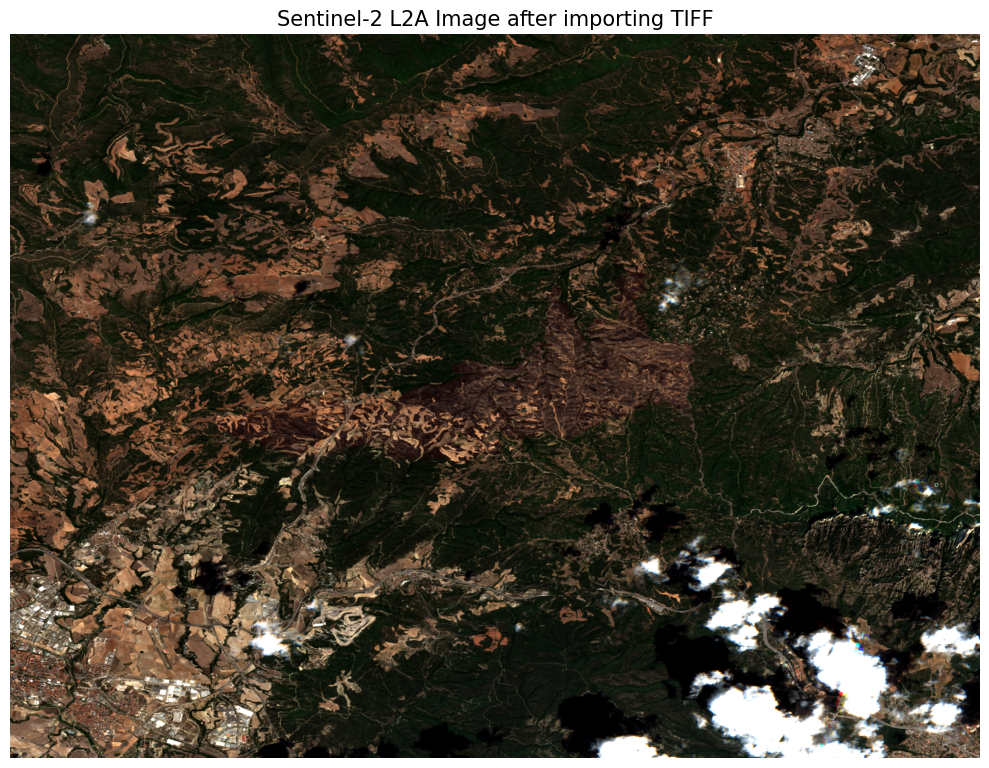

In [30]:
# Examining one image
sample_img_path = os.path.join(output_folder, '2015', 'images', 'sentinel2_2015-07-26_lon1-719_lat41-635.tiff')

# Open with rasterio
with rasterio.open(sample_img_path) as src:
    print(f"Image shape: {src.shape}")
    print(f"Number of bands: {src.count}")
    print(f"CRS: {src.crs}")
    print(f"Transform: {src.transform}")

    # Visualize the sample image by converting it to a tensor
    sample_image_array = src.read()  # Read all bands
    sample_image_array = np.transpose(sample_image_array, (1, 2, 0))

    # Convert to torch tensor for visualization
    sample_image_tensor = torch.from_numpy(sample_image_array).permute(2, 0, 1)

    # Display the image using the custom visualization function
    # For Sentinel-2, true color is B04 (Red), B03 (Green), B02 (Blue)
    # These correspond to indices 3, 2, and 1 in the 13-band array
    visualizations.display_image(
        image=sample_image_tensor,
        title=f'Sentinel-2 L2A Image after importing TIFF',
        rgb_bands=(3, 2, 1),  # Corresponding to B04, B03, B02 bands
        figsize=(10, 10)
    )

#### For Sentinel-1 GRD data

In [3]:
base_path = os.path.join(root_output_dir, 'catalunya_fire_imgs') 

folders = preprocessing.inference_dataset.find_year_folders(base_path)

for folder in folders:
    print(f"Processing folder: {folder}")

Searching for year folders in: /media/pablo/Shared files/data/catalunya_fire_imgs
Found 10 year folders.
First folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2014
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2014
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2015
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2016
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2017
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2018
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2019
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2020
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2021
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2022
Processing folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2023


In [4]:
for folder in folders:
    matching_images = preprocessing.inference_dataset.get_matching_images(folder, file_extension='tiff')
    
    if matching_images:
        print(f"Found {len(matching_images)} matching images in folder: {folder}")
        for event in matching_images:
            print(f"  Event ID: {event['id']}, S1: {event['sentinel1']}, S2: {event['sentinel2']}")
    else:
        print(f"No matching images found in folder: {folder}")

Found 1 unique fire events in 2014
Found 1 matching images in folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2014
  Event ID: 2014-10-22_lon3-223_lat42-244, S1: /media/pablo/Shared files/data/catalunya_fire_imgs/2014/images/sentinel1_2014-10-22_lon3-223_lat42-244.tiff, S2: None
Found 13 unique fire events in 2015
Found 13 matching images in folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2015
  Event ID: 2015-01-07_lon2-150_lat41-445, S1: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-01-07_lon2-150_lat41-445.tiff, S2: None
  Event ID: 2015-03-31_lon1-222_lat42-610, S1: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-03-31_lon1-222_lat42-610.tiff, S2: None
  Event ID: 2015-04-06_lon2-766_lat41-834, S1: /media/pablo/Shared files/data/catalunya_fire_imgs/2015/images/sentinel1_2015-04-06_lon2-766_lat41-834.tiff, S2: None
  Event ID: 2015-04-21_lon0-685_lat42-795, S1: /media/pablo/Shared files/data/cataluny

Finally, let's check if the dimension for each pair of S1 and S2 images matches (whenever both exist for a fire event).

In [5]:
# This list will store details of any mismatches found
mismatched_dimensions = []
total_pairs_checked = 0

# Get the base path from a previous cell
base_path = os.path.join(root_output_dir, 'catalunya_fire_imgs')
folders = preprocessing.inference_dataset.find_year_folders(base_path)

# Iterate through each year's folder
for year_folder in folders:
    print(f"\n--- Checking year: {os.path.basename(year_folder)} ---")
    
    # Get the list of matching S1 and S2 images for the current year
    matching_images = preprocessing.inference_dataset.get_matching_images(year_folder, file_extension='tiff')
    
    # Iterate through each fire event in the year
    for event in matching_images:
        s1_path = event.get('sentinel1')
        s2_path = event.get('sentinel2')
        
        # Check only if both S1 and S2 images exist for the event
        if s1_path and s2_path:
            total_pairs_checked += 1
            try:
                # Open Sentinel-1 image and get dimensions
                with rasterio.open(s1_path) as s1_src:
                    s1_dims = (s1_src.width, s1_src.height)
                
                # Open Sentinel-2 image and get dimensions
                with rasterio.open(s2_path) as s2_src:
                    s2_dims = (s2_src.width, s2_src.height)
                
                # Compare dimensions
                if s1_dims != s2_dims:
                    mismatch_info = {
                        'event_id': event['id'],
                        's1_path': s1_path,
                        's1_dims': s1_dims,
                        's2_path': s2_path,
                        's2_dims': s2_dims
                    }
                    mismatched_dimensions.append(mismatch_info)
                    print(f"❌ MISMATCH for event {event['id']}: S1 is {s1_dims}, S2 is {s2_dims}")

            except Exception as e:
                print(f"ERROR processing event {event['id']}: {e}")

# --- Final Summary ---
print("\n" + "="*50)
print("DIMENSION CONSISTENCY CHECK SUMMARY")
print("="*50)

print(f"Total pairs of S1/S2 images checked: {total_pairs_checked}")

if not mismatched_dimensions:
    print("✅ SUCCESS: All corresponding Sentinel-1 and Sentinel-2 images have matching dimensions.")
else:
    print(f"❌ FAILURE: Found {len(mismatched_dimensions)} events with mismatched dimensions.")
    for mismatch in mismatched_dimensions:
        print(f"  - Event: {mismatch['event_id']}")
        print(f"    S1 Dims: {mismatch['s1_dims']} ({os.path.basename(mismatch['s1_path'])})")
        print(f"    S2 Dims: {mismatch['s2_dims']} ({os.path.basename(mismatch['s2_path'])})")

Searching for year folders in: /media/pablo/Shared files/data/catalunya_fire_imgs
Found 10 year folders.
First folder: /media/pablo/Shared files/data/catalunya_fire_imgs/2014

--- Checking year: 2014 ---
Found 1 unique fire events in 2014

--- Checking year: 2015 ---
Found 13 unique fire events in 2015

--- Checking year: 2016 ---
Found 16 unique fire events in 2016

--- Checking year: 2017 ---
Found 35 unique fire events in 2017

--- Checking year: 2018 ---
Found 12 unique fire events in 2018

--- Checking year: 2019 ---
Found 26 unique fire events in 2019

--- Checking year: 2020 ---
Found 11 unique fire events in 2020

--- Checking year: 2021 ---
Found 21 unique fire events in 2021

--- Checking year: 2022 ---
Found 43 unique fire events in 2022

--- Checking year: 2023 ---
Found 22 unique fire events in 2023

DIMENSION CONSISTENCY CHECK SUMMARY
Total pairs of S1/S2 images checked: 179
✅ SUCCESS: All corresponding Sentinel-1 and Sentinel-2 images have matching dimensions.
